# Setup

## Imports

In [86]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

import torch
import torch.autograd.variable as Variable
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as utils
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from shutil import copyfile

# Preparing dataloaders

## **Raw data**



### Downloading data


We use the Adience dataset consisting unfiltered faces ([Link](https://talhassner.github.io/home/projects/Adience/Adience-data.html#agegender)). Then, we unzip it.  
The first cell below downloads the data for you and places it in the **data** directory. The second cell unzips the data.

### Downloading folds

All five folds used in this paper are present [here](https://github.com/GilLevi/AgeGenderDeepLearning/tree/master/Folds/train_val_txt_files_per_fold). Download the **train_val_txt_files_per_fold** folder and place it in **My Drive/AgeGenderClassification/data**.


## Data loading

In [3]:
PATH_TO_FOLDS = "data/train_val_txt_files_per_fold"
PATH_TO_DATA = "data/"
PATH_TO_IMAGE_FOLDERS = PATH_TO_DATA + "aligned/"

In [4]:
# Notify me on completion by sound
from IPython.display import Audio
sound_file = '/root/beep-07a.wav'

#Audio(sound_file, autoplay=True)

### Creating a Dataset class

We create a class **`AdienceDataset`** that extends **`Dataset`**. This class helps us in feeding the input data to the network in minibatches.

[This](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) is a useful tutorial on how to load and augment data in PyTorch. 

In [5]:
class AdienceDataset(Dataset):
    
    def __init__(self, txt_file, root_dir, transform):
        self.txt_file = txt_file
        self.root_dir = root_dir
        self.transform = transform
        self.data = self.read_from_txt_file()
    
    def __len__(self):
        return len(self.data)

    def read_from_txt_file(self):
        data = []
        f = open(self.txt_file)
        for line in f.readlines():
            image_file, label = line.split() 
            label = int(label)
            if 'gender' in self.txt_file:
                label += 8
            data.append((image_file, label))
        return data
    
    def __getitem__(self, idx):
        img_name, label = self.data[idx]
        image = Image.open(self.root_dir + '/' + img_name)
        
        if self.transform:
            image = self.transform(image)
            
        return {
            'image': image,
            'label': label
        }
    
class AdienceDatasetCombined(Dataset):
    
    def __init__(self, txt_dir, subset, root_dir, transform):
        self.txt_dir = txt_dir
        self.subset = subset
        self.root_dir = root_dir
        self.transform = transform
        self.data = self.read_from_txt_file()
    
    def __len__(self):
        return len(self.data)

    def read_from_txt_file(self):
        data = []
        data2 = []
        age_txt_file = f'{self.txt_dir}/age_{self.subset}.txt'
        gender_txt_file = f'{self.txt_dir}/gender_{self.subset}.txt'
        age_file = open(age_txt_file)        
        for line in age_file.readlines():
            image_file, label = line.split() 
            label = int(label)
            data.append((image_file, label))
        age_file.close()
        gender_file = open(gender_txt_file)
        for line in gender_file.readlines():
            image_file, label = line.split() 
            label = int(label)
            for record in data:
                if (record[0] == image_file):
                    data2.append((image_file, record[1] + 10*label))
                    break
        return data2
    
    def __getitem__(self, idx):
        img_name, label = self.data[idx]
        image = Image.open(self.root_dir + '/' + img_name)
        
        if self.transform:
            image = self.transform(image)
            
        return {
            'image': image,
            'label': label
        }

### Transforms
Every image is first resized to a `256x256` image and then cropped to a `227x227` image before being fed to the network.

**`transforms_list`** is the list of transforms we would like to apply to the input data. Apart from training the neural network without any transformations, we can also train the network using the following transforms (also called as data augmentation techniques):
*   random horizontal flip
*   random crop and random horizontal flip

We don't perform any transformation on the images during validation and testing.


In [6]:
transforms_list = [
    transforms.Resize(256), # 0 (required)
    transforms.CenterCrop(227), #1 (required)
    transforms.RandomHorizontalFlip(), #2
    transforms.ToTensor(), #3 (required)
    transforms.RandomCrop(227) #4
]

# Adversarial training
# Look into increase or decrease contrast
# Look into principal component analysis (PCA) on the RGB colourspace

# Pre-training using the CelebA dataset http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html
# Essentially, meaning getting parameters but not calculating accuracy

transforms_dict = {
    'train': {
        0: list(transforms_list[i] for i in [0, 1, 3]),        # no transformation
        1: list(transforms_list[i] for i in [0, 1, 2, 3]),     # random horizontal flip
        2: list(transforms_list[i] for i in [0, 4, 2, 3])      # random crop and random horizontal flip
    },
    'val': {
        0: list(transforms_list[i] for i in [0, 1, 3])
    },
    'test': {
        0: list(transforms_list[i] for i in [0, 1, 3])
    }
}

### Dataloader
The **`DataLoader`** class in PyTorch helps us iterate through the dataset. This is where we input **`minibatch_size`** to our algorithm.

In [7]:
def get_dataloader(s, c, fold, transform_index, minibatch_size):
    """
    Args:
        s: A string. Equals either "train", "val", or "test".
        c: A string. Equals either "age" or "gender", or 'both'
        fold: An integer. Lies in the range [0, 4] as there are five folds present.
        transform_index: An integer. The transforms in the list correesponding
            to this index in the dictionary will be applied on the images.
        minibatch_size: An integer.

    Returns:
        An instance of the DataLoader class.
    """
    root_dir = PATH_TO_IMAGE_FOLDERS
    if c == "both":
        txt_file = f'{PATH_TO_FOLDS}/test_fold_is_{fold}'
        transformed_dataset = AdienceDatasetCombined(txt_file, s, root_dir,
                                         transforms.Compose(transforms_dict[s][transform_index]))
        dataloader = DataLoader(transformed_dataset, batch_size=minibatch_size, shuffle=True, num_workers=24)
        return dataloader
    else:
        txt_file = f'{PATH_TO_FOLDS}/test_fold_is_{fold}/{c}_{s}.txt'        
        transformed_dataset = AdienceDataset(txt_file, root_dir,
                                         transforms.Compose(transforms_dict[s][transform_index]))
        dataloader = DataLoader(transformed_dataset, batch_size=minibatch_size, shuffle=True, num_workers=24)
        return dataloader    

# Network

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:
PATH_TO_MODELS = "models"

## Defining the network
This is the network as described in the [paper](https://talhassner.github.io/home/projects/cnn_agegender/CVPR2015_CNN_AgeGenderEstimation.pdf).

In [10]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 96, 7, stride = 4, padding = 1)
        self.pool1 = nn.MaxPool2d(3, stride = 2, padding = 1)
        self.norm1 = nn.LocalResponseNorm(size = 5, alpha = 0.0001, beta = 0.75)
        
        self.conv2 = nn.Conv2d(96, 256, 5, stride = 1, padding = 2)
        self.pool2 = nn.MaxPool2d(3, stride = 2, padding = 1)
        self.norm2 = nn.LocalResponseNorm(size = 5, alpha = 0.0001, beta = 0.75)
        
        self.conv3 = nn.Conv2d(256, 384, 3, stride = 1, padding = 1)
        self.pool3 = nn.MaxPool2d(3, stride = 2, padding = 1)
        self.norm3 = nn.LocalResponseNorm(size = 5, alpha = 0.0001, beta = 0.75)
        
        self.fc1 = nn.Linear(18816, 512)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(512, 512)
        self.dropout2 = nn.Dropout(0.5)
  
        self.fc3 = nn.Linear(512, 18)
    
        self.apply(weights_init)

    
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = self.pool1(x)
        x = self.norm1(x)

        x = F.leaky_relu(self.conv2(x))
        x = self.pool2(x)
        x = self.norm2(x)
      
        x = F.leaky_relu(self.conv3(x))
        x = self.pool3(x)
        x = self.norm3(x)
      
        x = x.view(-1, 18816)
        
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.dropout1(x)
      
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.dropout2(x)
      
        x = F.log_softmax(self.fc3(x), dim=1)
  
        return x

class NewNet(nn.Module):
    
    def __init__(self):
        super(NewNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 96, 7, stride = 4, padding = 1)
        self.pool1 = nn.MaxPool2d(3, stride = 2, padding = 1)
        self.norm1 = nn.LocalResponseNorm(size = 5, alpha = 0.0001, beta = 0.75)
        
        self.conv2 = nn.Conv2d(96, 256, 5, stride = 1, padding = 2)
        self.pool2 = nn.MaxPool2d(3, stride = 2, padding = 1)
        self.norm2 = nn.LocalResponseNorm(size = 5, alpha = 0.0001, beta = 0.75)
        
        self.conv3 = nn.Conv2d(256, 384, 3, stride = 1, padding = 1)
        self.pool3 = nn.MaxPool2d(3, stride = 2, padding = 1)
        self.norm3 = nn.LocalResponseNorm(size = 5, alpha = 0.0001, beta = 0.75)
        
        self.fc1 = nn.Linear(18816, 512)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(512, 512)
        self.dropout2 = nn.Dropout(0.5)
  
        self.fc3 = nn.Linear(512, 18)
    
        self.apply(weights_init)

    
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = self.pool1(x)
        x = self.norm1(x)

        x = F.leaky_relu(self.conv2(x))
        x = self.pool2(x)
        x = self.norm2(x)
      
        x = F.leaky_relu(self.conv3(x))
        x = self.pool3(x)
        x = self.norm3(x)
      
        x = x.view(-1, 18816)
        
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.dropout1(x)
      
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.dropout2(x)
      
        x = F.log_softmax(self.fc3(x), dim=1)
  
        return x

In [11]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0, std=1e-2)

In [12]:
criterion = nn.NLLLoss()

## Hyperparameters
Try playing with these! While the **`minibatch_size`** and **`lr`** are pulled from the paper, **`num_epochs`** is set empirically. 

In [27]:
minibatch_size = 50
num_epochs = 200
lr = 0.0001  # initial learning rate

## Training the network
We save the network to the drive and compute the loss on validation set after every **`checkpoint_frequency`** number of iterations. We decrease the learning by a tenth after 10,000 iterations using the **`MultiStepLR`** class of PyTorch.

In [13]:
def train(net, train_dataloader, epochs, filename, checkpoint_frequency=50, val_dataloader=None, patience=None):
    """
    Args:
        net: An instance of PyTorch's Net class.
        train_dataloader: An instance of PyTorch's Dataloader class.
        epochs: An integer.
        filename: A string. Name of the model saved to drive.
        checkpoint_frequency: An integer. Represents how frequent (in terms
            of number of iterations) the model should be saved to drive.
        val_dataloader: An instance of PyTorch's Dataloader class.
    
    Returns:
        net: An instance of PyTorch's Net class. The trained network.
        training_loss: A list of numbers that represents the training loss at each checkpoint.
        validation_loss: A list of numbers that represents the validation loss at each checkpoint.
    """
    net.train()
    optimizer = optim.Adam(net.parameters(), lr)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10000])
    
    training_loss, validation_loss = [], []
    checkpoint = 0
    iteration = 0
    running_loss = 0
    best_iteration = 1
    best_validation_loss = np.inf
    
    for epoch in range(epochs):
        
        for i, batch in enumerate(train_dataloader):
            scheduler.step()
            optimizer.zero_grad()
            images, labels = batch['image'].to(device), batch['label'].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            running_loss += float(loss.item())
            loss.backward()
            optimizer.step()
            
            if (iteration+1) % checkpoint_frequency == 0 and val_dataloader is not None:
                if patience == None:
                    training_loss.append(running_loss/checkpoint_frequency)
                    validation_loss.append(validate(net, val_dataloader))
                    print(f'minibatch:{i}, epoch:{epoch+1}, iteration:{iteration}, training_error:{training_loss_result}, validation_error:{validation_loss_result}')
                    save_network(net, f'{filename}_checkpoint{checkpoint}')                        
                elif patience > 0:
                    training_loss_result = running_loss/checkpoint_frequency
                    validation_loss_result = validate(net, val_dataloader)
                    print(f'minibatch:{i}, epoch:{epoch+1}, iteration:{iteration}, training_error:{training_loss_result}, validation_error:{validation_loss_result}')
                    if best_validation_loss >= validation_loss_result:
                        print(f'Best loss improvement from {best_validation_loss} to {validation_loss_result} in epoch {epoch+1}')
                        best_validation_loss = validation_loss_result
                        best_epoch = epoch + 1
                        training_loss.append(training_loss_result)
                        validation_loss.append(validation_loss_result)
                        save_network(net, f'{filename}_checkpoint{checkpoint}')
                        best_iteration = iteration + 1
                    elif best_iteration + patience * checkpoint_frequency <= iteration:
                        print(f"Patience ran out at {iteration}. Ending training")
                        return net, training_loss, validation_loss
                    else:
                        training_loss.append(training_loss_result)
                        validation_loss.append(validation_loss_result)
                checkpoint += 1
                running_loss = 0
            iteration += 1

    return net, training_loss, validation_loss

## Validation
We evaluate the performance (in terms of loss) of the trained network on validation set.

In [14]:
def validate(net, dataloader):
    net.train()
    total_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            images, labels = batch['image'].to(device), batch['label'].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            total_loss += float(loss.item())

    return total_loss/(i+1)

In [15]:
def get_validation_error(c, fold, train_transform_index):
    filename = get_model_filename(c, fold, train_transform_index)
    net = Net().to(device)
    net.load_state_dict(torch.load(f'{PATH_TO_MODELS}/{filename}'))
    return validate(net, get_dataloader('val', c, fold, 0, minibatch_size))

## Testing
We evaluate the performance (in terms of accuracy) of the trained network on the test set.

In [34]:
def test(net, dataloader, c):
    result = {
        'exact_match': 0,
        'total': 0
    }
    if c != 'gender':
        result['one_off_match'] = 0
    if c == 'both':
        result['gender_match'] = 0
        result['age_match'] = 0
        result['one_off_age_match'] = 0

    with torch.no_grad():
        net.eval()
        for i, batch in enumerate(dataloader):
            images, labels = batch['image'].to(device), batch['label'].to(device)
            outputs = net(images)
            outputs = torch.tensor(list(map(lambda x: torch.max(x, 0)[1], outputs))).to(device)
            result['total'] += len(outputs)
            result['exact_match'] += sum(outputs == labels).item()
            if c != 'gender':
                result['one_off_match'] += (sum(outputs==labels) +
                                            sum(outputs==labels-1) +
                                            sum(outputs==labels+1)).item()
            if c == 'both':
                for count, o in enumerate(outputs):
                    o = o.item()
                    if o <= 7: # male
                        if labels[count].item() >= 0 and labels[count].item() <= 7:
                            result['gender_match'] += 1
                        if labels[count].item() == o or labels[count].item() == o + 7:
                            result['age_match'] += 1
                            result['one_off_age_match'] += 1
                        if labels[count].item() == o + 1 or labels[count].item() == o - 1 \
                        or labels[count].item() == o + 8 or labels[count].item() == o + 6:
                            result['one_off_age_match'] += 1
                    elif o >= 10: # female
                        if labels[count].item() >= 10:
                            result['gender_match'] += 1
                        if labels[count].item() == o or labels[count].item() == o - 7:
                            result['age_match'] += 1
                            result['one_off_age_match'] += 1
                        if labels[count].item() == o + 1 or labels[count].item() == o - 1 \
                        or labels[count].item() == o - 8 or labels[count].item() == o - 6:
                            result['one_off_age_match'] += 1

    return result           

## Saving the network

In [17]:
def save_network(net, filename):
    torch.save(net.state_dict(), f'{PATH_TO_MODELS}/{filename}.pt')

# Execution

### Picking the best model for a fold
**`train_save()`** trains the network using the **`train()`** function and then, using the validation losses returned by this function at all checkpoints, chooses the model with least validation error. This function also plots a graph of training and validation errors over the iterations.

**Usage:**

For e.g., if you want to train the network for **`age`** using **`fold=2`** and **`train_transform_index=2`**,
```
train_save('age', 2, 2)
```



In [18]:
def train_save(c, fold, train_transform_index, checkpoint_frequency=50, patience=10):
    """
    Args:
        c: A string. Equals either "age" or "gender".
        fold: An integer. Lies in the range [0, 4] as there are five folds present.
        train_transform_index: An integer. The transforms in the list correesponding
            to this index in the dictionary will be applied on the images.
        checkpoint_frequency: An integer. Represents how frequent (in terms
            of number of iterations) the model should be saved to drive.   
    Returns:
        validation_loss: A list of numbers that represents the validation loss at each checkpoint.
    """
    if c != "both":
        trained_net, training_loss, validation_loss = train(
            Net().to(device),
            get_dataloader('train', c, fold, train_transform_index, minibatch_size),
            num_epochs,
            f'{fold}_{c}_train_{train_transform_index}',
            checkpoint_frequency,
            get_dataloader('val', c, fold, 0, minibatch_size),
            patience=patience
        )

        plt.plot(list(range(1, len(validation_loss)+1)), validation_loss, label='validation_loss')
        plt.plot(list(range(1, len(training_loss)+1)), training_loss, label='training_loss')
        plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=2, mode="expand", borderaxespad=0.)
        plt.xlabel('iterations')
        plt.ylabel('loss')
        plt.show()

        choose_model_with_least_val_error(c, fold, train_transform_index, validation_loss)

        return validation_loss
    else:
        trained_net, training_loss, validation_loss = train(
            NewNet().to(device),
            get_dataloader('train', c, fold, train_transform_index, minibatch_size),
            num_epochs,
            f'{fold}_{c}_train_{train_transform_index}',
            checkpoint_frequency,
            get_dataloader('val', c, fold, 0, minibatch_size),
            patience=patience
        )

        plt.plot(list(range(1, len(validation_loss)+1)), validation_loss, label='validation_loss')
        plt.plot(list(range(1, len(training_loss)+1)), training_loss, label='training_loss')
        plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=2, mode="expand", borderaxespad=0.)
        plt.xlabel('iterations')
        plt.ylabel('loss')
        plt.show()

        choose_model_with_least_val_error(c, fold, train_transform_index, validation_loss)

        return validation_loss

In [19]:
def choose_model_with_least_val_error(c, fold, train_transform_index, validation_loss):
    index = validation_loss.index(min(validation_loss))
    filename = f'{fold}_{c}_train_{train_transform_index}'
    for file in os.listdir(PATH_TO_MODELS):
        if file.startswith(filename):
            if file.startswith(f'{filename}_checkpoint{index}'):
                pass
            else:
                os.remove(f'{PATH_TO_MODELS}/{file}')

### Picking the best model among all the folds

Using **`pick_best_model()`**, we can pick the model among various folds that gives us the best validation accuracy. The best model's name is appended with **_best **in the **models** directory. 

**Usage:**

To pick the best model for **`age`**,
```
pick_best_model('age')
```


To pick the best model for **`gender`**,

```
pick_best_model('gender')
```

In [20]:
def pick_best_model(c):
    """
    Args:
        s: A string. Equals either "train", "val", or "test".
        c: A string. Equals either "age", "gender" or "both".
    """
    def fn_filter(file):
        file_split = file.split('_')
        return True if (len(file_split) == 5 and file_split[1] == c) else False
    
    def fn_map(file):
        file_split = file.split('_')
        return get_validation_error(c, file_split[0], file_split[3])
    
    files = list(filter(fn_filter, os.listdir(PATH_TO_MODELS)))
    val_errors = list(map(fn_map, files))
    min_val_error, file = min(zip(val_errors, files))
    best_model = f'{PATH_TO_MODELS}/{file.split(".")[0]}_best.pt'
    copyfile(f'{PATH_TO_MODELS}/{file}', best_model)
    
    print(f'Picking {best_model} as the best model for {c}...')

### Calculating performance/accuracy

We can check the performance of any model using the **`get_performance()`** function.

**Usage:**

To know the performance on **`age`** classification,
```
get_performance('age')
```


To know the performance on **`gender`** classification,

```
get_performance('gender')
```



In [21]:
def get_performance(c):
    """
    Args:
        c: A string. Equals either "age" or "gender".
    Returns:
        A dictionary containing accuracy (and one-off accuracy for age) of the model.
    """    
    file = get_best_model_filename(c).split('_')
    return get_performance_of_a_model('test', file[1], file[0], file[3])

In [22]:
def get_best_model_filename(c):
    def fn_filter(file):
        file_split = file.split('_')
        return True if (len(file_split) == 6 and file_split[1] == c) else False
    
    return list(filter(fn_filter, os.listdir(PATH_TO_MODELS)))[0]

In [23]:
def get_performance_of_a_model(s, c, fold, train_transform_index):
    """
    Args:
        s: A string. Equals either "train", "val", or "test".
        c: A string. Equals either "age" or "gender".
        fold: An integer. Lies in the range [0, 4] as there are five folds present.
        transform_index: An integer. The transforms in the list correesponding
            to this index in the dictionary will be applied on the images.
    Returns:
        A dictionary containing accuracy (and one-off accuracy for age) of the model.
    """
    filename = get_model_filename(c, fold, train_transform_index)
    if c != "both":
        net = Net().to(device)
        net.load_state_dict(torch.load(f'{PATH_TO_MODELS}/{filename}'))
        performance = test(
            net,
            get_dataloader(s, c, fold, 0, minibatch_size),
            c
        )
        if c != 'gender':
            return {
                'accuracy': performance['exact_match']/performance['total'],
                'one-off accuracy': performance['one_off_match']/performance['total']
            }
        else:
            return {
                'accuracy': performance['exact_match']/performance['total']
            }
    else:
        net = NewNet().to(device)
        net.load_state_dict(torch.load(f'{PATH_TO_MODELS}/{filename}'))
        performance = test(
            net,
            get_dataloader(s, c, fold, 0, minibatch_size),
            c
        )
        return {
            'accuracy': performance['exact_match']/performance['total'],
            'one-off accuracy': performance['one_off_match']/performance['total'],
            'gender accuracy': performance['gender_match']/performance['total'],
            'age accuracy': performance['age_match']/performance['total'],
            'one-off age accuracy': performance['one_off_age_match']/performance['total']
        }

In [24]:
def get_model_filename(c, fold, train_transform_index):
    start_of_filename = f'{fold}_{c}_train_{train_transform_index}_checkpoint'
    for file in os.listdir(PATH_TO_MODELS):
        if file.startswith(start_of_filename):
            return file

In [26]:
print(NewNet())

NewNet(
  (conv1): Conv2d(3, 96, kernel_size=(7, 7), stride=(4, 4), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (norm1): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (norm2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (norm3): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
  (fc1): Linear(in_features=18816, out_features=512, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=512, out_features=18, bias=True)
)


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


minibatch:49, epoch:1, iteration:49, training_error:2.7679682111740114, validation_error:2.6878303488095603
Best loss improvement from inf to 2.6878303488095603 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.676075129508972, validation_error:2.6744193136692047
Best loss improvement from 2.6878303488095603 to 2.6744193136692047 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.6714829874038695, validation_error:2.6686178843180337
Best loss improvement from 2.6744193136692047 to 2.6686178843180337 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.665842208862305, validation_error:2.6585423052310944
Best loss improvement from 2.6686178843180337 to 2.6585423052310944 in epoch 1
minibatch:25, epoch:2, iteration:249, training_error:2.6582757472991942, validation_error:2.6498511135578156
Best loss improvement from 2.6585423052310944 to 2.6498511135578156 in epoch 2
minibatch:75, epoch:2, iteration:299, training_error:2.6451136445999146, vali

minibatch:209, epoch:11, iteration:2449, training_error:1.4209078931808472, validation_error:1.5833564847707748
Best loss improvement from 1.620001624027888 to 1.5833564847707748 in epoch 11
minibatch:35, epoch:12, iteration:2499, training_error:1.3875159811973572, validation_error:1.6055428038040798
minibatch:85, epoch:12, iteration:2549, training_error:1.3758817791938782, validation_error:1.567649205525716
Best loss improvement from 1.5833564847707748 to 1.567649205525716 in epoch 12
minibatch:135, epoch:12, iteration:2599, training_error:1.3779934740066528, validation_error:1.58929609755675
minibatch:185, epoch:12, iteration:2649, training_error:1.3201596665382385, validation_error:1.58010995388031
minibatch:11, epoch:13, iteration:2699, training_error:1.2986078870296478, validation_error:1.5636608004570007
Best loss improvement from 1.567649205525716 to 1.5636608004570007 in epoch 13
minibatch:61, epoch:13, iteration:2749, training_error:1.2476401019096375, validation_error:1.55063

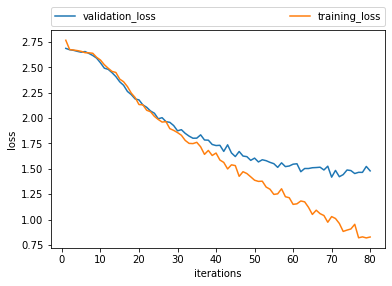

[2.6878303488095603,
 2.6744193136692047,
 2.6686178843180337,
 2.6585423052310944,
 2.6498511135578156,
 2.6564687291781106,
 2.63775904973348,
 2.617632488409678,
 2.591499090194702,
 2.545504401127497,
 2.4926439026991525,
 2.4810968240102134,
 2.4480652809143066,
 2.409535745779673,
 2.3581064542134604,
 2.3238181471824646,
 2.263064513603846,
 2.2317009617884955,
 2.188976913690567,
 2.1795025914907455,
 2.130172520875931,
 2.1065703382094703,
 2.0701280434926352,
 2.048199678460757,
 1.993296464284261,
 2.004241243004799,
 1.9651787330706914,
 1.9582249422868092,
 1.9265176107486088,
 1.8746554652849834,
 1.8860216736793518,
 1.8495981842279434,
 1.8224375645319622,
 1.801695133248965,
 1.8023405621449153,
 1.8350843091805775,
 1.7842778662840526,
 1.7823493679364522,
 1.7400404512882233,
 1.729440261920293,
 1.7319762259721756,
 1.6716936230659485,
 1.7365908821423848,
 1.656435787677765,
 1.6208498726288478,
 1.6708661566178005,
 1.6257952948411305,
 1.620001624027888,
 1.58335

In [28]:
train_save('both', 0, 0, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:2.729780478477478, validation_error:2.66786257425944
Best loss improvement from inf to 2.66786257425944 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.6422885131835936, validation_error:2.64451210587113
Best loss improvement from 2.66786257425944 to 2.64451210587113 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.6235763692855834, validation_error:2.639934945989538
Best loss improvement from 2.64451210587113 to 2.639934945989538 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.6146831130981445, validation_error:2.6428491451122142
minibatch:10, epoch:2, iteration:249, training_error:2.617576575279236, validation_error:2.6278176131071866
Best loss improvement from 2.639934945989538 to 2.6278176131071866 in epoch 2
minibatch:60, epoch:2, iteration:299, training_error:2.6020567750930788, validation_error:2.618718641775626
Best loss improvement from 2.6278176131071866 to 2.618718641775

minibatch:59, epoch:11, iteration:2449, training_error:1.3791324782371521, validation_error:1.5929815283528082
Best loss improvement from 1.5965769114317718 to 1.5929815283528082 in epoch 11
minibatch:109, epoch:11, iteration:2499, training_error:1.407129647731781, validation_error:1.5401986749083907
Best loss improvement from 1.5929815283528082 to 1.5401986749083907 in epoch 11
minibatch:159, epoch:11, iteration:2549, training_error:1.4135890364646913, validation_error:1.5845723328766999
minibatch:209, epoch:11, iteration:2599, training_error:1.4077949690818787, validation_error:1.5361142953236897
Best loss improvement from 1.5401986749083907 to 1.5361142953236897 in epoch 11
minibatch:20, epoch:12, iteration:2649, training_error:1.4102459621429444, validation_error:1.5357067452536688
Best loss improvement from 1.5361142953236897 to 1.5357067452536688 in epoch 12
minibatch:70, epoch:12, iteration:2699, training_error:1.307110722064972, validation_error:1.5089402154639915
Best loss imp

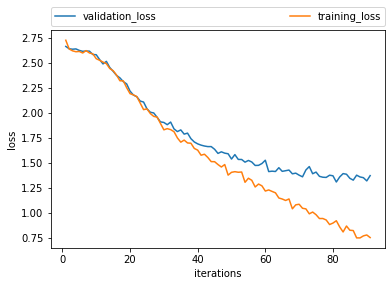

[2.66786257425944,
 2.64451210587113,
 2.639934945989538,
 2.6428491451122142,
 2.6278176131071866,
 2.618718641775626,
 2.622256208349157,
 2.6203055646684437,
 2.5867322109363697,
 2.584723437273944,
 2.5364652739630804,
 2.4926677368305348,
 2.518324675383391,
 2.4568223511731184,
 2.4187778808452465,
 2.377904662379512,
 2.3529766842171,
 2.315440301541929,
 2.2923372983932495,
 2.2202799364372536,
 2.181016524632772,
 2.1641076891510576,
 2.1206016231466225,
 2.1110417622107045,
 2.0429873731401234,
 2.008721691590768,
 2.0016541481018066,
 1.9583177080860845,
 1.91219343079461,
 1.906403206012867,
 1.8840793371200562,
 1.9103611884293732,
 1.8419166891663163,
 1.8151608087398388,
 1.8319194934986256,
 1.7896488772498236,
 1.7995322677824233,
 1.7440819872750177,
 1.7110082264299746,
 1.692179211863765,
 1.679385154335587,
 1.6704582594059132,
 1.6646767678084198,
 1.6648132889359086,
 1.637921346558465,
 1.5965769114317718,
 1.6123131381140814,
 1.5990700677589134,
 1.59298152835

In [29]:
train_save('both', 1, 0, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:2.7129446363449095, validation_error:2.6135434133035167
Best loss improvement from inf to 2.6135434133035167 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.639408268928528, validation_error:2.6184520898041903
minibatch:149, epoch:1, iteration:149, training_error:2.619801321029663, validation_error:2.592912409040663
Best loss improvement from 2.6135434133035167 to 2.592912409040663 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.6045924615859986, validation_error:2.5924857722388372
Best loss improvement from 2.592912409040663 to 2.5924857722388372 in epoch 1
minibatch:12, epoch:2, iteration:249, training_error:2.607371563911438, validation_error:2.5835731824239097
Best loss improvement from 2.5924857722388372 to 2.5835731824239097 in epoch 2
minibatch:62, epoch:2, iteration:299, training_error:2.6041424083709717, validation_error:2.573596724757442
Best loss improvement from 2.5835731824239097 to 2.5

minibatch:129, epoch:11, iteration:2499, training_error:1.4475882315635682, validation_error:1.5804350685190272
Best loss improvement from 1.5880963140063815 to 1.5804350685190272 in epoch 11
minibatch:179, epoch:11, iteration:2549, training_error:1.4005487418174745, validation_error:1.5924194079858285
minibatch:229, epoch:11, iteration:2599, training_error:1.3889500093460083, validation_error:1.5513571015110723
Best loss improvement from 1.5804350685190272 to 1.5513571015110723 in epoch 11
minibatch:42, epoch:12, iteration:2649, training_error:1.4054806399345399, validation_error:1.561611360973782
minibatch:92, epoch:12, iteration:2699, training_error:1.3668062698841095, validation_error:1.5713165292033442
minibatch:142, epoch:12, iteration:2749, training_error:1.3608953535556794, validation_error:1.5213296943240695
Best loss improvement from 1.5513571015110723 to 1.5213296943240695 in epoch 12
minibatch:192, epoch:12, iteration:2799, training_error:1.321455912590027, validation_error

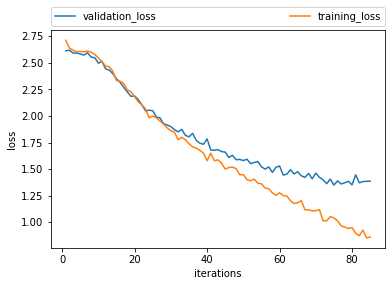

[2.6135434133035167,
 2.6184520898041903,
 2.592912409040663,
 2.5924857722388372,
 2.5835731824239097,
 2.573596724757442,
 2.5943389733632407,
 2.5544703713169805,
 2.547984238024111,
 2.496758054803919,
 2.513321461500945,
 2.4422795242733426,
 2.432446585761176,
 2.3979380837193243,
 2.3496910289481834,
 2.31654601626926,
 2.2686606071613453,
 2.224934979721352,
 2.1844590637418957,
 2.1882038999486855,
 2.154335962401496,
 2.1040665573543973,
 2.0478413546526872,
 2.054433500325238,
 2.0489735029361866,
 1.9896007599654022,
 1.981953876989859,
 1.9267446597417195,
 1.9140644647456981,
 1.8996856212615967,
 1.8709319785789207,
 1.8506368751879092,
 1.8736726001456931,
 1.8180961343977187,
 1.8037228672592729,
 1.8361983652468081,
 1.7699667480256822,
 1.743583462856434,
 1.7332464544861406,
 1.7840304330543235,
 1.6795922429473311,
 1.6768084587874237,
 1.6826224680300113,
 1.6648218852502328,
 1.6598670659241852,
 1.608831003860191,
 1.6294855894865814,
 1.5880963140063815,
 1.590

In [30]:
train_save('both', 2, 0, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:2.7204548072814942, validation_error:2.658866908815172
Best loss improvement from inf to 2.658866908815172 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.6536229133605955, validation_error:2.6301091335437916
Best loss improvement from 2.658866908815172 to 2.6301091335437916 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.6538812208175657, validation_error:2.6285425557030573
Best loss improvement from 2.6301091335437916 to 2.6285425557030573 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.6396721410751343, validation_error:2.6272641287909613
Best loss improvement from 2.6285425557030573 to 2.6272641287909613 in epoch 1
minibatch:8, epoch:2, iteration:249, training_error:2.635961027145386, validation_error:2.629488432848895
minibatch:58, epoch:2, iteration:299, training_error:2.630596942901611, validation_error:2.6119011066578053
Best loss improvement from 2.6272641287909613 to 2.6

minibatch:139, epoch:11, iteration:2549, training_error:1.4516084122657775, validation_error:1.5961753085807517
minibatch:189, epoch:11, iteration:2599, training_error:1.4165455627441406, validation_error:1.5550977918836806
Best loss improvement from 1.5870078669653997 to 1.5550977918836806 in epoch 11
minibatch:239, epoch:11, iteration:2649, training_error:1.4251086592674256, validation_error:1.5354186296463013
Best loss improvement from 1.5550977918836806 to 1.5354186296463013 in epoch 11
minibatch:48, epoch:12, iteration:2699, training_error:1.3407814931869506, validation_error:1.5557710859510634
minibatch:98, epoch:12, iteration:2749, training_error:1.3427717530727385, validation_error:1.5291482784129955
Best loss improvement from 1.5354186296463013 to 1.5291482784129955 in epoch 12
minibatch:148, epoch:12, iteration:2799, training_error:1.3434938549995423, validation_error:1.5252790848414104
Best loss improvement from 1.5291482784129955 to 1.5252790848414104 in epoch 12
minibatch:

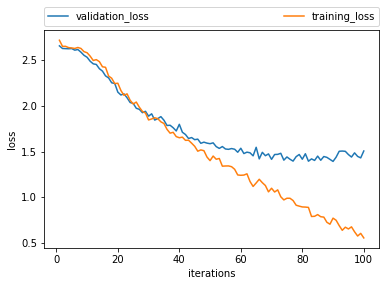

[2.658866908815172,
 2.6301091335437916,
 2.6285425557030573,
 2.6272641287909613,
 2.629488432848895,
 2.6119011066578053,
 2.6187784406873913,
 2.589760736182884,
 2.555367761188083,
 2.533997977221454,
 2.4904828159897416,
 2.461864127053155,
 2.4551888836754694,
 2.4086290200551352,
 2.3823895631013094,
 2.3300673078607628,
 2.3075529204474554,
 2.25431842274136,
 2.2468732992808023,
 2.1519090952696622,
 2.120788984828525,
 2.1328683782506874,
 2.0906986969488637,
 2.0384614732530384,
 2.0283461500097206,
 1.9752161237928603,
 1.9636345748548154,
 1.9268522880695484,
 1.9418323790585552,
 1.8889321618609958,
 1.9143916324332908,
 1.8456784707528573,
 1.8619294431474473,
 1.8834738201565213,
 1.8440173820213035,
 1.7866764642574169,
 1.7889925329773515,
 1.7619509564505682,
 1.726458783502932,
 1.7993895433567189,
 1.7122625554049458,
 1.6877207358678181,
 1.6440757115681965,
 1.6542659512272588,
 1.6311786439683702,
 1.6368630020706743,
 1.5914076213483457,
 1.6038419670528836,
 1

In [31]:
train_save('both', 3, 0, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:2.742882032394409, validation_error:2.6591173227016744
Best loss improvement from inf to 2.6591173227016744 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.6444365310668947, validation_error:2.623964447241563
Best loss improvement from 2.6591173227016744 to 2.623964447241563 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.653191785812378, validation_error:2.635122913580674
minibatch:199, epoch:1, iteration:199, training_error:2.625450530052185, validation_error:2.6232961966441226
Best loss improvement from 2.623964447241563 to 2.6232961966441226 in epoch 1
minibatch:17, epoch:2, iteration:249, training_error:2.6042073345184327, validation_error:2.617073737657987
Best loss improvement from 2.6232961966441226 to 2.617073737657987 in epoch 2
minibatch:67, epoch:2, iteration:299, training_error:2.625154528617859, validation_error:2.617831294353192
minibatch:117, epoch:2, iteration:349, training_error:2.

minibatch:229, epoch:11, iteration:2549, training_error:1.3663377785682678, validation_error:1.431638355438526
Best loss improvement from 1.4624515496767485 to 1.431638355438526 in epoch 11
minibatch:47, epoch:12, iteration:2599, training_error:1.3046700215339662, validation_error:1.4470009757922246
minibatch:97, epoch:12, iteration:2649, training_error:1.3043121314048767, validation_error:1.4169359413477092
Best loss improvement from 1.431638355438526 to 1.4169359413477092 in epoch 12
minibatch:147, epoch:12, iteration:2699, training_error:1.264783183336258, validation_error:1.3957370886435876
Best loss improvement from 1.4169359413477092 to 1.3957370886435876 in epoch 12
minibatch:197, epoch:12, iteration:2749, training_error:1.2933383524417876, validation_error:1.4309958815574646
minibatch:15, epoch:13, iteration:2799, training_error:1.2871912753582, validation_error:1.362320255774718
Best loss improvement from 1.3957370886435876 to 1.362320255774718 in epoch 13
minibatch:65, epoch:

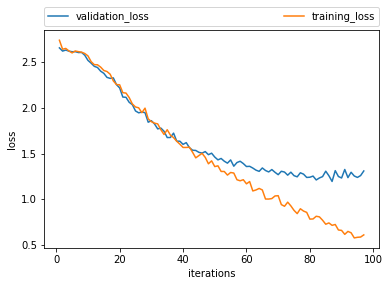

[2.6591173227016744,
 2.623964447241563,
 2.635122913580674,
 2.6232961966441226,
 2.617073737657987,
 2.617831294353192,
 2.6079706228696384,
 2.609254580277663,
 2.5784158890063944,
 2.522182748867915,
 2.491666692953843,
 2.457025014437162,
 2.444244724053603,
 2.404049350665166,
 2.3804602256188025,
 2.3358396016634426,
 2.3249704837799072,
 2.330142543866084,
 2.256186476120582,
 2.2200600183927097,
 2.1200751524705153,
 2.1174940833678613,
 2.0627166628837585,
 2.0369730041577268,
 1.9678848431660578,
 1.947266922547267,
 1.9558446636566749,
 1.9494664760736318,
 1.8444673739946806,
 1.8610044488540063,
 1.8254099946755629,
 1.771190106868744,
 1.7801598127071674,
 1.7451712351578932,
 1.676369309425354,
 1.676787188419929,
 1.7249018412369947,
 1.6366780675374544,
 1.6360627596194928,
 1.60169924222506,
 1.6205008580134466,
 1.5659944736040556,
 1.5372078647980323,
 1.5347289259617145,
 1.5141492119202247,
 1.5059020152458777,
 1.5223013483561003,
 1.4887394905090332,
 1.5048047

In [32]:
train_save('both', 4, 0, patience=10)

minibatch:49, epoch:1, iteration:49, training_error:2.7440571689605715, validation_error:2.6906091471513114
Best loss improvement from inf to 2.6906091471513114 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.69293399810791, validation_error:2.681848814090093
Best loss improvement from 2.6906091471513114 to 2.681848814090093 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.6872647190093994, validation_error:2.6645381450653076
Best loss improvement from 2.681848814090093 to 2.6645381450653076 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.6583450174331666, validation_error:2.6594492495059967
Best loss improvement from 2.6645381450653076 to 2.6594492495059967 in epoch 1
minibatch:25, epoch:2, iteration:249, training_error:2.662874264717102, validation_error:2.6534885267416635
Best loss improvement from 2.6594492495059967 to 2.6534885267416635 in epoch 2
minibatch:75, epoch:2, iteration:299, training_error:2.666239466667175, validatio

minibatch:59, epoch:11, iteration:2299, training_error:1.6112443017959595, validation_error:1.677424505352974
Best loss improvement from 1.7012158930301666 to 1.677424505352974 in epoch 11
minibatch:109, epoch:11, iteration:2349, training_error:1.563774483203888, validation_error:1.669211894273758
Best loss improvement from 1.677424505352974 to 1.669211894273758 in epoch 11
minibatch:159, epoch:11, iteration:2399, training_error:1.5901604294776917, validation_error:1.6926605105400085
minibatch:209, epoch:11, iteration:2449, training_error:1.5564028716087341, validation_error:1.6583985338608425
Best loss improvement from 1.669211894273758 to 1.6583985338608425 in epoch 11
minibatch:35, epoch:12, iteration:2499, training_error:1.5156948828697205, validation_error:1.658725420633952
minibatch:85, epoch:12, iteration:2549, training_error:1.4871529340744019, validation_error:1.6089585920174916
Best loss improvement from 1.6583985338608425 to 1.6089585920174916 in epoch 12
minibatch:135, epoc

minibatch:97, epoch:24, iteration:5249, training_error:0.8409618544578552, validation_error:1.2945535828669865
Best loss improvement from 1.2983116780718167 to 1.2945535828669865 in epoch 24
minibatch:147, epoch:24, iteration:5299, training_error:0.8319398653507233, validation_error:1.2807305827736855
Best loss improvement from 1.2945535828669865 to 1.2807305827736855 in epoch 24
minibatch:197, epoch:24, iteration:5349, training_error:0.8242430782318115, validation_error:1.2629273161292076
Best loss improvement from 1.2807305827736855 to 1.2629273161292076 in epoch 24
minibatch:23, epoch:25, iteration:5399, training_error:0.8165797698497772, validation_error:1.316386769215266
minibatch:73, epoch:25, iteration:5449, training_error:0.782195680141449, validation_error:1.3392746075987816
minibatch:123, epoch:25, iteration:5499, training_error:0.8158964478969574, validation_error:1.2957928304870923
minibatch:173, epoch:25, iteration:5549, training_error:0.8165041345357895, validation_error:

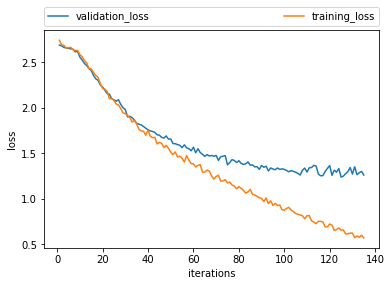

[2.6906091471513114,
 2.681848814090093,
 2.6645381450653076,
 2.6594492495059967,
 2.6534885267416635,
 2.6491659681002298,
 2.6449602842330933,
 2.616195887327194,
 2.6220042407512665,
 2.559085210164388,
 2.5269421339035034,
 2.489204357067744,
 2.4665869176387787,
 2.431886295477549,
 2.412006139755249,
 2.3586599032084146,
 2.32020237048467,
 2.3046432435512543,
 2.253432442744573,
 2.2296250611543655,
 2.196166475613912,
 2.158402810494105,
 2.151385178168615,
 2.101541355252266,
 2.0902584244807563,
 2.0746316413084664,
 2.090359871586164,
 2.0390861680110297,
 2.0027928054332733,
 1.9837130258480709,
 1.9019747972488403,
 1.9093255698680878,
 1.8934227575858433,
 1.8661037236452103,
 1.8318332036336262,
 1.821287487943967,
 1.813802421092987,
 1.7971377273400624,
 1.7772350460290909,
 1.760156085093816,
 1.7473426163196564,
 1.7419927964607875,
 1.7313674638668697,
 1.7056224544843037,
 1.7012158930301666,
 1.677424505352974,
 1.669211894273758,
 1.6926605105400085,
 1.65839853

In [36]:
train_save('both', 0, 1)

minibatch:49, epoch:1, iteration:49, training_error:2.729208536148071, validation_error:2.6688716499893754
Best loss improvement from inf to 2.6688716499893754 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.6396645736694335, validation_error:2.64971093778257
Best loss improvement from 2.6688716499893754 to 2.64971093778257 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.613664360046387, validation_error:2.651119108553286
minibatch:199, epoch:1, iteration:199, training_error:2.6210687351226807, validation_error:2.635347569430316
Best loss improvement from 2.64971093778257 to 2.635347569430316 in epoch 1
minibatch:10, epoch:2, iteration:249, training_error:2.6291813039779663, validation_error:2.622890030896222
Best loss improvement from 2.635347569430316 to 2.622890030896222 in epoch 2
minibatch:60, epoch:2, iteration:299, training_error:2.6153442001342775, validation_error:2.6315938101874456
minibatch:110, epoch:2, iteration:349, training_error:2.621

minibatch:159, epoch:11, iteration:2549, training_error:1.4842852663993835, validation_error:1.5841814014646742
minibatch:209, epoch:11, iteration:2599, training_error:1.4444212627410888, validation_error:1.582704327724598
minibatch:20, epoch:12, iteration:2649, training_error:1.4613741183280944, validation_error:1.546102144100048
Best loss improvement from 1.577172460379424 to 1.546102144100048 in epoch 12
minibatch:70, epoch:12, iteration:2699, training_error:1.4222858428955079, validation_error:1.5436730870494135
Best loss improvement from 1.546102144100048 to 1.5436730870494135 in epoch 12
minibatch:120, epoch:12, iteration:2749, training_error:1.425182650089264, validation_error:1.513206022757071
Best loss improvement from 1.5436730870494135 to 1.513206022757071 in epoch 12
minibatch:170, epoch:12, iteration:2799, training_error:1.468911085128784, validation_error:1.5459223102640223
minibatch:220, epoch:12, iteration:2849, training_error:1.3593113255500793, validation_error:1.5349

minibatch:2, epoch:24, iteration:5499, training_error:0.8256001567840576, validation_error:1.1763737069235907
minibatch:52, epoch:24, iteration:5549, training_error:0.7953499960899353, validation_error:1.1847901432602495
minibatch:102, epoch:24, iteration:5599, training_error:0.8040724819898606, validation_error:1.1632289157973394
Best loss improvement from 1.1704136663013034 to 1.1632289157973394 in epoch 24
minibatch:152, epoch:24, iteration:5649, training_error:0.8097016191482544, validation_error:1.231015728579627
minibatch:202, epoch:24, iteration:5699, training_error:0.7923273110389709, validation_error:1.2048744272302698
minibatch:13, epoch:25, iteration:5749, training_error:0.8091343140602112, validation_error:1.1855260045440108
minibatch:63, epoch:25, iteration:5799, training_error:0.7459071338176727, validation_error:1.2064041738156919
minibatch:113, epoch:25, iteration:5849, training_error:0.7683268678188324, validation_error:1.1983722315894232
minibatch:163, epoch:25, itera

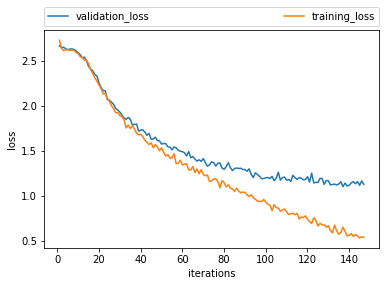

[2.6688716499893754,
 2.64971093778257,
 2.651119108553286,
 2.635347569430316,
 2.622890030896222,
 2.6315938101874456,
 2.63352452384101,
 2.626092063056098,
 2.6125485014032432,
 2.590927247647886,
 2.568602544290048,
 2.533354238227562,
 2.5416703754001193,
 2.5011572396313704,
 2.438938997409962,
 2.4102038895642317,
 2.388028762958668,
 2.3495054333298295,
 2.331297900941637,
 2.25490136941274,
 2.202113244268629,
 2.170140752085933,
 2.1663607314780906,
 2.069085125569944,
 2.064161366886563,
 2.041059860476741,
 2.017376904134397,
 1.9721655050913494,
 1.9553376347930342,
 1.9316300771854542,
 1.898760402644122,
 1.8651710307156597,
 1.8532042238447402,
 1.8730240353831538,
 1.8541162720432989,
 1.789027801266423,
 1.794165880591781,
 1.800160006240562,
 1.7201319535573323,
 1.7324657793398257,
 1.735674712393019,
 1.708842432057416,
 1.675134711795383,
 1.6948423385620117,
 1.6320104334089491,
 1.6324338294841625,
 1.653537189518964,
 1.6165326568815443,
 1.6129434903462727,
 

In [37]:
train_save('both', 1, 1)

minibatch:49, epoch:1, iteration:49, training_error:2.7363687705993653, validation_error:2.623706005237721
Best loss improvement from inf to 2.623706005237721 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.625437216758728, validation_error:2.6148447460598416
Best loss improvement from 2.623706005237721 to 2.6148447460598416 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.632711720466614, validation_error:2.5971524627120406
Best loss improvement from 2.6148447460598416 to 2.5971524627120406 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.6224870777130125, validation_error:2.6016885527858027
minibatch:12, epoch:2, iteration:249, training_error:2.604714560508728, validation_error:2.5929965089868614
Best loss improvement from 2.5971524627120406 to 2.5929965089868614 in epoch 2
minibatch:62, epoch:2, iteration:299, training_error:2.60776291847229, validation_error:2.625618192884657
minibatch:112, epoch:2, iteration:349, training_error:

minibatch:29, epoch:11, iteration:2399, training_error:1.5353932332992555, validation_error:1.5982762840059068
Best loss improvement from 1.6195718668125294 to 1.5982762840059068 in epoch 11
minibatch:79, epoch:11, iteration:2449, training_error:1.538573522567749, validation_error:1.5957811673482258
Best loss improvement from 1.5982762840059068 to 1.5957811673482258 in epoch 11
minibatch:129, epoch:11, iteration:2499, training_error:1.4509117078781129, validation_error:1.5613878788771454
Best loss improvement from 1.5957811673482258 to 1.5613878788771454 in epoch 11
minibatch:179, epoch:11, iteration:2549, training_error:1.4982768034934997, validation_error:1.5779216245368675
minibatch:229, epoch:11, iteration:2599, training_error:1.5213015747070313, validation_error:1.633084703374792
minibatch:42, epoch:12, iteration:2649, training_error:1.416647834777832, validation_error:1.5570027651610199
Best loss improvement from 1.5613878788771454 to 1.5570027651610199 in epoch 12
minibatch:92, 

minibatch:135, epoch:23, iteration:5349, training_error:0.8487517368793488, validation_error:1.2198033686037417
minibatch:185, epoch:23, iteration:5399, training_error:0.8451886713504791, validation_error:1.246670910605678
minibatch:235, epoch:23, iteration:5449, training_error:0.8898480093479156, validation_error:1.1803055140707228
Best loss improvement from 1.1851811408996582 to 1.1803055140707228 in epoch 23
minibatch:48, epoch:24, iteration:5499, training_error:0.8269008255004883, validation_error:1.1702787765750178
Best loss improvement from 1.1803055140707228 to 1.1702787765750178 in epoch 24
minibatch:98, epoch:24, iteration:5549, training_error:0.7916485017538071, validation_error:1.1306070530856098
Best loss improvement from 1.1702787765750178 to 1.1306070530856098 in epoch 24
minibatch:148, epoch:24, iteration:5599, training_error:0.7928503489494324, validation_error:1.2101046906577215
minibatch:198, epoch:24, iteration:5649, training_error:0.7971077334880828, validation_erro

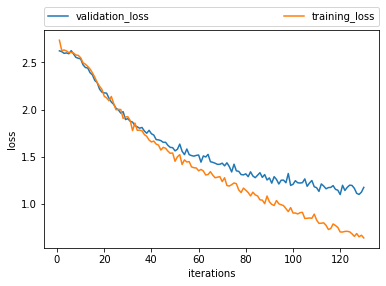

[2.623706005237721,
 2.6148447460598416,
 2.5971524627120406,
 2.6016885527858027,
 2.5929965089868614,
 2.625618192884657,
 2.5904673911907055,
 2.5543145603603787,
 2.5448876751793756,
 2.538319402270847,
 2.4759781802142107,
 2.4466247735200106,
 2.441227948224103,
 2.3914628470385515,
 2.3677346529784025,
 2.309029711617364,
 2.2871289871357106,
 2.217452084576642,
 2.1851414574517145,
 2.1771863345746643,
 2.1744449933369956,
 2.121268453421416,
 2.0800772463833845,
 2.05579361209163,
 2.0134911713776766,
 1.9965894928684942,
 1.9624044718565765,
 1.978070161960743,
 1.893944259043093,
 1.9040344026353624,
 1.8751029041078355,
 1.8670804721337777,
 1.828854967046667,
 1.816477236924348,
 1.8020627277868766,
 1.8102716560716983,
 1.7725188114024975,
 1.7486120285811249,
 1.779635848822417,
 1.743054540069015,
 1.7289210116421734,
 1.6811935504277546,
 1.678174584000199,
 1.6700681492134377,
 1.651853773328993,
 1.6524638334910076,
 1.6195718668125294,
 1.5982762840059068,
 1.595781

In [38]:
train_save('both', 2, 1)

minibatch:49, epoch:1, iteration:49, training_error:2.7465663385391235, validation_error:2.6413781819520175
Best loss improvement from inf to 2.6413781819520175 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.658604869842529, validation_error:2.6257680786980524
Best loss improvement from 2.6413781819520175 to 2.6257680786980524 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.635890831947327, validation_error:2.6344147523244223
minibatch:199, epoch:1, iteration:199, training_error:2.655260457992554, validation_error:2.6482846118785717
minibatch:8, epoch:2, iteration:249, training_error:2.6470502328872683, validation_error:2.629879607094659
minibatch:58, epoch:2, iteration:299, training_error:2.6538210773468016, validation_error:2.6167038546668158
Best loss improvement from 2.6257680786980524 to 2.6167038546668158 in epoch 2
minibatch:108, epoch:2, iteration:349, training_error:2.6123218441009524, validation_error:2.6016503969828286
Best loss improveme

minibatch:39, epoch:11, iteration:2449, training_error:1.5329587864875793, validation_error:1.607130805651347
Best loss improvement from 1.6359735197491116 to 1.607130805651347 in epoch 11
minibatch:89, epoch:11, iteration:2499, training_error:1.5349933433532714, validation_error:1.5828296255182337
Best loss improvement from 1.607130805651347 to 1.5828296255182337 in epoch 11
minibatch:139, epoch:11, iteration:2549, training_error:1.5293974566459656, validation_error:1.6036430288244177
minibatch:189, epoch:11, iteration:2599, training_error:1.5382788109779357, validation_error:1.5989989439646404
minibatch:239, epoch:11, iteration:2649, training_error:1.490117712020874, validation_error:1.54858046107822
Best loss improvement from 1.5828296255182337 to 1.54858046107822 in epoch 11
minibatch:48, epoch:12, iteration:2699, training_error:1.434477114677429, validation_error:1.578164780581439
minibatch:98, epoch:12, iteration:2749, training_error:1.4809599232673645, validation_error:1.5782322

minibatch:147, epoch:23, iteration:5449, training_error:0.8787759053707123, validation_error:1.2517202960120306
Best loss improvement from 1.2737671931584675 to 1.2517202960120306 in epoch 23
minibatch:197, epoch:23, iteration:5499, training_error:0.8627671587467194, validation_error:1.2308600611156888
Best loss improvement from 1.2517202960120306 to 1.2308600611156888 in epoch 23
minibatch:6, epoch:24, iteration:5549, training_error:0.8186768805980682, validation_error:1.2814303746929876
minibatch:56, epoch:24, iteration:5599, training_error:0.8233562397956848, validation_error:1.336723338674616
minibatch:106, epoch:24, iteration:5649, training_error:0.8174895298480988, validation_error:1.3042440392352916
minibatch:156, epoch:24, iteration:5699, training_error:0.8219732177257538, validation_error:1.2487331297662523
minibatch:206, epoch:24, iteration:5749, training_error:0.7995956599712372, validation_error:1.2562899258401659
minibatch:15, epoch:25, iteration:5799, training_error:0.796

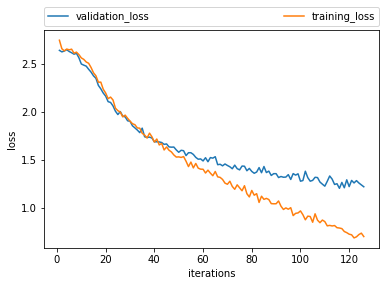

[2.6413781819520175,
 2.6257680786980524,
 2.6344147523244223,
 2.6482846118785717,
 2.629879607094659,
 2.6167038546668158,
 2.6016503969828286,
 2.610918813281589,
 2.5645258250059904,
 2.4998423523373074,
 2.4879198604159884,
 2.4777333029994257,
 2.4451027711232505,
 2.4154789447784424,
 2.3766222883153847,
 2.3512289965594255,
 2.2773971557617188,
 2.2419174865440086,
 2.197920242945353,
 2.166109323501587,
 2.1087722645865545,
 2.1004246649918734,
 2.0648856383782848,
 2.0097619560029774,
 1.9747422889426902,
 2.0057737165027194,
 1.9588791970853452,
 1.9505428296548348,
 1.9099780718485515,
 1.9048892392052545,
 1.857865192272045,
 1.8363104087335091,
 1.81349719453741,
 1.7870611923712272,
 1.8335111450265955,
 1.7435974898161712,
 1.7370421135867085,
 1.740386101934645,
 1.7307658990224202,
 1.691421667734782,
 1.6919559240341187,
 1.6902527720839888,
 1.6842310870135273,
 1.6648895828812211,
 1.669761092574508,
 1.6386699102543019,
 1.6359735197491116,
 1.6371079330091123,
 1

In [39]:
train_save('both', 3, 1)

minibatch:49, epoch:1, iteration:49, training_error:2.727450647354126, validation_error:2.654263184620784
Best loss improvement from inf to 2.654263184620784 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.6320210981369017, validation_error:2.6634495900227475
minibatch:149, epoch:1, iteration:149, training_error:2.6428560829162597, validation_error:2.635173247410701
Best loss improvement from 2.654263184620784 to 2.635173247410701 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.634808034896851, validation_error:2.62265408039093
Best loss improvement from 2.635173247410701 to 2.62265408039093 in epoch 1
minibatch:17, epoch:2, iteration:249, training_error:2.6150114870071413, validation_error:2.6191811103087206
Best loss improvement from 2.62265408039093 to 2.6191811103087206 in epoch 2
minibatch:67, epoch:2, iteration:299, training_error:2.625153889656067, validation_error:2.6013555435033946
Best loss improvement from 2.6191811103087206 to 2.601355543

minibatch:179, epoch:11, iteration:2499, training_error:1.4758531737327576, validation_error:1.4116082925062914
Best loss improvement from 1.460868945488563 to 1.4116082925062914 in epoch 11
minibatch:229, epoch:11, iteration:2549, training_error:1.4348141717910767, validation_error:1.4176028737655053
minibatch:47, epoch:12, iteration:2599, training_error:1.4221305465698242, validation_error:1.4027974468011122
Best loss improvement from 1.4116082925062914 to 1.4027974468011122 in epoch 12
minibatch:97, epoch:12, iteration:2649, training_error:1.3689204883575439, validation_error:1.4187984191454375
minibatch:147, epoch:12, iteration:2699, training_error:1.3723968982696533, validation_error:1.397112474991725
Best loss improvement from 1.4027974468011122 to 1.397112474991725 in epoch 12
minibatch:197, epoch:12, iteration:2749, training_error:1.3665310335159302, validation_error:1.3896684233958905
Best loss improvement from 1.397112474991725 to 1.3896684233958905 in epoch 12
minibatch:15, 

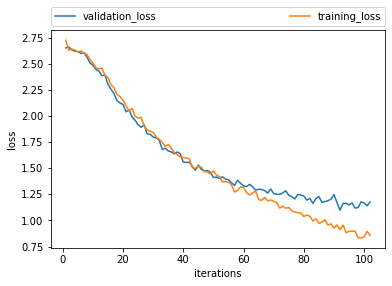

[2.654263184620784,
 2.6634495900227475,
 2.635173247410701,
 2.62265408039093,
 2.6191811103087206,
 2.6013555435033946,
 2.6067135425714345,
 2.5676078154490543,
 2.5098423591026893,
 2.489594111075768,
 2.4472841024398804,
 2.4312858398144064,
 2.387900765125568,
 2.3924389527394223,
 2.3050263753304114,
 2.257085286653959,
 2.217591799222506,
 2.1471562339709354,
 2.1266595125198364,
 2.1108807921409607,
 2.041603152568524,
 2.0588329571944017,
 1.9921047183183522,
 1.9605863506977375,
 1.9179690801180327,
 1.8929368395071764,
 1.9175027150374193,
 1.8293194083067088,
 1.8260826055820172,
 1.7993150995327876,
 1.7930178825671856,
 1.7687524878061736,
 1.682653573843149,
 1.6921401940859282,
 1.666162302860847,
 1.6575142282706041,
 1.6390959803874676,
 1.6570031826312726,
 1.6389116507310133,
 1.559569776058197,
 1.5563320838488066,
 1.5590508305109465,
 1.518400334394895,
 1.4818183596317585,
 1.530803001843966,
 1.4881580426142766,
 1.4749652376541724,
 1.47916435278379,
 1.46086

In [40]:
train_save('both', 4, 1)

minibatch:49, epoch:1, iteration:49, training_error:2.757272620201111, validation_error:2.679059366385142
Best loss improvement from inf to 2.679059366385142 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.684074354171753, validation_error:2.660633405049642
Best loss improvement from 2.679059366385142 to 2.660633405049642 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.666034250259399, validation_error:2.661788672208786
minibatch:199, epoch:1, iteration:199, training_error:2.665331301689148, validation_error:2.6535525918006897
Best loss improvement from 2.660633405049642 to 2.6535525918006897 in epoch 1
minibatch:25, epoch:2, iteration:249, training_error:2.6365850925445558, validation_error:2.6503645280996957
Best loss improvement from 2.6535525918006897 to 2.6503645280996957 in epoch 2
minibatch:75, epoch:2, iteration:299, training_error:2.6642809295654297, validation_error:2.6503950158754983
minibatch:125, epoch:2, iteration:349, training_error:2.

minibatch:35, epoch:12, iteration:2499, training_error:1.7369897365570068, validation_error:1.7728963394959767
minibatch:85, epoch:12, iteration:2549, training_error:1.735416555404663, validation_error:1.7544120748837788
minibatch:135, epoch:12, iteration:2599, training_error:1.7505124425888061, validation_error:1.7550307661294937
minibatch:185, epoch:12, iteration:2649, training_error:1.709227476119995, validation_error:1.7578538954257965
minibatch:11, epoch:13, iteration:2699, training_error:1.6938320112228393, validation_error:1.6841936310132344
Best loss improvement from 1.712927758693695 to 1.6841936310132344 in epoch 13
minibatch:61, epoch:13, iteration:2749, training_error:1.6764366006851197, validation_error:1.7061188320318859
minibatch:111, epoch:13, iteration:2799, training_error:1.6590489149093628, validation_error:1.680571715037028
Best loss improvement from 1.6841936310132344 to 1.680571715037028 in epoch 13
minibatch:161, epoch:13, iteration:2849, training_error:1.6784659

minibatch:23, epoch:25, iteration:5399, training_error:1.1723632276058198, validation_error:1.3321161046624184
minibatch:73, epoch:25, iteration:5449, training_error:1.140080509185791, validation_error:1.2798817579944928
Best loss improvement from 1.311940570672353 to 1.2798817579944928 in epoch 25
minibatch:123, epoch:25, iteration:5499, training_error:1.1284221971035004, validation_error:1.3477339148521423
minibatch:173, epoch:25, iteration:5549, training_error:1.1036813509464265, validation_error:1.3166306714216869
minibatch:223, epoch:25, iteration:5599, training_error:1.1229635238647462, validation_error:1.285964051882426
minibatch:49, epoch:26, iteration:5649, training_error:1.0761906111240387, validation_error:1.3141897494594257
minibatch:99, epoch:26, iteration:5699, training_error:1.0631617748737334, validation_error:1.2552679131428401
Best loss improvement from 1.2798817579944928 to 1.2552679131428401 in epoch 26
minibatch:149, epoch:26, iteration:5749, training_error:1.06743

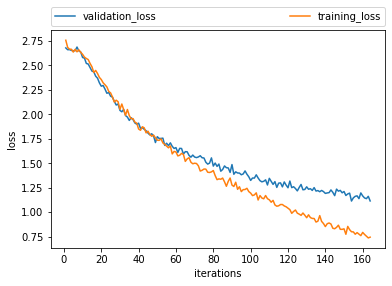

[2.679059366385142,
 2.660633405049642,
 2.661788672208786,
 2.6535525918006897,
 2.6503645280996957,
 2.6503950158754983,
 2.6877510945002236,
 2.64859938621521,
 2.636995553970337,
 2.5809704264005027,
 2.5748254358768463,
 2.520481357971827,
 2.5144127011299133,
 2.4775357445081077,
 2.4425129691759744,
 2.4346545537312827,
 2.3905614217122397,
 2.36968140800794,
 2.3223206400871277,
 2.2884408632914224,
 2.2951273719469705,
 2.25850972533226,
 2.216079592704773,
 2.2233878473440805,
 2.1860141456127167,
 2.1761651933193207,
 2.1322311659653983,
 2.0962136636177697,
 2.1066520363092422,
 2.0412598898013434,
 2.0270390808582306,
 2.0512289504210153,
 1.988116517663002,
 1.9730609109004338,
 1.9389400631189346,
 1.966194252173106,
 1.948268602291743,
 1.9128719419240952,
 1.9003257602453232,
 1.9107145617405574,
 1.8580824186404545,
 1.8640079895655315,
 1.849054088195165,
 1.8332100907961528,
 1.8098599016666412,
 1.791093518336614,
 1.8025185018777847,
 1.7815475861231487,
 1.712927

In [41]:
train_save('both', 0, 2)

minibatch:49, epoch:1, iteration:49, training_error:2.743612904548645, validation_error:2.6650219316835755
Best loss improvement from inf to 2.6650219316835755 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.642664713859558, validation_error:2.670744887104741
minibatch:149, epoch:1, iteration:149, training_error:2.625750813484192, validation_error:2.637095954683092
Best loss improvement from 2.6650219316835755 to 2.637095954683092 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.6189010334014893, validation_error:2.6386457990717003
minibatch:10, epoch:2, iteration:249, training_error:2.61084002494812, validation_error:2.6326551967196994
Best loss improvement from 2.637095954683092 to 2.6326551967196994 in epoch 2
minibatch:60, epoch:2, iteration:299, training_error:2.6167835712432863, validation_error:2.620666601039745
Best loss improvement from 2.6326551967196994 to 2.620666601039745 in epoch 2
minibatch:110, epoch:2, iteration:349, training_error:2.

minibatch:59, epoch:11, iteration:2449, training_error:1.65988746881485, validation_error:1.657144140314173
Best loss improvement from 1.7110110609619706 to 1.657144140314173 in epoch 11
minibatch:109, epoch:11, iteration:2499, training_error:1.6412730145454406, validation_error:1.6838052581857752
minibatch:159, epoch:11, iteration:2549, training_error:1.664583237171173, validation_error:1.6705654153117426
minibatch:209, epoch:11, iteration:2599, training_error:1.6108595156669616, validation_error:1.6799766620000203
minibatch:20, epoch:12, iteration:2649, training_error:1.6108189368247985, validation_error:1.6494645542568631
Best loss improvement from 1.657144140314173 to 1.6494645542568631 in epoch 12
minibatch:70, epoch:12, iteration:2699, training_error:1.5960914540290831, validation_error:1.6150822816071686
Best loss improvement from 1.6494645542568631 to 1.6150822816071686 in epoch 12
minibatch:120, epoch:12, iteration:2749, training_error:1.5694158387184143, validation_error:1.62

minibatch:41, epoch:23, iteration:5299, training_error:1.135684415102005, validation_error:1.2050207698786701
Best loss improvement from 1.2659811487904302 to 1.2050207698786701 in epoch 23
minibatch:91, epoch:23, iteration:5349, training_error:1.0920074450969697, validation_error:1.2749257816208734
minibatch:141, epoch:23, iteration:5399, training_error:1.053622955083847, validation_error:1.2436678321273238
minibatch:191, epoch:23, iteration:5449, training_error:1.0893035912513733, validation_error:1.2310717503229778
minibatch:2, epoch:24, iteration:5499, training_error:1.077092925310135, validation_error:1.2308898501925998
minibatch:52, epoch:24, iteration:5549, training_error:1.0370453000068665, validation_error:1.2326530792095043
minibatch:102, epoch:24, iteration:5599, training_error:1.023582637310028, validation_error:1.2532511044431616
minibatch:152, epoch:24, iteration:5649, training_error:1.0815008771419525, validation_error:1.283449634357735
minibatch:202, epoch:24, iteration

minibatch:84, epoch:36, iteration:8449, training_error:0.6417252445220947, validation_error:1.1266914804776509
minibatch:134, epoch:36, iteration:8499, training_error:0.7334801304340363, validation_error:1.0802075487596017
minibatch:184, epoch:36, iteration:8549, training_error:0.6806175857782364, validation_error:1.0460813884381894
minibatch:234, epoch:36, iteration:8599, training_error:0.6647520285844802, validation_error:1.0644130817166082
minibatch:45, epoch:37, iteration:8649, training_error:0.6483843529224396, validation_error:1.0659233110922355
minibatch:95, epoch:37, iteration:8699, training_error:0.6707459944486618, validation_error:1.0540381493391815
minibatch:145, epoch:37, iteration:8749, training_error:0.6860119646787644, validation_error:1.0674538148774042
minibatch:195, epoch:37, iteration:8799, training_error:0.6814944297075272, validation_error:1.1030651264720492
Patience ran out at 8799. Ending training


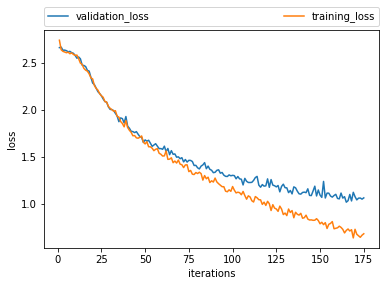

[2.6650219316835755,
 2.670744887104741,
 2.637095954683092,
 2.6386457990717003,
 2.6326551967196994,
 2.620666601039745,
 2.6253320464381464,
 2.6118458288687245,
 2.604708194732666,
 2.5819407215824834,
 2.552359554502699,
 2.5656990475124783,
 2.5458636107268156,
 2.4787882522300437,
 2.4750968173698142,
 2.46361102881255,
 2.423223195252595,
 2.4152479348359286,
 2.3487217691209583,
 2.2881837862509267,
 2.2717609758730286,
 2.2345686709439314,
 2.196831089478952,
 2.1774284309811063,
 2.1527129190939442,
 2.1194879390575267,
 2.091983918790464,
 2.084792145976314,
 2.035320529231319,
 2.008370143395883,
 2.0063698865749218,
 1.9954728329623188,
 1.9658682964466236,
 1.9377722210354276,
 1.8775263362460666,
 1.917656209733751,
 1.9100562201605902,
 1.8640330235163372,
 1.9324928831171106,
 1.8300375938415527,
 1.8081469624130815,
 1.7754681198685258,
 1.7722621670475713,
 1.7614030219890453,
 1.7719391231183652,
 1.744046652758563,
 1.718573601157577,
 1.7110110609619706,
 1.65714

In [42]:
train_save('both', 1, 2)

minibatch:49, epoch:1, iteration:49, training_error:2.716213598251343, validation_error:2.6198781772896096
Best loss improvement from inf to 2.6198781772896096 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.652606201171875, validation_error:2.6151907090787536
Best loss improvement from 2.6198781772896096 to 2.6151907090787536 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.6030855655670164, validation_error:2.600318767406322
Best loss improvement from 2.6151907090787536 to 2.600318767406322 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.6221884536743163, validation_error:2.6063344390304
minibatch:12, epoch:2, iteration:249, training_error:2.6007209491729735, validation_error:2.5967195917058876
Best loss improvement from 2.600318767406322 to 2.5967195917058876 in epoch 2
minibatch:62, epoch:2, iteration:299, training_error:2.5942245960235595, validation_error:2.591066431116175
Best loss improvement from 2.5967195917058876 to 2.591

minibatch:129, epoch:11, iteration:2499, training_error:1.6876711559295654, validation_error:1.6997474961810641
minibatch:179, epoch:11, iteration:2549, training_error:1.6848719310760498, validation_error:1.7231370917073003
minibatch:229, epoch:11, iteration:2599, training_error:1.7238183856010436, validation_error:1.6755660286656133
Best loss improvement from 1.690811554590861 to 1.6755660286656133 in epoch 11
minibatch:42, epoch:12, iteration:2649, training_error:1.6738878202438354, validation_error:1.6668839984469943
Best loss improvement from 1.6755660286656133 to 1.6668839984469943 in epoch 12
minibatch:92, epoch:12, iteration:2699, training_error:1.6354270553588868, validation_error:1.657585448688931
Best loss improvement from 1.6668839984469943 to 1.657585448688931 in epoch 12
minibatch:142, epoch:12, iteration:2749, training_error:1.63230051279068, validation_error:1.6554615806650232
Best loss improvement from 1.657585448688931 to 1.6554615806650232 in epoch 12
minibatch:192, e

minibatch:135, epoch:23, iteration:5349, training_error:1.1606820178031922, validation_error:1.2792196450410065
minibatch:185, epoch:23, iteration:5399, training_error:1.1057864105701447, validation_error:1.2740044902872156
minibatch:235, epoch:23, iteration:5449, training_error:1.1572486960887909, validation_error:1.2752053693488792
minibatch:48, epoch:24, iteration:5499, training_error:1.0787412130832672, validation_error:1.2635247906049092
Best loss improvement from 1.272986321537583 to 1.2635247906049092 in epoch 24
minibatch:98, epoch:24, iteration:5549, training_error:1.09037069439888, validation_error:1.2654301899450797
minibatch:148, epoch:24, iteration:5599, training_error:1.1399726963043213, validation_error:1.287448697619968
minibatch:198, epoch:24, iteration:5649, training_error:1.128293092250824, validation_error:1.2342119525980066
Best loss improvement from 1.2635247906049092 to 1.2342119525980066 in epoch 24
minibatch:11, epoch:25, iteration:5699, training_error:1.088323

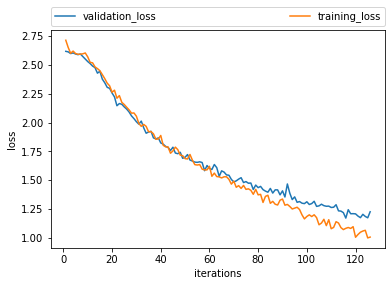

[2.6198781772896096,
 2.6151907090787536,
 2.600318767406322,
 2.6063344390304,
 2.5967195917058876,
 2.591066431116175,
 2.596843472233525,
 2.5744760036468506,
 2.5528066334901034,
 2.5312159767857305,
 2.513648615943061,
 2.491949302178842,
 2.478035158581204,
 2.4301959143744574,
 2.4469532790007413,
 2.378380439899586,
 2.34703931985078,
 2.3073665124398692,
 2.2983838143172086,
 2.2576881956171104,
 2.2240462877132274,
 2.1471329309322216,
 2.166386463023998,
 2.1600245149047286,
 2.137356612417433,
 2.118100978710033,
 2.0926613498617104,
 2.058814605077108,
 2.035163159723635,
 2.008439783696775,
 1.987563791098418,
 2.01374708281623,
 1.9553074836730957,
 1.908527378682737,
 1.919060919019911,
 1.9251298904418945,
 1.8680900026250769,
 1.858922212212174,
 1.867902610037062,
 1.8242705530590482,
 1.8135992597650599,
 1.7940537178957905,
 1.7851695352130466,
 1.758268329832289,
 1.7869847924621016,
 1.7363337145911322,
 1.7305182660067524,
 1.7427487638261583,
 1.690811554590861

In [43]:
train_save('both', 2, 2)

minibatch:49, epoch:1, iteration:49, training_error:2.7315949201583862, validation_error:2.6362141503228083
Best loss improvement from inf to 2.6362141503228083 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.643789758682251, validation_error:2.6216145621405706
Best loss improvement from 2.6362141503228083 to 2.6216145621405706 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.6392980718612673, validation_error:2.6291734995665372
minibatch:199, epoch:1, iteration:199, training_error:2.658333296775818, validation_error:2.6208386686113148
Best loss improvement from 2.6216145621405706 to 2.6208386686113148 in epoch 1
minibatch:8, epoch:2, iteration:249, training_error:2.6365875673294066, validation_error:2.6145193665115922
Best loss improvement from 2.6208386686113148 to 2.6145193665115922 in epoch 2
minibatch:58, epoch:2, iteration:299, training_error:2.6133209657669068, validation_error:2.6064820642824524
Best loss improvement from 2.6145193665115922 to

minibatch:89, epoch:11, iteration:2499, training_error:1.668160319328308, validation_error:1.6853158915484394
Best loss improvement from 1.6976247098710802 to 1.6853158915484394 in epoch 11
minibatch:139, epoch:11, iteration:2549, training_error:1.6755852890014649, validation_error:1.682326043093646
Best loss improvement from 1.6853158915484394 to 1.682326043093646 in epoch 11
minibatch:189, epoch:11, iteration:2599, training_error:1.7049493217468261, validation_error:1.6726565537629303
Best loss improvement from 1.682326043093646 to 1.6726565537629303 in epoch 11
minibatch:239, epoch:11, iteration:2649, training_error:1.7017544555664061, validation_error:1.622235726427149
Best loss improvement from 1.6726565537629303 to 1.622235726427149 in epoch 11
minibatch:48, epoch:12, iteration:2699, training_error:1.586975872516632, validation_error:1.6577022561320551
minibatch:98, epoch:12, iteration:2749, training_error:1.61708172082901, validation_error:1.61052139600118
Best loss improvement 

minibatch:147, epoch:23, iteration:5449, training_error:1.126645758152008, validation_error:1.267944547865126
Best loss improvement from 1.269309068167651 to 1.267944547865126 in epoch 23
minibatch:197, epoch:23, iteration:5499, training_error:1.1202602624893188, validation_error:1.2558298640780978
Best loss improvement from 1.267944547865126 to 1.2558298640780978 in epoch 23
minibatch:6, epoch:24, iteration:5549, training_error:1.0915829062461853, validation_error:1.2798475623130798
minibatch:56, epoch:24, iteration:5599, training_error:1.0862776005268098, validation_error:1.2711816054803353
minibatch:106, epoch:24, iteration:5649, training_error:1.0881175208091736, validation_error:1.317345552974277
minibatch:156, epoch:24, iteration:5699, training_error:1.0540435898303986, validation_error:1.2574657709510237
minibatch:206, epoch:24, iteration:5749, training_error:1.0583343231678009, validation_error:1.2560018014024805
minibatch:15, epoch:25, iteration:5799, training_error:1.06558929

minibatch:164, epoch:36, iteration:8599, training_error:0.7181102800369262, validation_error:1.14153254032135
minibatch:214, epoch:36, iteration:8649, training_error:0.7067622780799866, validation_error:1.1320920741116558
minibatch:23, epoch:37, iteration:8699, training_error:0.7090102308988571, validation_error:1.165468399171476
minibatch:73, epoch:37, iteration:8749, training_error:0.6664619886875153, validation_error:1.1554293477976765
minibatch:123, epoch:37, iteration:8799, training_error:0.6742541742324829, validation_error:1.0996808939509921
minibatch:173, epoch:37, iteration:8849, training_error:0.7022835409641266, validation_error:1.130781555617297
minibatch:223, epoch:37, iteration:8899, training_error:0.7238586163520813, validation_error:1.0621022582054138
Best loss improvement from 1.0873221821255155 to 1.0621022582054138 in epoch 37
minibatch:32, epoch:38, iteration:8949, training_error:0.6676774543523788, validation_error:1.158342683756793
minibatch:82, epoch:38, iteratio

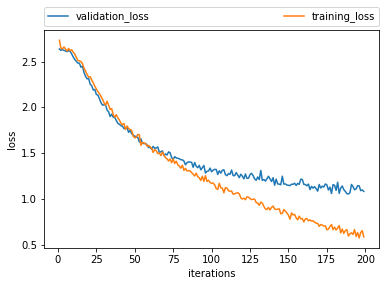

[2.6362141503228083,
 2.6216145621405706,
 2.6291734995665372,
 2.6208386686113148,
 2.6145193665115922,
 2.6064820642824524,
 2.617700108775386,
 2.6105184290144177,
 2.582269801033868,
 2.5483578046162925,
 2.522105746799045,
 2.5009888543023004,
 2.4826097223493786,
 2.481562164094713,
 2.4377114684493453,
 2.4493068589104547,
 2.3793110494260437,
 2.3380380471547446,
 2.3105847040812173,
 2.3165536721547446,
 2.252879434161716,
 2.235897978146871,
 2.1894749800364175,
 2.1956048320840904,
 2.140504656014619,
 2.13504836735902,
 2.0964067467936762,
 2.0523082150353327,
 2.02546610655608,
 2.0277832746505737,
 2.0271070180115878,
 1.9710229679390237,
 1.9521313066835757,
 1.9009687547330503,
 1.9267450129544292,
 1.8927245007620916,
 1.8885525950679072,
 1.8570553594165378,
 1.826796288843508,
 1.8162110602414165,
 1.8004489872190688,
 1.7959872572510331,
 1.767731538525334,
 1.7755582685823794,
 1.7795630737587258,
 1.7281410340909604,
 1.7503669217780784,
 1.712327484731321,
 1.697

In [44]:
train_save('both', 3, 2)

minibatch:49, epoch:1, iteration:49, training_error:2.740313115119934, validation_error:2.6549596052903395
Best loss improvement from inf to 2.6549596052903395 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.6237198877334595, validation_error:2.6340920466643114
Best loss improvement from 2.6549596052903395 to 2.6340920466643114 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:2.6354747724533083, validation_error:2.625279509104215
Best loss improvement from 2.6340920466643114 to 2.625279509104215 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:2.636370620727539, validation_error:2.623227724662194
Best loss improvement from 2.625279509104215 to 2.623227724662194 in epoch 1
minibatch:17, epoch:2, iteration:249, training_error:2.6276303243637087, validation_error:2.6157829211308408
Best loss improvement from 2.623227724662194 to 2.6157829211308408 in epoch 2
minibatch:67, epoch:2, iteration:299, training_error:2.6141667890548708, validation

minibatch:79, epoch:11, iteration:2399, training_error:1.6363381028175354, validation_error:1.5477164158454308
Best loss improvement from 1.5933655408712535 to 1.5477164158454308 in epoch 11
minibatch:129, epoch:11, iteration:2449, training_error:1.6550605964660645, validation_error:1.5410342491590059
Best loss improvement from 1.5477164158454308 to 1.5410342491590059 in epoch 11
minibatch:179, epoch:11, iteration:2499, training_error:1.5890267133712768, validation_error:1.5234639048576355
Best loss improvement from 1.5410342491590059 to 1.5234639048576355 in epoch 11
minibatch:229, epoch:11, iteration:2549, training_error:1.5851212644577026, validation_error:1.4846155964411223
Best loss improvement from 1.5234639048576355 to 1.4846155964411223 in epoch 11
minibatch:47, epoch:12, iteration:2599, training_error:1.5795506572723388, validation_error:1.5299722598149226
minibatch:97, epoch:12, iteration:2649, training_error:1.5452884006500245, validation_error:1.5176905806248004
minibatch:1

minibatch:95, epoch:23, iteration:5199, training_error:1.0677759337425232, validation_error:1.1365181161807134
minibatch:145, epoch:23, iteration:5249, training_error:1.0773067343235017, validation_error:1.097266366848579
Best loss improvement from 1.1354852754336138 to 1.097266366848579 in epoch 23
minibatch:195, epoch:23, iteration:5299, training_error:1.058701478242874, validation_error:1.0971464125009684
Best loss improvement from 1.097266366848579 to 1.0971464125009684 in epoch 23
minibatch:13, epoch:24, iteration:5349, training_error:1.0504802894592284, validation_error:1.0879723658928504
Best loss improvement from 1.0971464125009684 to 1.0879723658928504 in epoch 24
minibatch:63, epoch:24, iteration:5399, training_error:1.0506656754016876, validation_error:1.1351503064999213
minibatch:113, epoch:24, iteration:5449, training_error:1.0483165824413299, validation_error:1.095641484627357
minibatch:163, epoch:24, iteration:5499, training_error:1.0043272805213928, validation_error:1.1

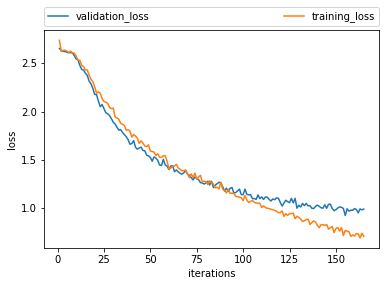

[2.6549596052903395,
 2.6340920466643114,
 2.625279509104215,
 2.623227724662194,
 2.6157829211308408,
 2.6110474513127255,
 2.611986435376681,
 2.608482140761155,
 2.5808690236164975,
 2.5461752231304464,
 2.5366649535986094,
 2.478665223488441,
 2.4391797139094424,
 2.4292480670488796,
 2.3994086522322435,
 2.3753208288779626,
 2.316515097251305,
 2.2881610164275537,
 2.2413618518755984,
 2.1776469624959507,
 2.1770354096706095,
 2.1082168359022875,
 2.0513268479934106,
 2.0725444005085873,
 2.030521878829369,
 1.988551181096297,
 1.9770085903314443,
 1.9586849900392385,
 1.9267392387756934,
 1.8905671605697045,
 1.8701408505439758,
 1.8388977784376879,
 1.8069905776243944,
 1.8125958305138807,
 1.7833226093879113,
 1.760719427695641,
 1.7389990137173579,
 1.7092651358017554,
 1.660725983289572,
 1.66809808749419,
 1.6987009736207814,
 1.6293061054669893,
 1.610267685009883,
 1.6215981932786794,
 1.6308435385043805,
 1.596225605561183,
 1.5933655408712535,
 1.5477164158454308,
 1.541

In [45]:
train_save('both', 4, 2)

minibatch:49, epoch:1, iteration:49, training_error:2.109775974750519, validation_error:2.018350986333994
Best loss improvement from inf to 2.018350986333994 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.017634456157684, validation_error:2.000747804458325
Best loss improvement from 2.018350986333994 to 2.000747804458325 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:1.9936006689071655, validation_error:1.9931309498273408
Best loss improvement from 2.000747804458325 to 1.9931309498273408 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:1.9800381422042848, validation_error:1.989324803535755
Best loss improvement from 1.9931309498273408 to 1.989324803535755 in epoch 1
minibatch:12, epoch:2, iteration:249, training_error:1.9940340447425842, validation_error:1.9801297462903535
Best loss improvement from 1.989324803535755 to 1.9801297462903535 in epoch 2
minibatch:62, epoch:2, iteration:299, training_error:1.9808418703079225, validation_er

minibatch:179, epoch:11, iteration:2549, training_error:1.0240502202510833, validation_error:1.2184367913466234
minibatch:229, epoch:11, iteration:2599, training_error:1.0261477506160737, validation_error:1.1831558461372669
Best loss improvement from 1.1840258263624632 to 1.1831558461372669 in epoch 11
minibatch:42, epoch:12, iteration:2649, training_error:0.984963926076889, validation_error:1.2305266902996943
minibatch:92, epoch:12, iteration:2699, training_error:0.9808814060688019, validation_error:1.1640860736370087
Best loss improvement from 1.1831558461372669 to 1.1640860736370087 in epoch 12
minibatch:142, epoch:12, iteration:2749, training_error:0.9454827952384949, validation_error:1.2004216748934526
minibatch:192, epoch:12, iteration:2799, training_error:0.9752813839912414, validation_error:1.148353397846222
Best loss improvement from 1.1640860736370087 to 1.148353397846222 in epoch 12
minibatch:5, epoch:13, iteration:2849, training_error:0.9282956790924072, validation_error:1.

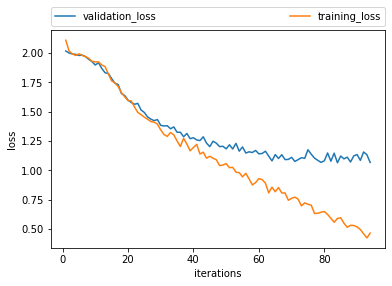

[2.018350986333994,
 2.000747804458325,
 1.9931309498273408,
 1.989324803535755,
 1.9801297462903535,
 1.9832408474041865,
 1.9703574180603027,
 1.9473858704933753,
 1.9275201971714313,
 1.8988582491874695,
 1.9176868475400484,
 1.8691546458464403,
 1.8327392156307514,
 1.8263216431324298,
 1.7834896261875446,
 1.7433334589004517,
 1.7324095643483675,
 1.6554773083099952,
 1.6386526547945464,
 1.5998759498962989,
 1.579055864077348,
 1.5640475841668935,
 1.5712445745101342,
 1.5151732151324933,
 1.4941202264565687,
 1.4558297120607817,
 1.4369550759975727,
 1.4247298011412988,
 1.4334272696421697,
 1.384333257491772,
 1.3786872121003957,
 1.3813405953920805,
 1.3550781194980328,
 1.3706854260884798,
 1.3252923992963939,
 1.325818923803476,
 1.287172216635484,
 1.3149756835057185,
 1.2707424026269178,
 1.278659490438608,
 1.260108152261147,
 1.2545724832094634,
 1.2866009496725523,
 1.2329341448270357,
 1.2028725032622998,
 1.249132981667152,
 1.232439513389881,
 1.2028076877960792,
 1.

In [46]:
train_save('age', 0, 0)

minibatch:49, epoch:1, iteration:49, training_error:2.0360025858879087, validation_error:1.9733518649791848
Best loss improvement from inf to 1.9733518649791848 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:1.94290855884552, validation_error:1.9723002376227543
Best loss improvement from 1.9733518649791848 to 1.9723002376227543 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:1.9529016590118409, validation_error:1.9504728687220607
Best loss improvement from 1.9723002376227543 to 1.9504728687220607 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:1.9216802430152893, validation_error:1.9767735333278262
minibatch:249, epoch:1, iteration:249, training_error:1.9291673827171325, validation_error:1.9394876340339924
Best loss improvement from 1.9504728687220607 to 1.9394876340339924 in epoch 1
minibatch:41, epoch:2, iteration:299, training_error:1.9133542060852051, validation_error:1.932146820528754
Best loss improvement from 1.9394876340339924 t

minibatch:227, epoch:10, iteration:2549, training_error:1.052353448867798, validation_error:1.105423341537344
Best loss improvement from 1.1404996596533676 to 1.105423341537344 in epoch 10
minibatch:19, epoch:11, iteration:2599, training_error:0.9720520007610322, validation_error:1.1283957999328087
minibatch:69, epoch:11, iteration:2649, training_error:0.9700352311134338, validation_error:1.0883935546052868
Best loss improvement from 1.105423341537344 to 1.0883935546052868 in epoch 11
minibatch:119, epoch:11, iteration:2699, training_error:0.9599818122386933, validation_error:1.113275593724744
minibatch:169, epoch:11, iteration:2749, training_error:0.9525132775306702, validation_error:1.1393497257397092
minibatch:219, epoch:11, iteration:2799, training_error:0.9751630198955535, validation_error:1.0755745008074005
Best loss improvement from 1.0883935546052868 to 1.0755745008074005 in epoch 11
minibatch:11, epoch:12, iteration:2849, training_error:0.8950818955898285, validation_error:1.0

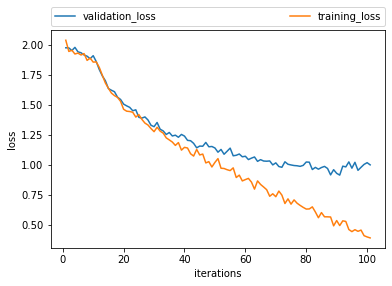

[1.9733518649791848,
 1.9723002376227543,
 1.9504728687220607,
 1.9767735333278262,
 1.9394876340339924,
 1.932146820528754,
 1.91348109163087,
 1.9033887016362157,
 1.8824379896295482,
 1.9075557363444362,
 1.8591550917461002,
 1.7927597308981007,
 1.7399342676688885,
 1.6997923152200107,
 1.634443209089082,
 1.6203854248441498,
 1.6080357822878608,
 1.5625952030050343,
 1.5436126774755017,
 1.5049158211412101,
 1.4906120135866363,
 1.4781600935705776,
 1.4500422148868954,
 1.4577950239181519,
 1.3952478293714852,
 1.3890377283096313,
 1.3985261382727787,
 1.373420970193271,
 1.3291705723466545,
 1.3175479029786998,
 1.3526684826818005,
 1.296362827564108,
 1.282332334025153,
 1.2528216037256965,
 1.269288708423746,
 1.2403852117472682,
 1.2468366294071591,
 1.2296139289592873,
 1.2531241507365787,
 1.2392448639047557,
 1.2038254326787488,
 1.2008905061360062,
 1.1789655048271706,
 1.1419885096878841,
 1.1563043964320217,
 1.154897611716698,
 1.1866572026548714,
 1.1504824963109246,
 

In [47]:
train_save('age', 1, 0)

minibatch:49, epoch:1, iteration:49, training_error:2.079377827644348, validation_error:1.9546593962044552
Best loss improvement from inf to 1.9546593962044552 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:1.9941649198532105, validation_error:1.96030304349702
minibatch:149, epoch:1, iteration:149, training_error:1.950143415927887, validation_error:1.939900094065173
Best loss improvement from 1.9546593962044552 to 1.939900094065173 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:1.9445032620429992, validation_error:1.9382531067420696
Best loss improvement from 1.939900094065173 to 1.9382531067420696 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:1.9580682301521302, validation_error:1.9312941822512397
Best loss improvement from 1.9382531067420696 to 1.9312941822512397 in epoch 1
minibatch:45, epoch:2, iteration:299, training_error:1.9316184210777283, validation_error:1.9199813193288342
Best loss improvement from 1.9312941822512397 to 1.

minibatch:9, epoch:11, iteration:2549, training_error:1.1225908720493316, validation_error:1.163690295712701
Best loss improvement from 1.1907268145988728 to 1.163690295712701 in epoch 11
minibatch:59, epoch:11, iteration:2599, training_error:1.1048737716674806, validation_error:1.1541867338377854
Best loss improvement from 1.163690295712701 to 1.1541867338377854 in epoch 11
minibatch:109, epoch:11, iteration:2649, training_error:1.0650108909606935, validation_error:1.1509394625137592
Best loss improvement from 1.1541867338377854 to 1.1509394625137592 in epoch 11
minibatch:159, epoch:11, iteration:2699, training_error:1.0709005868434907, validation_error:1.1439122454873447
Best loss improvement from 1.1509394625137592 to 1.1439122454873447 in epoch 11
minibatch:209, epoch:11, iteration:2749, training_error:1.0297650301456451, validation_error:1.108480876889722
Best loss improvement from 1.1439122454873447 to 1.108480876889722 in epoch 11
minibatch:5, epoch:12, iteration:2799, training_

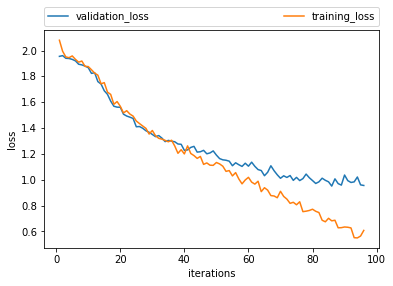

[1.9546593962044552,
 1.96030304349702,
 1.939900094065173,
 1.9382531067420696,
 1.9312941822512397,
 1.9199813193288342,
 1.893922312506314,
 1.8887100548579776,
 1.8794189650436928,
 1.8672012542856151,
 1.8230183700035358,
 1.8279933066203677,
 1.7594782812842007,
 1.7402937001195447,
 1.6885113716125488,
 1.660929692202601,
 1.608484518939051,
 1.56877496735803,
 1.5617947619536827,
 1.5610660067920028,
 1.50720424487673,
 1.4929672644056122,
 1.4841966300175107,
 1.4742588010327569,
 1.4100049323049084,
 1.4117775497765377,
 1.3984682477753738,
 1.3791135672865242,
 1.3674173026249326,
 1.3505632425176686,
 1.3334412492554764,
 1.3420250580228608,
 1.3221204116426666,
 1.2951285510227597,
 1.30450688148367,
 1.2985352236649086,
 1.2939500356542653,
 1.276789767988797,
 1.2743380480799182,
 1.2274469692131569,
 1.2308009246300007,
 1.2502130064471015,
 1.258323463900336,
 1.2138810794928978,
 1.2167522044017398,
 1.2274727163643673,
 1.2008567411324074,
 1.2074773722681507,
 1.223

In [48]:
train_save('age', 2, 0)

minibatch:49, epoch:1, iteration:49, training_error:2.0607045793533327, validation_error:1.9757352431615194
Best loss improvement from inf to 1.9757352431615194 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:1.9685325646400451, validation_error:1.96828959385554
Best loss improvement from 1.9757352431615194 to 1.96828959385554 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:1.9678521656990051, validation_error:1.9475596388181051
Best loss improvement from 1.96828959385554 to 1.9475596388181051 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:1.9619047951698303, validation_error:1.9474891901016236
Best loss improvement from 1.9475596388181051 to 1.9474891901016236 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:1.940265851020813, validation_error:1.9419105092684428
Best loss improvement from 1.9474891901016236 to 1.9419105092684428 in epoch 1
minibatch:39, epoch:2, iteration:299, training_error:1.9572302937507629, validati

minibatch:259, epoch:10, iteration:2599, training_error:1.044886884689331, validation_error:1.117154069741567
Best loss improvement from 1.1538576265176137 to 1.117154069741567 in epoch 10
minibatch:49, epoch:11, iteration:2649, training_error:0.9821074628829956, validation_error:1.1577048500378926
minibatch:99, epoch:11, iteration:2699, training_error:1.0065705406665801, validation_error:1.1159163773059846
Best loss improvement from 1.117154069741567 to 1.1159163773059846 in epoch 11
minibatch:149, epoch:11, iteration:2749, training_error:0.9895513784885407, validation_error:1.1568108340104422
minibatch:199, epoch:11, iteration:2799, training_error:0.9962087035179138, validation_error:1.1120865960915884
Best loss improvement from 1.1159163773059846 to 1.1120865960915884 in epoch 11
minibatch:249, epoch:11, iteration:2849, training_error:0.9723294043540954, validation_error:1.1026780625184378
Best loss improvement from 1.1120865960915884 to 1.1026780625184378 in epoch 11
minibatch:39, 

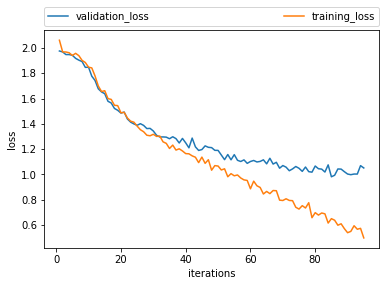

[1.9757352431615194,
 1.96828959385554,
 1.9475596388181051,
 1.9474891901016236,
 1.9419105092684428,
 1.917697544892629,
 1.9034571568171184,
 1.8922033905982971,
 1.8464741150538126,
 1.847352969646454,
 1.776445746421814,
 1.7428969264030456,
 1.6771437764167785,
 1.652462911605835,
 1.638095533847809,
 1.578312353293101,
 1.5646981159845987,
 1.521849771340688,
 1.507248294353485,
 1.4851447145144145,
 1.493205233414968,
 1.4385554790496826,
 1.4135687351226807,
 1.399534567197164,
 1.388784078756968,
 1.4013622800509136,
 1.3879086176554363,
 1.362778115272522,
 1.3642738382021586,
 1.3436203479766846,
 1.309805186589559,
 1.2961678624153137,
 1.2967129151026409,
 1.2951341311136881,
 1.2824908832708994,
 1.298128648598989,
 1.2833238979180654,
 1.2489446600278218,
 1.2848625540733338,
 1.2499894976615906,
 1.2106842358907064,
 1.2877213637034097,
 1.2183429598808289,
 1.1899290800094604,
 1.1969183703263602,
 1.2260846575101216,
 1.2146534939606985,
 1.2122811535994211,
 1.19090

In [49]:
train_save('age', 3, 0)

minibatch:49, epoch:1, iteration:49, training_error:2.046878247261047, validation_error:1.9810441391808646
Best loss improvement from inf to 1.9810441391808646 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:1.9641077160835265, validation_error:1.9557482089315141
Best loss improvement from 1.9810441391808646 to 1.9557482089315141 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:1.9462743997573853, validation_error:1.9450377864497048
Best loss improvement from 1.9557482089315141 to 1.9450377864497048 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:1.9456566429138185, validation_error:1.957899387393679
minibatch:1, epoch:2, iteration:249, training_error:1.9657994532585144, validation_error:1.964031615427562
minibatch:51, epoch:2, iteration:299, training_error:1.9380931949615479, validation_error:1.9412288240024023
Best loss improvement from 1.9450377864497048 to 1.9412288240024023 in epoch 2
minibatch:101, epoch:2, iteration:349, training_e

minibatch:219, epoch:11, iteration:2699, training_error:0.9949175977706909, validation_error:1.0288191246134895
minibatch:21, epoch:12, iteration:2749, training_error:0.9489117646217347, validation_error:1.0130040347576141
Best loss improvement from 1.0274730899504252 to 1.0130040347576141 in epoch 12
minibatch:71, epoch:12, iteration:2799, training_error:0.8746693503856658, validation_error:1.0293190500565939
minibatch:121, epoch:12, iteration:2849, training_error:0.92985555768013, validation_error:1.0383508588586534
minibatch:171, epoch:12, iteration:2899, training_error:0.898075921535492, validation_error:0.9995802449328559
Best loss improvement from 1.0130040347576141 to 0.9995802449328559 in epoch 12
minibatch:221, epoch:12, iteration:2949, training_error:0.9027401554584503, validation_error:1.0004893690347672
minibatch:23, epoch:13, iteration:2999, training_error:0.8491014814376832, validation_error:0.9993700385093689
Best loss improvement from 0.9995802449328559 to 0.99937003850

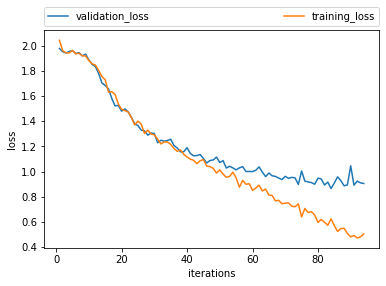

[1.9810441391808646,
 1.9557482089315141,
 1.9450377864497048,
 1.957899387393679,
 1.964031615427562,
 1.9412288240024023,
 1.9477715705122267,
 1.9224379658699036,
 1.9360536251749312,
 1.8897153522287096,
 1.8543929542813982,
 1.836747727223805,
 1.7804850552763258,
 1.7061560835157121,
 1.685499859707696,
 1.6584833136626653,
 1.583168387413025,
 1.5234619336468833,
 1.527309272970472,
 1.4810022243431635,
 1.4993097952433996,
 1.4760333853108543,
 1.4314389441694533,
 1.3807997107505798,
 1.366592858518873,
 1.3300746168409074,
 1.3249950749533517,
 1.2900065311363764,
 1.306572390454156,
 1.303170076438359,
 1.2293648421764374,
 1.249187558889389,
 1.2419260229383196,
 1.2475402333906718,
 1.2576337328978948,
 1.207402195249285,
 1.1872203456504005,
 1.1565050035715103,
 1.1574176443474633,
 1.1900663950613566,
 1.1431901880672999,
 1.1252079967941557,
 1.127136258142335,
 1.1354907218899046,
 1.1045528118099486,
 1.0681341205324446,
 1.0875428446701594,
 1.0924167058297567,
 1.1

In [50]:
train_save('age', 4, 0)

minibatch:49, epoch:1, iteration:49, training_error:2.1104806566238405, validation_error:2.006236035090226
Best loss improvement from inf to 2.006236035090226 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:2.02208669424057, validation_error:2.002858565403865
Best loss improvement from 2.006236035090226 to 2.002858565403865 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:1.9869174766540527, validation_error:2.0117337566155653
minibatch:199, epoch:1, iteration:199, training_error:2.007507612705231, validation_error:1.9994126237355745
Best loss improvement from 2.002858565403865 to 1.9994126237355745 in epoch 1
minibatch:12, epoch:2, iteration:249, training_error:1.9718031406402587, validation_error:1.9867959939516509
Best loss improvement from 1.9994126237355745 to 1.9867959939516509 in epoch 2
minibatch:62, epoch:2, iteration:299, training_error:1.98758291721344, validation_error:1.9899502534132738
minibatch:112, epoch:2, iteration:349, training_error:1.

minibatch:179, epoch:11, iteration:2549, training_error:1.1951112675666808, validation_error:1.2568216644800627
minibatch:229, epoch:11, iteration:2599, training_error:1.1426875007152557, validation_error:1.255482792854309
minibatch:42, epoch:12, iteration:2649, training_error:1.1255725264549254, validation_error:1.2243426946493297
Best loss improvement from 1.2317995795836816 to 1.2243426946493297 in epoch 12
minibatch:92, epoch:12, iteration:2699, training_error:1.137526216506958, validation_error:1.2195702584890218
Best loss improvement from 1.2243426946493297 to 1.2195702584890218 in epoch 12
minibatch:142, epoch:12, iteration:2749, training_error:1.1147659051418304, validation_error:1.225523327405636
minibatch:192, epoch:12, iteration:2799, training_error:1.1221996796131135, validation_error:1.2360044809488149
minibatch:5, epoch:13, iteration:2849, training_error:1.097938266992569, validation_error:1.2016792664161096
Best loss improvement from 1.2195702584890218 to 1.2016792664161

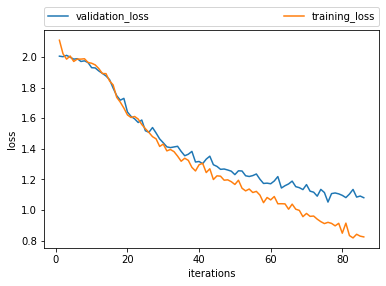

[2.006236035090226,
 2.002858565403865,
 2.0117337566155653,
 1.9994126237355745,
 1.9867959939516509,
 1.9899502534132738,
 1.971664662544544,
 1.9758726954460144,
 1.9642394047517042,
 1.9311333803030162,
 1.9293817694370563,
 1.9096366533866296,
 1.893934442446782,
 1.8769609744732196,
 1.8529543968347402,
 1.797863712677589,
 1.7480297363721407,
 1.7185826805921702,
 1.7304531794327955,
 1.6411634683609009,
 1.6127205857863793,
 1.596461520745204,
 1.572660547036391,
 1.5888657248937166,
 1.518589890920199,
 1.508879487331097,
 1.5396835620586689,
 1.5038070816260118,
 1.4650554381884062,
 1.4400703998712392,
 1.4133675602766185,
 1.4084625198290899,
 1.4127884965676527,
 1.4170875641015859,
 1.3834966375277593,
 1.3552163610091577,
 1.3652154161379888,
 1.3836834338995128,
 1.3143407839995165,
 1.317695608505836,
 1.3033965688485365,
 1.3330612228466914,
 1.3523746820596547,
 1.2965516585570116,
 1.2855126399260302,
 1.2663537126321058,
 1.2685516476631165,
 1.2620475888252258,
 1

In [51]:
train_save('age', 0, 1)

minibatch:49, epoch:1, iteration:49, training_error:2.03487473487854, validation_error:1.9756901757470493
Best loss improvement from inf to 1.9756901757470493 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:1.9533260488510131, validation_error:1.9738999194112317
Best loss improvement from 1.9756901757470493 to 1.9738999194112317 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:1.9621594667434692, validation_error:1.9583821420011849
Best loss improvement from 1.9738999194112317 to 1.9583821420011849 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:1.9176417016983032, validation_error:1.951029526776281
Best loss improvement from 1.9583821420011849 to 1.951029526776281 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:1.9336999917030335, validation_error:1.944294210137992
Best loss improvement from 1.951029526776281 to 1.944294210137992 in epoch 1
minibatch:41, epoch:2, iteration:299, training_error:1.9285354042053222, validati

minibatch:227, epoch:10, iteration:2549, training_error:1.0858537483215331, validation_error:1.1362384516617348
Best loss improvement from 1.1597970580232555 to 1.1362384516617348 in epoch 10
minibatch:19, epoch:11, iteration:2599, training_error:1.1094788360595702, validation_error:1.1536438485671734
minibatch:69, epoch:11, iteration:2649, training_error:1.0620425283908843, validation_error:1.1506141526945706
minibatch:119, epoch:11, iteration:2699, training_error:1.064447135925293, validation_error:1.1278020883428639
Best loss improvement from 1.1362384516617348 to 1.1278020883428639 in epoch 11
minibatch:169, epoch:11, iteration:2749, training_error:1.0704396271705627, validation_error:1.1271621934298812
Best loss improvement from 1.1278020883428639 to 1.1271621934298812 in epoch 11
minibatch:219, epoch:11, iteration:2799, training_error:1.0494851136207581, validation_error:1.1096362759327065
Best loss improvement from 1.1271621934298812 to 1.1096362759327065 in epoch 11
minibatch:1

minibatch:31, epoch:22, iteration:5449, training_error:0.6263816440105439, validation_error:0.9439071540174813
minibatch:81, epoch:22, iteration:5499, training_error:0.6534405362606048, validation_error:0.8925235435880464
Best loss improvement from 0.8992656243258509 to 0.8925235435880464 in epoch 22
minibatch:131, epoch:22, iteration:5549, training_error:0.6104821771383285, validation_error:0.8874995872892183
Best loss improvement from 0.8925235435880464 to 0.8874995872892183 in epoch 22
minibatch:181, epoch:22, iteration:5599, training_error:0.62826740026474, validation_error:0.9254114052345013
minibatch:231, epoch:22, iteration:5649, training_error:0.6004266995191574, validation_error:0.8899752292139776
minibatch:23, epoch:23, iteration:5699, training_error:0.6228154730796814, validation_error:0.9025903344154358
minibatch:73, epoch:23, iteration:5749, training_error:0.5926027309894562, validation_error:0.9321854566705639
minibatch:123, epoch:23, iteration:5799, training_error:0.6331

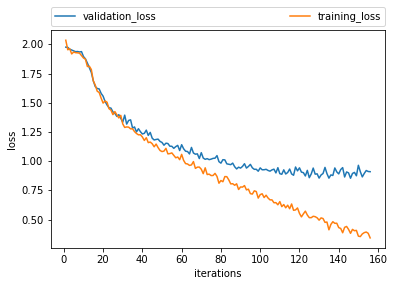

[1.9756901757470493,
 1.9738999194112317,
 1.9583821420011849,
 1.951029526776281,
 1.944294210137992,
 1.9367236556677982,
 1.9384216892308201,
 1.93438183439189,
 1.937398598111909,
 1.8953049223998497,
 1.8756334863860031,
 1.8394700617625797,
 1.7993407331663986,
 1.759415367553974,
 1.6883101627744477,
 1.6383896572836514,
 1.6219071355359307,
 1.6181153428965602,
 1.5796710992681569,
 1.5561073196345363,
 1.5110337199835941,
 1.480668335125364,
 1.4571146718386947,
 1.453909446453226,
 1.4219370628225392,
 1.408812062493686,
 1.3830711841583252,
 1.3977984025560577,
 1.3671284996230026,
 1.3338692619882782,
 1.393743804816542,
 1.3171767160810273,
 1.3481924657163948,
 1.3535125707757885,
 1.282874555423342,
 1.2926051822201958,
 1.2499898302144017,
 1.2775312621017982,
 1.2520472633427586,
 1.2325842133883773,
 1.2378472110320782,
 1.2653343266454236,
 1.2201657130800445,
 1.2459409689081127,
 1.1965091927298184,
 1.1809325649820526,
 1.1855341874319931,
 1.1884201333440583,
 1.

In [52]:
train_save('age', 1, 1)

minibatch:49, epoch:1, iteration:49, training_error:2.0597842049598696, validation_error:1.957345407584618
Best loss improvement from inf to 1.957345407584618 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:1.983228018283844, validation_error:1.9509152379529229
Best loss improvement from 1.957345407584618 to 1.9509152379529229 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:1.9615221071243285, validation_error:1.9416605357466072
Best loss improvement from 1.9509152379529229 to 1.9416605357466072 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:1.9424955224990845, validation_error:1.933899501274372
Best loss improvement from 1.9416605357466072 to 1.933899501274372 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:1.9480749559402466, validation_error:1.9359816764963085
minibatch:45, epoch:2, iteration:299, training_error:1.920283019542694, validation_error:1.9052107991843388
Best loss improvement from 1.933899501274372 to 1.9

minibatch:9, epoch:11, iteration:2549, training_error:1.1182556498050689, validation_error:1.178884637766871
minibatch:59, epoch:11, iteration:2599, training_error:1.1390076804161071, validation_error:1.137413594229468
Best loss improvement from 1.1555601276200393 to 1.137413594229468 in epoch 11
minibatch:109, epoch:11, iteration:2649, training_error:1.1102560782432556, validation_error:1.1634444409403308
minibatch:159, epoch:11, iteration:2699, training_error:1.1301562082767487, validation_error:1.1391624972738068
minibatch:209, epoch:11, iteration:2749, training_error:1.0792497611045837, validation_error:1.1306493857811237
Best loss improvement from 1.137413594229468 to 1.1306493857811237 in epoch 11
minibatch:5, epoch:12, iteration:2799, training_error:1.0936054003238678, validation_error:1.1373029207361156
minibatch:55, epoch:12, iteration:2849, training_error:1.0752452433109283, validation_error:1.132943034172058
minibatch:105, epoch:12, iteration:2899, training_error:1.052909718

minibatch:11, epoch:23, iteration:5599, training_error:0.6765131556987762, validation_error:0.9031880456825783
Patience ran out at 5599. Ending training


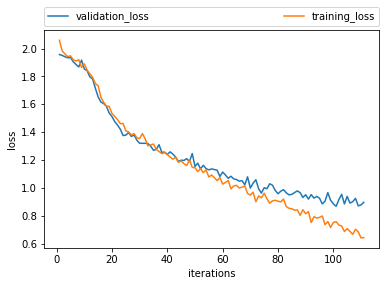

[1.957345407584618,
 1.9509152379529229,
 1.9416605357466072,
 1.933899501274372,
 1.9359816764963085,
 1.9052107991843388,
 1.8860273361206055,
 1.8683940624368602,
 1.9173525325183212,
 1.853742188420789,
 1.8413003641983559,
 1.797354085692044,
 1.7818122403375034,
 1.7151564359664917,
 1.6531595854923642,
 1.6166608251374344,
 1.605813404609417,
 1.5860000766556839,
 1.5372528084393204,
 1.5126205353901303,
 1.476346205020773,
 1.4514177297723705,
 1.4221223962718044,
 1.3764709686410839,
 1.3795328633538608,
 1.3981095840191018,
 1.3698609615194386,
 1.380276581336712,
 1.3428230367857834,
 1.3213325821120163,
 1.3209270321089646,
 1.320963925328748,
 1.3190410466029727,
 1.3001995168883225,
 1.271001782910577,
 1.2772564805787185,
 1.311081808188866,
 1.2563353530291854,
 1.2577645162056232,
 1.24127315241715,
 1.259742523061818,
 1.2438960774191494,
 1.2223164521414658,
 1.1912574685853103,
 1.19989602730192,
 1.1980796887956817,
 1.2109587459728635,
 1.1892344376136517,
 1.2475

In [53]:
train_save('age', 2, 1)

minibatch:49, epoch:1, iteration:49, training_error:2.069873659610748, validation_error:1.9785297155380248
Best loss improvement from inf to 1.9785297155380248 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:1.9670282816886902, validation_error:1.9452749371528626
Best loss improvement from 1.9785297155380248 to 1.9452749371528626 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:1.943291687965393, validation_error:1.9328816215197244
Best loss improvement from 1.9452749371528626 to 1.9328816215197244 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:1.971643524169922, validation_error:1.9451995770136514
minibatch:249, epoch:1, iteration:249, training_error:1.9435486364364625, validation_error:1.9569201191266379
minibatch:39, epoch:2, iteration:299, training_error:1.9491348552703858, validation_error:1.9090969443321228
Best loss improvement from 1.9328816215197244 to 1.9090969443321228 in epoch 2
minibatch:89, epoch:2, iteration:349, training_

minibatch:209, epoch:10, iteration:2549, training_error:1.102984277009964, validation_error:1.166305003563563
Best loss improvement from 1.1686670382817586 to 1.166305003563563 in epoch 10
minibatch:259, epoch:10, iteration:2599, training_error:1.0722950315475464, validation_error:1.1897957623004913
minibatch:49, epoch:11, iteration:2649, training_error:1.0834118616580963, validation_error:1.182699324687322
minibatch:99, epoch:11, iteration:2699, training_error:1.107324357032776, validation_error:1.150161204735438
Best loss improvement from 1.166305003563563 to 1.150161204735438 in epoch 11
minibatch:149, epoch:11, iteration:2749, training_error:1.0910128092765807, validation_error:1.1265767713387806
Best loss improvement from 1.150161204735438 to 1.1265767713387806 in epoch 11
minibatch:199, epoch:11, iteration:2799, training_error:1.0467823898792268, validation_error:1.1442323128382366
minibatch:249, epoch:11, iteration:2849, training_error:1.0254788935184478, validation_error:1.1455

minibatch:189, epoch:22, iteration:5649, training_error:0.6647391831874847, validation_error:0.9068182726701101
minibatch:239, epoch:22, iteration:5699, training_error:0.6199701631069183, validation_error:0.9643974145253499
minibatch:29, epoch:23, iteration:5749, training_error:0.6021535682678223, validation_error:0.9195958187182744
minibatch:79, epoch:23, iteration:5799, training_error:0.5784838974475861, validation_error:0.900845475991567
Best loss improvement from 0.9031207551558812 to 0.900845475991567 in epoch 23
minibatch:129, epoch:23, iteration:5849, training_error:0.5800524550676346, validation_error:0.9744783322016398
minibatch:179, epoch:23, iteration:5899, training_error:0.5745192456245423, validation_error:0.9049023926258087
minibatch:229, epoch:23, iteration:5949, training_error:0.6059726798534393, validation_error:0.8913034796714783
Best loss improvement from 0.900845475991567 to 0.8913034796714783 in epoch 23
minibatch:19, epoch:24, iteration:5999, training_error:0.5979

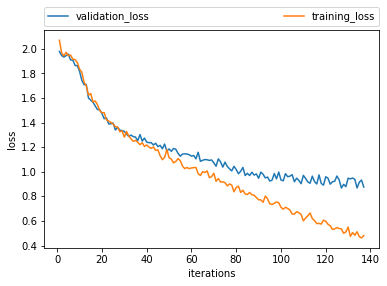

[1.9785297155380248,
 1.9452749371528626,
 1.9328816215197244,
 1.9451995770136514,
 1.9569201191266379,
 1.9090969443321228,
 1.907974406083425,
 1.8646568735440572,
 1.863471511999766,
 1.8169166286786398,
 1.7444507439931234,
 1.7080794334411622,
 1.7100425322850545,
 1.5989625930786133,
 1.5825328429539998,
 1.5663206537564596,
 1.5349406083424886,
 1.5062736908594767,
 1.503867216904958,
 1.4738171100616455,
 1.4312867323557537,
 1.439363185564677,
 1.3896417021751404,
 1.390040636062622,
 1.3963629682858785,
 1.3395175655682883,
 1.3620745301246644,
 1.338759966691335,
 1.3348282376925151,
 1.3285157561302186,
 1.3059954682985941,
 1.2877619981765747,
 1.2983687361081442,
 1.2858008960882823,
 1.2820974747339884,
 1.2524917721748352,
 1.3027079820632934,
 1.2494495709737141,
 1.2740572492281597,
 1.2418687840302784,
 1.236324135462443,
 1.2372310618559519,
 1.2182035783926646,
 1.2317964216073354,
 1.2047003547350565,
 1.2143730560938517,
 1.187133397658666,
 1.2255007147789,
 1.

In [54]:
train_save('age', 3, 1)

minibatch:49, epoch:1, iteration:49, training_error:2.059255473613739, validation_error:1.96853848866054
Best loss improvement from inf to 1.96853848866054 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:1.9665499353408813, validation_error:2.0076035474027907
minibatch:149, epoch:1, iteration:149, training_error:1.9783455085754396, validation_error:1.9589058203356606
Best loss improvement from 1.96853848866054 to 1.9589058203356606 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:1.9413007044792174, validation_error:1.95283300110272
Best loss improvement from 1.9589058203356606 to 1.95283300110272 in epoch 1
minibatch:1, epoch:2, iteration:249, training_error:1.9487939143180848, validation_error:1.9392436572483607
Best loss improvement from 1.95283300110272 to 1.9392436572483607 in epoch 2
minibatch:51, epoch:2, iteration:299, training_error:1.9378883504867555, validation_error:1.9387344036783491
Best loss improvement from 1.9392436572483607 to 1.93873440

minibatch:69, epoch:11, iteration:2549, training_error:1.0570926940441132, validation_error:1.1164583840540476
Best loss improvement from 1.1270529670374734 to 1.1164583840540476 in epoch 11
minibatch:119, epoch:11, iteration:2599, training_error:1.0655481958389281, validation_error:1.1169320898396629
minibatch:169, epoch:11, iteration:2649, training_error:1.0860208427906037, validation_error:1.1033058485814504
Best loss improvement from 1.1164583840540476 to 1.1033058485814504 in epoch 11
minibatch:219, epoch:11, iteration:2699, training_error:1.055983145236969, validation_error:1.1179263847214835
minibatch:21, epoch:12, iteration:2749, training_error:1.0566219508647918, validation_error:1.1054715258734567
minibatch:71, epoch:12, iteration:2799, training_error:1.0694768607616425, validation_error:1.1293860141720091
minibatch:121, epoch:12, iteration:2849, training_error:1.057824491262436, validation_error:1.0725214715514864
Best loss improvement from 1.1033058485814504 to 1.0725214715

minibatch:143, epoch:23, iteration:5599, training_error:0.6246667861938476, validation_error:0.8891176347221647
minibatch:193, epoch:23, iteration:5649, training_error:0.6117631846666336, validation_error:0.9245245116097587
minibatch:243, epoch:23, iteration:5699, training_error:0.6052607375383378, validation_error:0.8366800546646118
Best loss improvement from 0.8515113656009946 to 0.8366800546646118 in epoch 23
minibatch:45, epoch:24, iteration:5749, training_error:0.5983810251951218, validation_error:0.8642307775361198
minibatch:95, epoch:24, iteration:5799, training_error:0.6028219813108444, validation_error:0.836948821587222
minibatch:145, epoch:24, iteration:5849, training_error:0.5821092635393142, validation_error:0.8672426789999008
minibatch:195, epoch:24, iteration:5899, training_error:0.5675380337238312, validation_error:0.8357326260634831
Best loss improvement from 0.8366800546646118 to 0.8357326260634831 in epoch 24
minibatch:245, epoch:24, iteration:5949, training_error:0.5

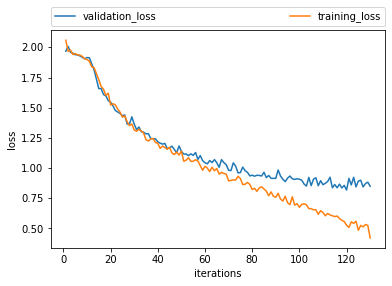

[1.96853848866054,
 2.0076035474027907,
 1.9589058203356606,
 1.95283300110272,
 1.9392436572483607,
 1.9387344036783491,
 1.9290460433278764,
 1.9178958705493383,
 1.9054674676486425,
 1.9158409493310111,
 1.9139920898846217,
 1.8622877555234092,
 1.8126759954861231,
 1.7344063988753728,
 1.6584680421011788,
 1.6588178064141954,
 1.6089718725000108,
 1.5982733922345298,
 1.5582256700311388,
 1.5465626631464278,
 1.515244769198554,
 1.4776936982359206,
 1.465315350464412,
 1.4522441795894079,
 1.4336576419217246,
 1.4403861888817378,
 1.364757967846734,
 1.3663632358823503,
 1.424922070332936,
 1.3636534810066223,
 1.3189781861645835,
 1.3405920607703072,
 1.301492303609848,
 1.2971637163843428,
 1.2829554889883314,
 1.2856877893209457,
 1.2449114876134055,
 1.243616372346878,
 1.2426255962678365,
 1.217617011495999,
 1.2066837570496969,
 1.1989097595214844,
 1.2042412289551325,
 1.1607985006911414,
 1.1680680683680944,
 1.1817382041897093,
 1.1546220247234618,
 1.1270529670374734,
 1.

In [55]:
train_save('age', 4, 1)

minibatch:49, epoch:1, iteration:49, training_error:2.104935655593872, validation_error:2.006244673178746
Best loss improvement from inf to 2.006244673178746 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:1.9942606282234192, validation_error:2.0245792132157545
minibatch:149, epoch:1, iteration:149, training_error:1.9853391528129578, validation_error:1.9825186408483064
Best loss improvement from 2.006244673178746 to 1.9825186408483064 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:1.9870461797714234, validation_error:1.9928469612048223
minibatch:12, epoch:2, iteration:249, training_error:1.9834059119224547, validation_error:1.9745180836090674
Best loss improvement from 1.9825186408483064 to 1.9745180836090674 in epoch 2
minibatch:62, epoch:2, iteration:299, training_error:1.9796945881843566, validation_error:1.9866310954093933
minibatch:112, epoch:2, iteration:349, training_error:1.97631334066391, validation_error:1.9799653887748718
minibatch:162, epoch

minibatch:179, epoch:11, iteration:2549, training_error:1.2220349085330964, validation_error:1.2827378098781292
minibatch:229, epoch:11, iteration:2599, training_error:1.2239853620529175, validation_error:1.285662123790154
minibatch:42, epoch:12, iteration:2649, training_error:1.2406523942947387, validation_error:1.3182639938134413
minibatch:92, epoch:12, iteration:2699, training_error:1.2096478009223939, validation_error:1.269148615690378
Best loss improvement from 1.2776162440960224 to 1.269148615690378 in epoch 12
minibatch:142, epoch:12, iteration:2749, training_error:1.1476269710063933, validation_error:1.2630800444346209
Best loss improvement from 1.269148615690378 to 1.2630800444346209 in epoch 12
minibatch:192, epoch:12, iteration:2799, training_error:1.2040420591831207, validation_error:1.2313854694366455
Best loss improvement from 1.2630800444346209 to 1.2313854694366455 in epoch 12
minibatch:5, epoch:13, iteration:2849, training_error:1.1947850036621093, validation_error:1.2

minibatch:148, epoch:24, iteration:5599, training_error:0.7605148804187775, validation_error:0.9440811826632574
Best loss improvement from 0.9582563615762271 to 0.9440811826632574 in epoch 24
minibatch:198, epoch:24, iteration:5649, training_error:0.7716389745473862, validation_error:1.0150903257039876
minibatch:11, epoch:25, iteration:5699, training_error:0.83013228058815, validation_error:0.9876661805006174
minibatch:61, epoch:25, iteration:5749, training_error:0.7812596952915192, validation_error:0.9858468908530015
minibatch:111, epoch:25, iteration:5799, training_error:0.7457274204492569, validation_error:0.9717744543002202
minibatch:161, epoch:25, iteration:5849, training_error:0.7858763098716736, validation_error:0.9750400506533109
minibatch:211, epoch:25, iteration:5899, training_error:0.7505885678529739, validation_error:0.9404655694961548
Best loss improvement from 0.9440811826632574 to 0.9404655694961548 in epoch 25
minibatch:24, epoch:26, iteration:5949, training_error:0.722

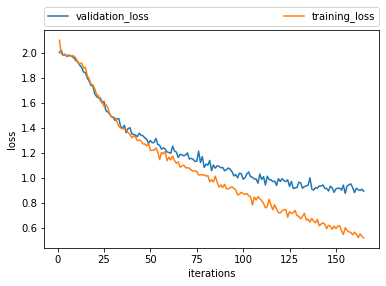

[2.006244673178746,
 2.0245792132157545,
 1.9825186408483064,
 1.9928469612048223,
 1.9745180836090674,
 1.9866310954093933,
 1.9799653887748718,
 1.972838933651264,
 1.9603440257219167,
 1.9386930328149061,
 1.9319265759908235,
 1.9033017983803382,
 1.8869800521777227,
 1.8492365341920118,
 1.845670603788816,
 1.8020257583031287,
 1.7785634856957655,
 1.7423793123318598,
 1.7415326145979075,
 1.6764185749567473,
 1.654662379851708,
 1.6417444531734173,
 1.643003184061784,
 1.6017423501381507,
 1.6149214872947106,
 1.540974653684176,
 1.530895077265226,
 1.51704413157243,
 1.492006045121413,
 1.4842288356560926,
 1.460989080942594,
 1.4742937959157503,
 1.4769245707071745,
 1.4126032224068275,
 1.3994698432775645,
 1.422935284101046,
 1.3641891479492188,
 1.3967850024883564,
 1.4035144035632794,
 1.3543997498658986,
 1.3491098376420827,
 1.3439510006171007,
 1.3316883811583886,
 1.3595005640616784,
 1.3428466090789208,
 1.3390416044455309,
 1.3213957502291753,
 1.31216698884964,
 1.277

In [56]:
train_save('age', 0, 2)

minibatch:49, epoch:1, iteration:49, training_error:2.042874963283539, validation_error:1.9682944478659794
Best loss improvement from inf to 1.9682944478659794 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:1.9683324909210205, validation_error:1.9679175574204018
Best loss improvement from 1.9682944478659794 to 1.9679175574204018 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:1.9108243775367737, validation_error:1.9572791765476096
Best loss improvement from 1.9679175574204018 to 1.9572791765476096 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:1.912503628730774, validation_error:1.9431975545554325
Best loss improvement from 1.9572791765476096 to 1.9431975545554325 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:1.9299682664871216, validation_error:1.9361898282478596
Best loss improvement from 1.9431975545554325 to 1.9361898282478596 in epoch 1
minibatch:41, epoch:2, iteration:299, training_error:1.9110889148712158, val

minibatch:227, epoch:10, iteration:2549, training_error:1.170642786026001, validation_error:1.1899434862465694
minibatch:19, epoch:11, iteration:2599, training_error:1.1607223665714264, validation_error:1.1996566159971829
minibatch:69, epoch:11, iteration:2649, training_error:1.113389722108841, validation_error:1.1507481254380325
Best loss improvement from 1.174797169093428 to 1.1507481254380325 in epoch 11
minibatch:119, epoch:11, iteration:2699, training_error:1.1012141489982605, validation_error:1.1801481411374848
minibatch:169, epoch:11, iteration:2749, training_error:1.114504518508911, validation_error:1.138746319145992
Best loss improvement from 1.1507481254380325 to 1.138746319145992 in epoch 11
minibatch:219, epoch:11, iteration:2799, training_error:1.1119102621078492, validation_error:1.1553312437287693
minibatch:11, epoch:12, iteration:2849, training_error:1.1106583201885223, validation_error:1.1506470112965024
minibatch:61, epoch:12, iteration:2899, training_error:1.09396280

minibatch:181, epoch:22, iteration:5599, training_error:0.7620547103881836, validation_error:0.856491271791787
Best loss improvement from 0.8668638447235371 to 0.856491271791787 in epoch 22
minibatch:231, epoch:22, iteration:5649, training_error:0.7818183648586273, validation_error:0.8638399983274525
minibatch:23, epoch:23, iteration:5699, training_error:0.753714919090271, validation_error:0.8879946675793878
minibatch:73, epoch:23, iteration:5749, training_error:0.7398670971393585, validation_error:0.9107739596531309
minibatch:123, epoch:23, iteration:5799, training_error:0.7251967549324035, validation_error:0.9202485084533691
minibatch:173, epoch:23, iteration:5849, training_error:0.7401995313167572, validation_error:0.9172716407940306
minibatch:223, epoch:23, iteration:5899, training_error:0.7587880641222, validation_error:0.8885542770911907
minibatch:15, epoch:24, iteration:5949, training_error:0.7441403567790985, validation_error:0.8568069236031894
minibatch:65, epoch:24, iteration

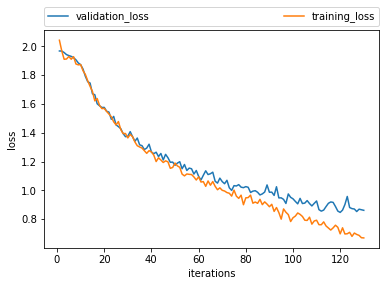

[1.9682944478659794,
 1.9679175574204018,
 1.9572791765476096,
 1.9431975545554325,
 1.9361898282478596,
 1.9308686379728646,
 1.9218989240712132,
 1.9070148180271018,
 1.8853138027520016,
 1.8731939134926632,
 1.84272156912705,
 1.7924840450286865,
 1.7548802104489556,
 1.7457547105591873,
 1.6708174697284042,
 1.664747875312279,
 1.6019375776422435,
 1.587913233658363,
 1.5759519009754575,
 1.5768422463844562,
 1.5502665947223533,
 1.5438938839682217,
 1.4938235200684646,
 1.5139709587754875,
 1.4557040683154403,
 1.4431762119819378,
 1.428970349246058,
 1.395083803555061,
 1.3733641895754585,
 1.3767282757265815,
 1.40827385310469,
 1.3734093925048565,
 1.3414135184781304,
 1.3638052570408787,
 1.3169065590562492,
 1.310879008523349,
 1.283841108453685,
 1.2942142198825706,
 1.3210357139850486,
 1.2667795049733128,
 1.2555305012341202,
 1.2655444350735894,
 1.2351887513851296,
 1.2569481011094719,
 1.2118595324713608,
 1.2508385798026775,
 1.2271575372794579,
 1.1955288689711998,
 1

In [57]:
train_save('age', 1, 2)

minibatch:49, epoch:1, iteration:49, training_error:2.082423675060272, validation_error:1.9731210716839493
Best loss improvement from inf to 1.9731210716839493 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:1.9584045791625977, validation_error:1.9483881407770618
Best loss improvement from 1.9731210716839493 to 1.9483881407770618 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:1.9464301896095275, validation_error:1.9507071067546975
minibatch:199, epoch:1, iteration:199, training_error:1.9676092195510864, validation_error:1.9382742478929718
Best loss improvement from 1.9483881407770618 to 1.9382742478929718 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:1.9642959547042846, validation_error:1.9283421943927634
Best loss improvement from 1.9382742478929718 to 1.9283421943927634 in epoch 1
minibatch:45, epoch:2, iteration:299, training_error:1.9430396819114686, validation_error:1.9277627796962344
Best loss improvement from 1.9283421943927634

minibatch:9, epoch:11, iteration:2549, training_error:1.2645764458179474, validation_error:1.3613408146233394
minibatch:59, epoch:11, iteration:2599, training_error:1.2409998679161072, validation_error:1.2112301670271775
Best loss improvement from 1.217386899323299 to 1.2112301670271775 in epoch 11
minibatch:109, epoch:11, iteration:2649, training_error:1.1751136362552643, validation_error:1.182570247814573
Best loss improvement from 1.2112301670271775 to 1.182570247814573 in epoch 11
minibatch:159, epoch:11, iteration:2699, training_error:1.176030683517456, validation_error:1.1622721408975536
Best loss improvement from 1.182570247814573 to 1.1622721408975536 in epoch 11
minibatch:209, epoch:11, iteration:2749, training_error:1.1753214859962464, validation_error:1.1651041569380924
minibatch:5, epoch:12, iteration:2799, training_error:1.185240233540535, validation_error:1.1707985606686822
minibatch:55, epoch:12, iteration:2849, training_error:1.1726222324371338, validation_error:1.13756

minibatch:219, epoch:21, iteration:5299, training_error:0.8889997363090515, validation_error:0.8988540234236881
Best loss improvement from 0.9025887764733413 to 0.8988540234236881 in epoch 21
minibatch:15, epoch:22, iteration:5349, training_error:0.8561418724060058, validation_error:0.9101502032115542
minibatch:65, epoch:22, iteration:5399, training_error:0.8443190014362335, validation_error:0.9282124227490919
minibatch:115, epoch:22, iteration:5449, training_error:0.8541039907932282, validation_error:0.8884640459356636
Best loss improvement from 0.8988540234236881 to 0.8884640459356636 in epoch 22
minibatch:165, epoch:22, iteration:5499, training_error:0.8275313341617584, validation_error:0.8870128002660028
Best loss improvement from 0.8884640459356636 to 0.8870128002660028 in epoch 22
minibatch:215, epoch:22, iteration:5549, training_error:0.829734326004982, validation_error:0.8975024983800691
minibatch:11, epoch:23, iteration:5599, training_error:0.8039171135425568, validation_error

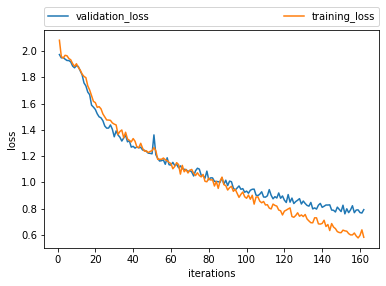

[1.9731210716839493,
 1.9483881407770618,
 1.9507071067546975,
 1.9382742478929718,
 1.9283421943927634,
 1.9277627796962344,
 1.9173720540671513,
 1.8854204745128238,
 1.8724217332642654,
 1.889013648033142,
 1.8818323201146618,
 1.8494597550096183,
 1.8192161362746666,
 1.757339206235162,
 1.7344518365531132,
 1.6875522753288006,
 1.6675460174165924,
 1.5878616571426392,
 1.5729963820556114,
 1.5553327223350262,
 1.5220312702244725,
 1.4991944123958718,
 1.4911382403866997,
 1.4690004422746856,
 1.4290197676625744,
 1.4127536683247006,
 1.4132989192831105,
 1.4370995225577519,
 1.4042955020378376,
 1.3469934874567493,
 1.3917588242169083,
 1.3607504696681583,
 1.3436578512191772,
 1.3144602405613866,
 1.3382729045275985,
 1.3600365211223733,
 1.3086361227364376,
 1.3170338252495075,
 1.2682571246706207,
 1.2744722859612827,
 1.260768438207692,
 1.2695231848749622,
 1.2624883775053353,
 1.2679684244353195,
 1.2463258073247712,
 1.2441575054464669,
 1.2354521093697384,
 1.2223006712979

In [58]:
train_save('age', 2, 2)

minibatch:49, epoch:1, iteration:49, training_error:2.072523717880249, validation_error:1.9655613859494527
Best loss improvement from inf to 1.9655613859494527 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:1.9722448897361755, validation_error:1.9543720920880636
Best loss improvement from 1.9655613859494527 to 1.9543720920880636 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:1.9647635579109193, validation_error:1.949923046429952
Best loss improvement from 1.9543720920880636 to 1.949923046429952 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:1.9666633939743041, validation_error:1.94125763575236
Best loss improvement from 1.949923046429952 to 1.94125763575236 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:1.9591805243492126, validation_error:1.946145808696747
minibatch:39, epoch:2, iteration:299, training_error:1.943188900947571, validation_error:1.9298790494600933
Best loss improvement from 1.94125763575236 to 1.92987

minibatch:259, epoch:10, iteration:2599, training_error:1.1779608643054962, validation_error:1.1966993470986684
minibatch:49, epoch:11, iteration:2649, training_error:1.1824685788154603, validation_error:1.1744789958000184
Best loss improvement from 1.18806498448054 to 1.1744789958000184 in epoch 11
minibatch:99, epoch:11, iteration:2699, training_error:1.140316255092621, validation_error:1.168415238459905
Best loss improvement from 1.1744789958000184 to 1.168415238459905 in epoch 11
minibatch:149, epoch:11, iteration:2749, training_error:1.1760302782058716, validation_error:1.1848253905773163
minibatch:199, epoch:11, iteration:2799, training_error:1.1386583268642425, validation_error:1.1652403970559437
Best loss improvement from 1.168415238459905 to 1.1652403970559437 in epoch 11
minibatch:249, epoch:11, iteration:2849, training_error:1.106011164188385, validation_error:1.1926601270834605
minibatch:39, epoch:12, iteration:2899, training_error:1.1090401136875152, validation_error:1.188

minibatch:189, epoch:22, iteration:5649, training_error:0.7745849061012268, validation_error:0.9496699790159862
minibatch:239, epoch:22, iteration:5699, training_error:0.7759311914443969, validation_error:0.8888236085573832
Best loss improvement from 0.9044187784194946 to 0.8888236085573832 in epoch 22
minibatch:29, epoch:23, iteration:5749, training_error:0.7611159658432007, validation_error:0.9067638556162516
minibatch:79, epoch:23, iteration:5799, training_error:0.7431528663635254, validation_error:0.8894295831521352
minibatch:129, epoch:23, iteration:5849, training_error:0.7664531803131104, validation_error:0.9531109790007274
minibatch:179, epoch:23, iteration:5899, training_error:0.7219622230529785, validation_error:0.9482291181882222
minibatch:229, epoch:23, iteration:5949, training_error:0.7728457450866699, validation_error:0.9065474530061086
minibatch:19, epoch:24, iteration:5999, training_error:0.7586506760120392, validation_error:0.8822296172380447
Best loss improvement from 

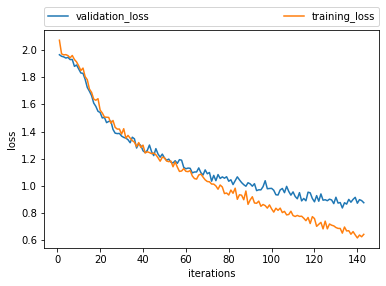

[1.9655613859494527,
 1.9543720920880636,
 1.949923046429952,
 1.94125763575236,
 1.946145808696747,
 1.9298790494600933,
 1.9309478640556335,
 1.8801506519317628,
 1.890264598528544,
 1.8599123279253642,
 1.8312462290128073,
 1.8285679976145426,
 1.7845234592755637,
 1.7247787117958069,
 1.6968075076738993,
 1.6645295858383178,
 1.609732492764791,
 1.5850632349650065,
 1.54895707766215,
 1.5403188387552897,
 1.500121041138967,
 1.5038715481758118,
 1.4655722061793008,
 1.474318794409434,
 1.476853652795156,
 1.4152400851249696,
 1.3879625340302786,
 1.3846854249636331,
 1.3859600186347962,
 1.3664490739504496,
 1.3565359989802042,
 1.351279330253601,
 1.3395615816116333,
 1.317313794294993,
 1.3579599936803182,
 1.3461453954378764,
 1.2783861716588338,
 1.310737097263336,
 1.2961929202079774,
 1.2582641959190368,
 1.2450740357240042,
 1.2608071247736612,
 1.3004212737083436,
 1.251520703236262,
 1.2225637078285216,
 1.2739477157592773,
 1.2341536621252696,
 1.21094877521197,
 1.233640

In [59]:
train_save('age', 3, 2)

minibatch:49, epoch:1, iteration:49, training_error:2.0726014089584353, validation_error:1.9596561661788396
Best loss improvement from inf to 1.9596561661788396 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:1.9775461077690124, validation_error:1.943029714482171
Best loss improvement from 1.9596561661788396 to 1.943029714482171 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:1.9635046339035034, validation_error:1.9538452752998896
minibatch:199, epoch:1, iteration:199, training_error:1.9310139417648315, validation_error:1.9832901443753923
minibatch:1, epoch:2, iteration:249, training_error:1.9631520175933839, validation_error:1.9523594081401825
minibatch:51, epoch:2, iteration:299, training_error:1.9620236563682556, validation_error:1.9432969646794456
minibatch:101, epoch:2, iteration:349, training_error:1.9428874826431275, validation_error:1.9433112825666154
minibatch:151, epoch:2, iteration:399, training_error:1.9199186515808107, validation_error:1.931

minibatch:169, epoch:11, iteration:2649, training_error:1.15486998796463, validation_error:1.130356369274003
minibatch:219, epoch:11, iteration:2699, training_error:1.1437632286548614, validation_error:1.1735146130834306
minibatch:21, epoch:12, iteration:2749, training_error:1.1126034152507782, validation_error:1.1654586344957352
minibatch:71, epoch:12, iteration:2799, training_error:1.142464075088501, validation_error:1.0959785942520415
Best loss improvement from 1.117117355976786 to 1.0959785942520415 in epoch 12
minibatch:121, epoch:12, iteration:2849, training_error:1.105395712852478, validation_error:1.082455996956144
Best loss improvement from 1.0959785942520415 to 1.082455996956144 in epoch 12
minibatch:171, epoch:12, iteration:2899, training_error:1.0794544148445129, validation_error:1.069223940372467
Best loss improvement from 1.082455996956144 to 1.069223940372467 in epoch 12
minibatch:221, epoch:12, iteration:2949, training_error:1.0851973247528077, validation_error:1.071360

minibatch:93, epoch:23, iteration:5549, training_error:0.7789922666549682, validation_error:0.8451790171010154
minibatch:143, epoch:23, iteration:5599, training_error:0.7970882213115692, validation_error:0.8442781950746264
minibatch:193, epoch:23, iteration:5649, training_error:0.739659423828125, validation_error:0.8743493716631617
minibatch:243, epoch:23, iteration:5699, training_error:0.7611675024032593, validation_error:0.8346053191593715
minibatch:45, epoch:24, iteration:5749, training_error:0.7104105591773987, validation_error:0.866125573004995
minibatch:95, epoch:24, iteration:5799, training_error:0.72827612221241, validation_error:0.8324168239321027
minibatch:145, epoch:24, iteration:5849, training_error:0.7371202600002289, validation_error:0.8267149520771844
minibatch:195, epoch:24, iteration:5899, training_error:0.7630822253227234, validation_error:0.8267179642404828
minibatch:245, epoch:24, iteration:5949, training_error:0.7512046515941619, validation_error:0.9396406475986753

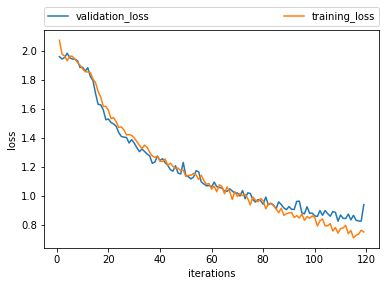

[1.9596561661788396,
 1.943029714482171,
 1.9538452752998896,
 1.9832901443753923,
 1.9523594081401825,
 1.9432969646794456,
 1.9433112825666154,
 1.9318096935749054,
 1.8849949751581465,
 1.886918238231114,
 1.8601283856800623,
 1.882860187973295,
 1.8231857206140245,
 1.7955540248325892,
 1.706721965755735,
 1.6308334597519465,
 1.6279405738626207,
 1.593388510601861,
 1.5244774264948708,
 1.5298176322664534,
 1.5058348391737257,
 1.4958490218435014,
 1.4803387565272195,
 1.435864154781614,
 1.4099964584623064,
 1.4046874003750938,
 1.402709186077118,
 1.3646840367998396,
 1.3875413196427482,
 1.3640505288328444,
 1.3329693164144243,
 1.3045017910855157,
 1.32304961340768,
 1.3064739278384618,
 1.2883230532918657,
 1.2759853984628404,
 1.224626553910119,
 1.233626514673233,
 1.2738530380385262,
 1.2439392358064651,
 1.2564620567219598,
 1.229041406086513,
 1.2098335985626494,
 1.180959810103689,
 1.1703158574444907,
 1.2075219367231642,
 1.1568388491868973,
 1.1509546978133065,
 1.23

In [60]:
train_save('age', 4, 2)

minibatch:49, epoch:1, iteration:49, training_error:1.1360015022754668, validation_error:0.722348948319753
Best loss improvement from inf to 0.722348948319753 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.7159895062446594, validation_error:0.717132740550571
Best loss improvement from 0.722348948319753 to 0.717132740550571 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:0.7141035079956055, validation_error:0.7082315175621597
Best loss improvement from 0.717132740550571 to 0.7082315175621597 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:0.707848185300827, validation_error:0.6902340628482677
Best loss improvement from 0.7082315175621597 to 0.6902340628482677 in epoch 1
minibatch:3, epoch:2, iteration:249, training_error:0.6958653426170349, validation_error:0.6974462778479965
minibatch:53, epoch:2, iteration:299, training_error:0.6997613251209259, validation_error:0.6849546277964557
Best loss improvement from 0.6902340628482677 to 0.68

minibatch:139, epoch:11, iteration:2599, training_error:0.25676293537020684, validation_error:0.33303656622215555
minibatch:189, epoch:11, iteration:2649, training_error:0.2691763474047184, validation_error:0.3304515685196276
minibatch:239, epoch:11, iteration:2699, training_error:0.26804257988929747, validation_error:0.3127756576847147
Best loss improvement from 0.3172342959377501 to 0.3127756576847147 in epoch 11
minibatch:43, epoch:12, iteration:2749, training_error:0.22385863721370697, validation_error:0.31204096586615954
Best loss improvement from 0.3127756576847147 to 0.31204096586615954 in epoch 12
minibatch:93, epoch:12, iteration:2799, training_error:0.23881524339318275, validation_error:0.34928891504252396
minibatch:143, epoch:12, iteration:2849, training_error:0.23579139783978462, validation_error:0.2966328075638524
Best loss improvement from 0.31204096586615954 to 0.2966328075638524 in epoch 12
minibatch:193, epoch:12, iteration:2899, training_error:0.21253728553652762, val

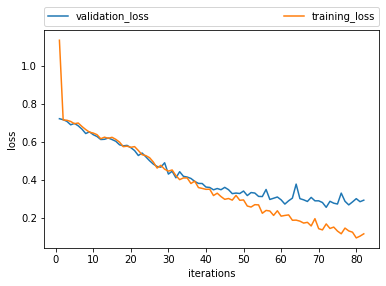

[0.722348948319753,
 0.717132740550571,
 0.7082315175621597,
 0.6902340628482677,
 0.6974462778479965,
 0.6849546277964557,
 0.6674090425173441,
 0.6441415195111875,
 0.6531064311663309,
 0.6380388913331209,
 0.628525784722081,
 0.612711387651938,
 0.6138411230511136,
 0.6207366596769404,
 0.6125028309998689,
 0.6034877101580302,
 0.5849149039498082,
 0.5792565036703039,
 0.5817421078681946,
 0.569777227110333,
 0.5544910530249277,
 0.5283432117214909,
 0.5414567920896742,
 0.5213675322356047,
 0.5007036284164146,
 0.48296551240815055,
 0.47041198721638433,
 0.4669039083851708,
 0.4901142319043477,
 0.43042617705133224,
 0.44530077775319415,
 0.4107868119522377,
 0.44295742831848284,
 0.4185940744700255,
 0.4147915773921543,
 0.40736886858940125,
 0.39201803174283767,
 0.3813623267191428,
 0.38063086182982836,
 0.36203767083309313,
 0.35989510350757176,
 0.34752950017099027,
 0.3542953243962041,
 0.34800216058890027,
 0.3603795016253436,
 0.3481436758129685,
 0.3273453215758006,
 0.330

In [61]:
train_save('gender', 0, 0)

minibatch:49, epoch:1, iteration:49, training_error:1.1038104498386383, validation_error:0.7334021987586186
Best loss improvement from inf to 0.7334021987586186 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.7267096626758576, validation_error:0.7245011021350992
Best loss improvement from 0.7334021987586186 to 0.7245011021350992 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:0.7142460930347443, validation_error:0.7132195069872099
Best loss improvement from 0.7245011021350992 to 0.7132195069872099 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:0.7067470562458038, validation_error:0.7064978459785725
Best loss improvement from 0.7132195069872099 to 0.7064978459785725 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:0.703912672996521, validation_error:0.7028922829134711
Best loss improvement from 0.7064978459785725 to 0.7028922829134711 in epoch 1
minibatch:47, epoch:2, iteration:299, training_error:0.7051310014724731, va

minibatch:79, epoch:11, iteration:2599, training_error:0.2657260000705719, validation_error:0.302869554480602
minibatch:129, epoch:11, iteration:2649, training_error:0.30058120042085645, validation_error:0.28678185030304154
Best loss improvement from 0.29954432362112504 to 0.28678185030304154 in epoch 11
minibatch:179, epoch:11, iteration:2699, training_error:0.25452454283833503, validation_error:0.30522863412725515
minibatch:229, epoch:11, iteration:2749, training_error:0.2767463453114033, validation_error:0.28987984616180945
minibatch:27, epoch:12, iteration:2799, training_error:0.2629680988192558, validation_error:0.3647854456613804
minibatch:77, epoch:12, iteration:2849, training_error:0.24131533980369568, validation_error:0.2962240658957383
minibatch:127, epoch:12, iteration:2899, training_error:0.24081674352288246, validation_error:0.28321965706759483
Best loss improvement from 0.28678185030304154 to 0.28321965706759483 in epoch 12
minibatch:177, epoch:12, iteration:2949, trainin

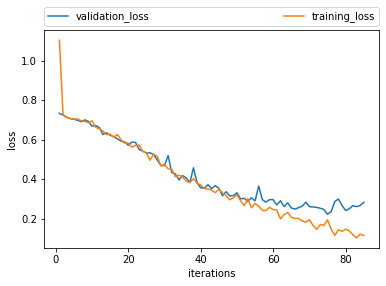

[0.7334021987586186,
 0.7245011021350992,
 0.7132195069872099,
 0.7064978459785725,
 0.7028922829134711,
 0.6983806059278291,
 0.6911453686911484,
 0.700154565531632,
 0.6930832020167647,
 0.6679499601495678,
 0.6717219270508865,
 0.6618374318912111,
 0.6258410359251088,
 0.635201213688686,
 0.6222290139773796,
 0.6153571800938968,
 0.6033737423091099,
 0.5926113858305174,
 0.589045073451667,
 0.571371146317186,
 0.5876055770906908,
 0.5862060086480503,
 0.550155385814864,
 0.5419663478588236,
 0.5323455981139479,
 0.5332063713978077,
 0.5245939976182478,
 0.4972380728557192,
 0.4688323386784258,
 0.4687543388070731,
 0.5193744445669239,
 0.433482996348677,
 0.4263923640908866,
 0.39589664185869283,
 0.4177635219590417,
 0.4062678351484496,
 0.38240422025836746,
 0.4572065410942867,
 0.3820001071897046,
 0.35592293944852105,
 0.3538613360503624,
 0.371803115667968,
 0.3515171105491704,
 0.366818670568795,
 0.35435364575221623,
 0.3153207867309965,
 0.3361475596140171,
 0.31489980066644

In [62]:
train_save('gender', 1, 0)

minibatch:49, epoch:1, iteration:49, training_error:1.1085870814323426, validation_error:0.7283189358382389
Best loss improvement from inf to 0.7283189358382389 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.7227649009227752, validation_error:0.7140442256269783
Best loss improvement from 0.7283189358382389 to 0.7140442256269783 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:0.7093638896942138, validation_error:0.7177347150342218
minibatch:199, epoch:1, iteration:199, training_error:0.7074286210536956, validation_error:0.708429778444356
Best loss improvement from 0.7140442256269783 to 0.708429778444356 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:0.7069973623752595, validation_error:0.6998936883334456
Best loss improvement from 0.708429778444356 to 0.6998936883334456 in epoch 1
minibatch:39, epoch:2, iteration:299, training_error:0.7026111567020417, validation_error:0.7062569096170622
minibatch:89, epoch:2, iteration:349, training_

minibatch:49, epoch:11, iteration:2649, training_error:0.2672110915184021, validation_error:0.3518362070979743
Best loss improvement from 0.3531807537736564 to 0.3518362070979743 in epoch 11
minibatch:99, epoch:11, iteration:2699, training_error:0.27249414622783663, validation_error:0.34574566216304387
Best loss improvement from 0.3518362070979743 to 0.34574566216304387 in epoch 11
minibatch:149, epoch:11, iteration:2749, training_error:0.25581112399697303, validation_error:0.35628749070496396
minibatch:199, epoch:11, iteration:2799, training_error:0.25237458527088164, validation_error:0.37254854420135763
minibatch:249, epoch:11, iteration:2849, training_error:0.28330409109592436, validation_error:0.3442328788083175
Best loss improvement from 0.34574566216304387 to 0.3442328788083175 in epoch 11
minibatch:39, epoch:12, iteration:2899, training_error:0.22021223604679108, validation_error:0.33129404587992306
Best loss improvement from 0.3442328788083175 to 0.33129404587992306 in epoch 12

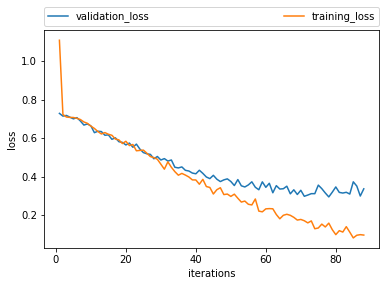

[0.7283189358382389,
 0.7140442256269783,
 0.7177347150342218,
 0.708429778444356,
 0.6998936883334456,
 0.7062569096170622,
 0.6886201130932775,
 0.6675327379128029,
 0.6734096346230343,
 0.6629238149215435,
 0.6280659190539656,
 0.6355258760781124,
 0.6337657940798792,
 0.6145914176414753,
 0.6165866553783417,
 0.593574725348374,
 0.601182510112894,
 0.5811210911849449,
 0.577486220104941,
 0.5642203287831669,
 0.5739741572018328,
 0.5522701318921714,
 0.5686099498436369,
 0.5427578112174725,
 0.5245361872788133,
 0.5182522525047434,
 0.5150310356041481,
 0.49236971345441094,
 0.5042565197780214,
 0.48593088778956184,
 0.49321774367628424,
 0.4804769271406634,
 0.4860314706276203,
 0.44824544314680426,
 0.44476274991857595,
 0.45000460743904114,
 0.43236306823533155,
 0.428722961195584,
 0.4181045340052966,
 0.41428893496250285,
 0.4326932831057187,
 0.4163865102776166,
 0.3975989232803213,
 0.38921938065824835,
 0.4063475933568231,
 0.3861404539182268,
 0.37376398361962415,
 0.38259

In [63]:
train_save('gender', 2, 0)

minibatch:49, epoch:1, iteration:49, training_error:1.1426011228561401, validation_error:0.7391086015208014
Best loss improvement from inf to 0.7391086015208014 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.7348357975482941, validation_error:0.716344547682795
Best loss improvement from 0.7391086015208014 to 0.716344547682795 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:0.7119143331050872, validation_error:0.6973111177312916
Best loss improvement from 0.716344547682795 to 0.6973111177312916 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:0.7120218372344971, validation_error:0.703483653479609
minibatch:249, epoch:1, iteration:249, training_error:0.7039163792133332, validation_error:0.6941102845915432
Best loss improvement from 0.6973111177312916 to 0.6941102845915432 in epoch 1
minibatch:41, epoch:2, iteration:299, training_error:0.7067233836650848, validation_error:0.7036915709232462
minibatch:91, epoch:2, iteration:349, training_e

minibatch:69, epoch:11, iteration:2649, training_error:0.2885281080007553, validation_error:0.3808023241059533
minibatch:119, epoch:11, iteration:2699, training_error:0.27873721897602083, validation_error:0.3108558444113567
Best loss improvement from 0.3223593774540671 to 0.3108558444113567 in epoch 11
minibatch:169, epoch:11, iteration:2749, training_error:0.28212726205587385, validation_error:0.3166234863215479
minibatch:219, epoch:11, iteration:2799, training_error:0.29767272502183917, validation_error:0.3190127965705148
minibatch:11, epoch:12, iteration:2849, training_error:0.2875178360939026, validation_error:0.3098631167206271
Best loss improvement from 0.3108558444113567 to 0.3098631167206271 in epoch 12
minibatch:61, epoch:12, iteration:2899, training_error:0.25981459110975264, validation_error:0.3178877229320592
minibatch:111, epoch:12, iteration:2949, training_error:0.25660825133323667, validation_error:0.30355551684724874
Best loss improvement from 0.3098631167206271 to 0.30

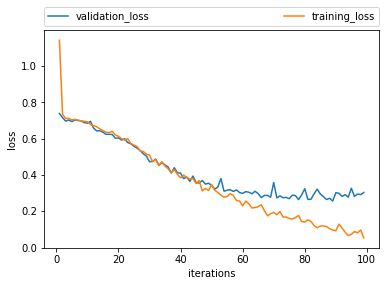

[0.7391086015208014,
 0.716344547682795,
 0.6973111177312916,
 0.703483653479609,
 0.6941102845915432,
 0.7036915709232462,
 0.7004977156376017,
 0.6987158553353672,
 0.6889318844367718,
 0.6857541080178886,
 0.6957948536708437,
 0.6584840581334871,
 0.6431071121117165,
 0.6442777822757589,
 0.6362875967190184,
 0.6241346720991463,
 0.6244058855648699,
 0.6234837421055498,
 0.6028495852289528,
 0.604529487675634,
 0.5930415638561907,
 0.5996119832170421,
 0.57917029384909,
 0.5724820237735222,
 0.5585658303622542,
 0.5482574567712587,
 0.5345846435119366,
 0.517151934319529,
 0.5043108751033915,
 0.4737993674031619,
 0.4748069315121092,
 0.4882633686065674,
 0.45483174714548835,
 0.4674747411547036,
 0.4560494207102677,
 0.4441513665791216,
 0.41125912090827677,
 0.44057181991379835,
 0.41165019777314416,
 0.411018036562821,
 0.38064144294837426,
 0.3889188673989526,
 0.3650024476750144,
 0.3945323660455901,
 0.35871075967262533,
 0.3558383131849355,
 0.37001435561426754,
 0.3501884217

In [64]:
train_save('gender', 3, 0)

minibatch:49, epoch:1, iteration:49, training_error:1.1585797345638276, validation_error:0.7470456978370403
Best loss improvement from inf to 0.7470456978370403 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.7319850850105286, validation_error:0.7234194422590321
Best loss improvement from 0.7470456978370403 to 0.7234194422590321 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:0.7112629544734955, validation_error:0.7207423448562622
Best loss improvement from 0.7234194422590321 to 0.7207423448562622 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:0.7113387370109558, validation_error:0.7017990247956638
Best loss improvement from 0.7207423448562622 to 0.7017990247956638 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:0.7027644443511963, validation_error:0.6978844178133997
Best loss improvement from 0.7017990247956638 to 0.6978844178133997 in epoch 1
minibatch:44, epoch:2, iteration:299, training_error:0.7013679599761963, v

minibatch:154, epoch:10, iteration:2449, training_error:0.2554031237959862, validation_error:0.2752137441059639
minibatch:204, epoch:10, iteration:2499, training_error:0.2678139221668243, validation_error:0.27195879868392286
minibatch:254, epoch:10, iteration:2549, training_error:0.26344081342220305, validation_error:0.25407872169182216
Best loss improvement from 0.2673244774341583 to 0.25407872169182216 in epoch 10
minibatch:49, epoch:11, iteration:2599, training_error:0.22512255102396012, validation_error:0.2561280357426611
minibatch:99, epoch:11, iteration:2649, training_error:0.22149331450462342, validation_error:0.2829527135553031
minibatch:149, epoch:11, iteration:2699, training_error:0.21898517534136772, validation_error:0.2747650598657542
minibatch:199, epoch:11, iteration:2749, training_error:0.2220172579586506, validation_error:0.26876032301064195
minibatch:249, epoch:11, iteration:2799, training_error:0.23117428302764892, validation_error:0.22719598176150485
Best loss improv

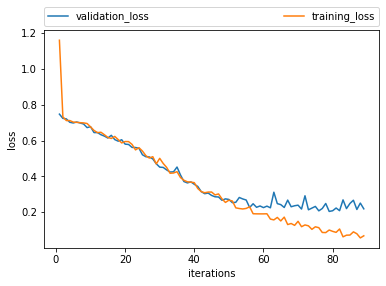

[0.7470456978370403,
 0.7234194422590321,
 0.7207423448562622,
 0.7017990247956638,
 0.6978844178133997,
 0.7033949905428393,
 0.6976780480351942,
 0.6920154012482742,
 0.6721192290043009,
 0.6771778957597141,
 0.6443789621879314,
 0.6444219761881335,
 0.6325197733681778,
 0.6247167073447129,
 0.614093264629101,
 0.6291338462254097,
 0.6054010514555306,
 0.5964756238049475,
 0.6045559850232355,
 0.5799850883155033,
 0.5781373422721336,
 0.5617271589821783,
 0.5612325945804859,
 0.5570175925205494,
 0.5209024826000477,
 0.5098859749991318,
 0.508652950155324,
 0.49742054117136986,
 0.4707734440935069,
 0.4519382581628602,
 0.45040046243832027,
 0.436423908019888,
 0.42472171783447266,
 0.42588479046163885,
 0.45255082229088095,
 0.4084550625291364,
 0.37166806541640185,
 0.3641330759073126,
 0.3698884094583577,
 0.3562995894201871,
 0.3443703594906577,
 0.31568208747896653,
 0.3040260986007493,
 0.307564004741866,
 0.2943724825464446,
 0.28683681323610505,
 0.28562732863015144,
 0.26732

In [65]:
train_save('gender', 4, 0)

minibatch:49, epoch:1, iteration:49, training_error:1.129762625694275, validation_error:0.7272533619845355
Best loss improvement from inf to 0.7272533619845355 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.7259762299060821, validation_error:0.7178612351417542
Best loss improvement from 0.7272533619845355 to 0.7178612351417542 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:0.7140761554241181, validation_error:0.7174914479255676
Best loss improvement from 0.7178612351417542 to 0.7174914479255676 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:0.7082244753837585, validation_error:0.7071179372292978
Best loss improvement from 0.7174914479255676 to 0.7071179372292978 in epoch 1
minibatch:3, epoch:2, iteration:249, training_error:0.7049085450172424, validation_error:0.6952538733129148
Best loss improvement from 0.7071179372292978 to 0.6952538733129148 in epoch 2
minibatch:53, epoch:2, iteration:299, training_error:0.6926702439785004, vali

minibatch:89, epoch:11, iteration:2549, training_error:0.3317795562744141, validation_error:0.34429383167514094
Best loss improvement from 0.35442751038957526 to 0.34429383167514094 in epoch 11
minibatch:139, epoch:11, iteration:2599, training_error:0.32772698134183886, validation_error:0.347192379059615
minibatch:189, epoch:11, iteration:2649, training_error:0.328288126885891, validation_error:0.342959013250139
Best loss improvement from 0.34429383167514094 to 0.342959013250139 in epoch 11
minibatch:239, epoch:11, iteration:2699, training_error:0.32079193204641343, validation_error:0.3377367936902576
Best loss improvement from 0.342959013250139 to 0.3377367936902576 in epoch 11
minibatch:43, epoch:12, iteration:2749, training_error:0.2929903697967529, validation_error:0.333524865132791
Best loss improvement from 0.3377367936902576 to 0.333524865132791 in epoch 12
minibatch:93, epoch:12, iteration:2799, training_error:0.30757549792528155, validation_error:0.3134478523775383
Best loss i

minibatch:187, epoch:23, iteration:5599, training_error:0.10635029576718807, validation_error:0.24477756244164925
minibatch:237, epoch:23, iteration:5649, training_error:0.12469808667898179, validation_error:0.2348047254814042
minibatch:41, epoch:24, iteration:5699, training_error:0.10785367377102376, validation_error:0.2785501441469899
minibatch:91, epoch:24, iteration:5749, training_error:0.10405487105250359, validation_error:0.2553235532508956
Patience ran out at 5749. Ending training


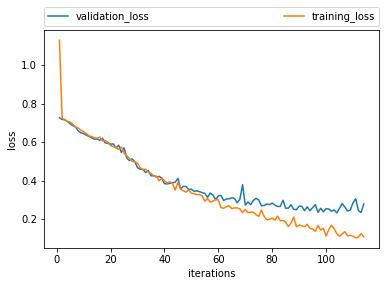

[0.7272533619845355,
 0.7178612351417542,
 0.7174914479255676,
 0.7071179372292978,
 0.6952538733129148,
 0.6860268182224698,
 0.678434118076607,
 0.6589542826016744,
 0.648377001285553,
 0.644323797137649,
 0.6362741611621998,
 0.6303037294635067,
 0.6225512976999636,
 0.6155953076150682,
 0.6161566509140862,
 0.6098582523840445,
 0.6206615832116869,
 0.5963754444210617,
 0.5938967400126987,
 0.5892880117451703,
 0.5910653240150876,
 0.5699401199817657,
 0.5841588411066267,
 0.5461779236793518,
 0.5706414547231462,
 0.5187809390050394,
 0.5041576160324944,
 0.5131180959719198,
 0.49813746854111,
 0.46692422805009065,
 0.45995276062576856,
 0.45829242688638194,
 0.44229604910921166,
 0.4530041891115683,
 0.4251115095836145,
 0.42682621876398724,
 0.41826948799468855,
 0.4226458668708801,
 0.41376271181636387,
 0.3844323014771497,
 0.3831949675524676,
 0.3858409904771381,
 0.38933520129433385,
 0.3915375084788711,
 0.4121717915490822,
 0.3580937335888545,
 0.3700066738658481,
 0.3694375

In [66]:
train_save('gender', 0, 1)

minibatch:49, epoch:1, iteration:49, training_error:1.1295204663276672, validation_error:0.7502411994440802
Best loss improvement from inf to 0.7502411994440802 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.7333969223499298, validation_error:0.7101090982042509
Best loss improvement from 0.7502411994440802 to 0.7101090982042509 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:0.716178160905838, validation_error:0.7097335560568447
Best loss improvement from 0.7101090982042509 to 0.7097335560568447 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:0.7073363661766052, validation_error:0.7019781059232252
Best loss improvement from 0.7097335560568447 to 0.7019781059232252 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:0.6994355273246765, validation_error:0.692776425131436
Best loss improvement from 0.7019781059232252 to 0.692776425131436 in epoch 1
minibatch:47, epoch:2, iteration:299, training_error:0.6994252645969391, vali

minibatch:129, epoch:11, iteration:2649, training_error:0.33291911661624907, validation_error:0.35484156012535095
minibatch:179, epoch:11, iteration:2699, training_error:0.32084823459386824, validation_error:0.3253864887459525
Best loss improvement from 0.3301150433976075 to 0.3253864887459525 in epoch 11
minibatch:229, epoch:11, iteration:2749, training_error:0.3035653734207153, validation_error:0.3108787033064612
Best loss improvement from 0.3253864887459525 to 0.3108787033064612 in epoch 11
minibatch:27, epoch:12, iteration:2799, training_error:0.3165034258365631, validation_error:0.3115537927068513
minibatch:77, epoch:12, iteration:2849, training_error:0.29641113579273226, validation_error:0.29455271260491733
Best loss improvement from 0.3108787033064612 to 0.29455271260491733 in epoch 12
minibatch:127, epoch:12, iteration:2899, training_error:0.29051950097084045, validation_error:0.2923214790122262
Best loss improvement from 0.29455271260491733 to 0.2923214790122262 in epoch 12
mi

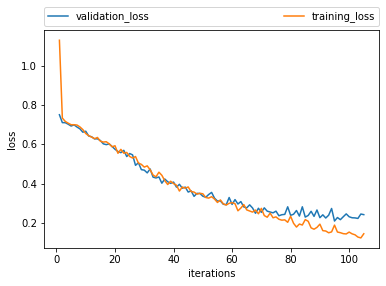

[0.7502411994440802,
 0.7101090982042509,
 0.7097335560568447,
 0.7019781059232252,
 0.692776425131436,
 0.6986692917758021,
 0.6876901532041615,
 0.6785077267679674,
 0.6614203411957313,
 0.6662703937497633,
 0.6420793081152028,
 0.638000893181768,
 0.6273379695826563,
 0.627773930286539,
 0.6187212693280187,
 0.6020902909081558,
 0.5980163226867544,
 0.6017989762898149,
 0.588652004455698,
 0.5743710450057326,
 0.5631769998320217,
 0.557160279874144,
 0.5690766531845619,
 0.5374651171010116,
 0.5527367787114505,
 0.5459092403280323,
 0.4926971854834721,
 0.5058138637707151,
 0.47072204536405104,
 0.46809293792165557,
 0.45430374967640846,
 0.47413745522499084,
 0.43251225968887064,
 0.4283131466343485,
 0.43354870224821157,
 0.4016039606569142,
 0.4230446733277419,
 0.4091871781595822,
 0.40082298270587263,
 0.407380603510758,
 0.38160929392124043,
 0.39601592308488387,
 0.37633780364332525,
 0.38180283585499075,
 0.3565911126547846,
 0.362808037420799,
 0.3347409228826391,
 0.349878

In [67]:
train_save('gender', 1, 1)

minibatch:49, epoch:1, iteration:49, training_error:1.1465121877193452, validation_error:0.7412896361844293
Best loss improvement from inf to 0.7412896361844293 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.7358469605445862, validation_error:0.7258798027860707
Best loss improvement from 0.7412896361844293 to 0.7258798027860707 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:0.7183757543563842, validation_error:0.7016352394531513
Best loss improvement from 0.7258798027860707 to 0.7016352394531513 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:0.7090011370182038, validation_error:0.7033701107419771
minibatch:249, epoch:1, iteration:249, training_error:0.7027976310253143, validation_error:0.7011731513615312
Best loss improvement from 0.7016352394531513 to 0.7011731513615312 in epoch 1
minibatch:39, epoch:2, iteration:299, training_error:0.6996039581298829, validation_error:0.693007284197314
Best loss improvement from 0.7011731513615312

minibatch:209, epoch:10, iteration:2549, training_error:0.3353828817605972, validation_error:0.3749167210069196
minibatch:259, epoch:10, iteration:2599, training_error:0.3119064676761627, validation_error:0.37504294617422695
minibatch:49, epoch:11, iteration:2649, training_error:0.29860323667526245, validation_error:0.368284203369042
minibatch:99, epoch:11, iteration:2699, training_error:0.3033068573474884, validation_error:0.3815016443359441
minibatch:149, epoch:11, iteration:2749, training_error:0.2873562309145927, validation_error:0.35384538410038785
Best loss improvement from 0.3595420528074791 to 0.35384538410038785 in epoch 11
minibatch:199, epoch:11, iteration:2799, training_error:0.3011601650714874, validation_error:0.4059818561734824
minibatch:249, epoch:11, iteration:2849, training_error:0.3050824710726738, validation_error:0.3362536471465538
Best loss improvement from 0.35384538410038785 to 0.3362536471465538 in epoch 11
minibatch:39, epoch:12, iteration:2899, training_error

minibatch:89, epoch:22, iteration:5549, training_error:0.09943242086097598, validation_error:0.30289365656288536
minibatch:139, epoch:22, iteration:5599, training_error:0.11531625002622604, validation_error:0.2765932573840536
minibatch:189, epoch:22, iteration:5649, training_error:0.09823614872992038, validation_error:0.2881091469577674
minibatch:239, epoch:22, iteration:5699, training_error:0.11966087123379111, validation_error:0.25072434313338376
Patience ran out at 5699. Ending training


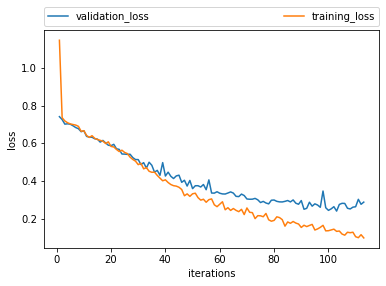

[0.7412896361844293,
 0.7258798027860707,
 0.7016352394531513,
 0.7033701107419771,
 0.7011731513615312,
 0.693007284197314,
 0.6835269208612114,
 0.6773237565468098,
 0.6615012986906643,
 0.6664086354189905,
 0.6367358483117203,
 0.6326219316186577,
 0.6321458323248501,
 0.6239205105551358,
 0.6220749678282902,
 0.6062899314124008,
 0.6152829425088291,
 0.6019220177469582,
 0.5898032404225448,
 0.5873417854309082,
 0.5945841094543194,
 0.5708649764800894,
 0.5677434493755472,
 0.5432783837976127,
 0.5426343751364741,
 0.5413188060809826,
 0.5419762607278495,
 0.5241877837427731,
 0.5138098566696562,
 0.5136205173771957,
 0.48733005441468336,
 0.49725766017519196,
 0.46837899191626187,
 0.49958469538853084,
 0.4834860809918108,
 0.44684386253356934,
 0.45653959286623985,
 0.4303294451072298,
 0.49763580848430766,
 0.42643212244428436,
 0.4468967719324704,
 0.42501357917127935,
 0.41316999340879507,
 0.42705647493230886,
 0.43095102700693855,
 0.39310067994841214,
 0.4039765786508034,
 

In [68]:
train_save('gender', 2, 1)

minibatch:49, epoch:1, iteration:49, training_error:1.1165353488922118, validation_error:0.7298119438105616
Best loss improvement from inf to 0.7298119438105616 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.7270409524440765, validation_error:0.7146878242492676
Best loss improvement from 0.7298119438105616 to 0.7146878242492676 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:0.7141283810138702, validation_error:0.7035962548749201
Best loss improvement from 0.7146878242492676 to 0.7035962548749201 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:0.7076599514484405, validation_error:0.7122430308111782
minibatch:249, epoch:1, iteration:249, training_error:0.7062438797950744, validation_error:0.6965723202146333
Best loss improvement from 0.7035962548749201 to 0.6965723202146333 in epoch 1
minibatch:41, epoch:2, iteration:299, training_error:0.7023591983318329, validation_error:0.700554818942629
minibatch:91, epoch:2, iteration:349, trainin

minibatch:69, epoch:11, iteration:2649, training_error:0.28733044654130935, validation_error:0.29769790069810276
Best loss improvement from 0.31564891543881646 to 0.29769790069810276 in epoch 11
minibatch:119, epoch:11, iteration:2699, training_error:0.2924707579612732, validation_error:0.29128376317435295
Best loss improvement from 0.29769790069810276 to 0.29128376317435295 in epoch 11
minibatch:169, epoch:11, iteration:2749, training_error:0.2988747522234917, validation_error:0.3158373236656189
minibatch:219, epoch:11, iteration:2799, training_error:0.26639813512563704, validation_error:0.2924186587333679
minibatch:11, epoch:12, iteration:2849, training_error:0.30026056855916977, validation_error:0.3094784072760878
minibatch:61, epoch:12, iteration:2899, training_error:0.26186856895685195, validation_error:0.29021970465265473
Best loss improvement from 0.29128376317435295 to 0.29021970465265473 in epoch 12
minibatch:111, epoch:12, iteration:2949, training_error:0.2582856249809265, va

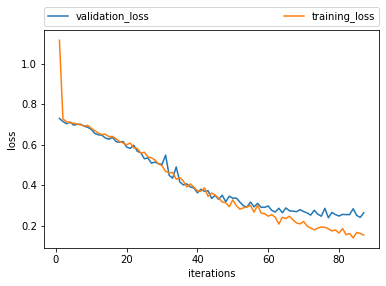

[0.7298119438105616,
 0.7146878242492676,
 0.7035962548749201,
 0.7122430308111782,
 0.6965723202146333,
 0.700554818942629,
 0.7007101774215698,
 0.6913725733757019,
 0.6857369521568561,
 0.6755453142626532,
 0.6555205974085577,
 0.648842283364,
 0.6465879226553028,
 0.6326969903090904,
 0.6271161498694584,
 0.63633734604408,
 0.615224657387569,
 0.6116189905281725,
 0.6154443724402066,
 0.5880799170198112,
 0.5816031139472435,
 0.5969943599454288,
 0.5673396464051872,
 0.5600453676848576,
 0.5301461332830889,
 0.5343397136392265,
 0.508287041351713,
 0.5138090890029381,
 0.5055445586812908,
 0.5026314135255485,
 0.5483221257555073,
 0.4484141941728263,
 0.43413745020997935,
 0.48981170304890337,
 0.41630037899675043,
 0.4007331821425208,
 0.4060012811216815,
 0.39077121276279975,
 0.3859661894625631,
 0.361924918047313,
 0.3795323474653836,
 0.368935063995164,
 0.37206452160046016,
 0.3340851700511472,
 0.34891868305617363,
 0.32952861950315276,
 0.350071452301124,
 0.317802318211259

In [69]:
train_save('gender', 3, 1)

minibatch:49, epoch:1, iteration:49, training_error:1.1355813121795655, validation_error:0.7358848658101312
Best loss improvement from inf to 0.7358848658101312 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.7222146356105804, validation_error:0.7063809181081837
Best loss improvement from 0.7358848658101312 to 0.7063809181081837 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:0.7140609431266784, validation_error:0.7006316513850771
Best loss improvement from 0.7063809181081837 to 0.7006316513850771 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:0.7039700889587402, validation_error:0.7098529503263277
minibatch:249, epoch:1, iteration:249, training_error:0.7094803869724273, validation_error:0.6965765726977381
Best loss improvement from 0.7006316513850771 to 0.6965765726977381 in epoch 1
minibatch:44, epoch:2, iteration:299, training_error:0.6968409478664398, validation_error:0.6994175479329866
minibatch:94, epoch:2, iteration:349, traini

minibatch:254, epoch:10, iteration:2549, training_error:0.3260322153568268, validation_error:0.29665476905888527
minibatch:49, epoch:11, iteration:2599, training_error:0.2974960738420486, validation_error:0.29144969068724536
Best loss improvement from 0.2945190878777668 to 0.29144969068724536 in epoch 11
minibatch:99, epoch:11, iteration:2649, training_error:0.29090758830308916, validation_error:0.29955085803722514
minibatch:149, epoch:11, iteration:2699, training_error:0.3145723450183868, validation_error:0.3256363272666931
minibatch:199, epoch:11, iteration:2749, training_error:0.2857916882634163, validation_error:0.2800235578726078
Best loss improvement from 0.29144969068724536 to 0.2800235578726078 in epoch 11
minibatch:249, epoch:11, iteration:2799, training_error:0.30218239486217496, validation_error:0.28287589138951796
minibatch:44, epoch:12, iteration:2849, training_error:0.2699382548034191, validation_error:0.2823203457840558
minibatch:94, epoch:12, iteration:2899, training_er

minibatch:39, epoch:23, iteration:5649, training_error:0.10720310412347317, validation_error:0.25912288602056177
minibatch:89, epoch:23, iteration:5699, training_error:0.10386022668331861, validation_error:0.20840572989706335
minibatch:139, epoch:23, iteration:5749, training_error:0.11276889834553003, validation_error:0.18115402347054974
minibatch:189, epoch:23, iteration:5799, training_error:0.11123367451131344, validation_error:0.19300192620219855
minibatch:239, epoch:23, iteration:5849, training_error:0.09226608715951443, validation_error:0.20963510678246103
Patience ran out at 5849. Ending training


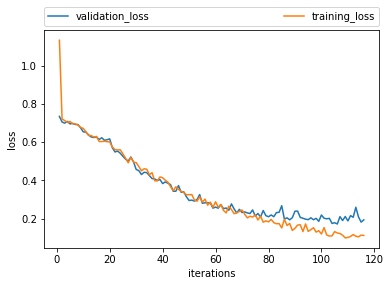

[0.7358848658101312,
 0.7063809181081837,
 0.7006316513850771,
 0.7098529503263277,
 0.6965765726977381,
 0.6994175479329866,
 0.6934663941120279,
 0.69328046050565,
 0.6760827672892603,
 0.6548874254884391,
 0.6531062783866093,
 0.6393934447189857,
 0.6277761911523754,
 0.6250214802807775,
 0.628350019454956,
 0.6147252054050051,
 0.6237736919830585,
 0.6106550179678818,
 0.6133115702661974,
 0.6181988284505647,
 0.5716089596008432,
 0.5494015093507438,
 0.5538510012215582,
 0.5425200195148073,
 0.5264568554944006,
 0.5116269619300448,
 0.501628911700742,
 0.5230196149184786,
 0.4973876733204414,
 0.45763177398977606,
 0.4512983550285471,
 0.4308497042491518,
 0.44266148168465186,
 0.4408045781069788,
 0.42502850602413045,
 0.4097736621725148,
 0.40774652978469583,
 0.39943355424650784,
 0.4047247865076723,
 0.38333217234447087,
 0.3920523575667677,
 0.38551628075796984,
 0.37762847388612814,
 0.34311207717862624,
 0.3434093486646126,
 0.37276702656828126,
 0.33753568190952826,
 0.339

In [70]:
train_save('gender', 4, 1)

minibatch:49, epoch:1, iteration:49, training_error:1.1316605615615845, validation_error:0.733214623398251
Best loss improvement from inf to 0.733214623398251 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.7300678372383118, validation_error:0.7086770976031268
Best loss improvement from 0.733214623398251 to 0.7086770976031268 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:0.7143679285049438, validation_error:0.7029492788844638
Best loss improvement from 0.7086770976031268 to 0.7029492788844638 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:0.7044877576828003, validation_error:0.7020082694512827
Best loss improvement from 0.7029492788844638 to 0.7020082694512827 in epoch 1
minibatch:3, epoch:2, iteration:249, training_error:0.6978023636341095, validation_error:0.6991376611921523
Best loss improvement from 0.7020082694512827 to 0.6991376611921523 in epoch 2
minibatch:53, epoch:2, iteration:299, training_error:0.7071456527709961, valida

minibatch:39, epoch:11, iteration:2499, training_error:0.38904293000698087, validation_error:0.3830953737099965
minibatch:89, epoch:11, iteration:2549, training_error:0.3763085195422173, validation_error:0.37568477789560956
minibatch:139, epoch:11, iteration:2599, training_error:0.38740344494581225, validation_error:0.3772616000087173
minibatch:189, epoch:11, iteration:2649, training_error:0.37329305708408356, validation_error:0.3945640441444185
minibatch:239, epoch:11, iteration:2699, training_error:0.3591180700063705, validation_error:0.33666478704523156
Best loss improvement from 0.3615863405995899 to 0.33666478704523156 in epoch 11
minibatch:43, epoch:12, iteration:2749, training_error:0.3557227620482445, validation_error:0.33889085661481927
minibatch:93, epoch:12, iteration:2799, training_error:0.3486989516019821, validation_error:0.33581440647443134
Best loss improvement from 0.33666478704523156 to 0.33581440647443134 in epoch 12
minibatch:143, epoch:12, iteration:2849, training_

minibatch:233, epoch:22, iteration:5399, training_error:0.1890038765966892, validation_error:0.21075647269134168
Best loss improvement from 0.22124745779567295 to 0.21075647269134168 in epoch 22
minibatch:37, epoch:23, iteration:5449, training_error:0.18244822777807712, validation_error:0.23269862543653558
minibatch:87, epoch:23, iteration:5499, training_error:0.18496775023639203, validation_error:0.2232922500482312
minibatch:137, epoch:23, iteration:5549, training_error:0.19352114960551262, validation_error:0.23120163864007703
minibatch:187, epoch:23, iteration:5599, training_error:0.1906992143392563, validation_error:0.22395879044025033
minibatch:237, epoch:23, iteration:5649, training_error:0.18459122538566589, validation_error:0.22566206146169593
minibatch:41, epoch:24, iteration:5699, training_error:0.16038299212232232, validation_error:0.23588480814187615
minibatch:91, epoch:24, iteration:5749, training_error:0.19593710839748382, validation_error:0.2242173678069203
minibatch:141,

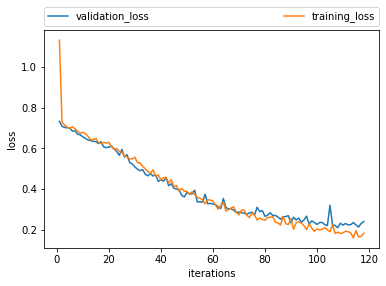

[0.733214623398251,
 0.7086770976031268,
 0.7029492788844638,
 0.7020082694512827,
 0.6991376611921523,
 0.6851639813847012,
 0.6868845246456288,
 0.6694722705417209,
 0.6672958908257661,
 0.6571240116048742,
 0.6492428956208406,
 0.6419613030221727,
 0.638531901218273,
 0.6347087732067814,
 0.6339538759655423,
 0.6240709711004186,
 0.6330295381722627,
 0.6078044750072338,
 0.604137145810657,
 0.6065339909659492,
 0.6116476643968511,
 0.597334380503054,
 0.5849765009350247,
 0.5663469036420187,
 0.5957165735739248,
 0.5577387324085942,
 0.5692465735806359,
 0.5306778285238478,
 0.5241838903338821,
 0.5091744241891084,
 0.4979737036757999,
 0.4909563252219447,
 0.49552837786851106,
 0.47336423617822154,
 0.46541309025552535,
 0.4764604259420324,
 0.4644483714192002,
 0.4708360930283864,
 0.4381301623803598,
 0.4460767761424736,
 0.4390895896487766,
 0.45528705694057325,
 0.4170932791851185,
 0.4267165749161332,
 0.404675778415468,
 0.4001807724988019,
 0.3964885550516623,
 0.36982994443

In [71]:
train_save('gender', 0, 2)

minibatch:49, epoch:1, iteration:49, training_error:1.1266509926319122, validation_error:0.7349149482003574
Best loss improvement from inf to 0.7349149482003574 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.7252929973602295, validation_error:0.704592359477076
Best loss improvement from 0.7349149482003574 to 0.704592359477076 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:0.717932288646698, validation_error:0.7120513093882593
minibatch:199, epoch:1, iteration:199, training_error:0.7041892111301422, validation_error:0.7055567338548857
minibatch:249, epoch:1, iteration:249, training_error:0.7084692275524139, validation_error:0.6930344577493339
Best loss improvement from 0.704592359477076 to 0.6930344577493339 in epoch 1
minibatch:47, epoch:2, iteration:299, training_error:0.7027176809310913, validation_error:0.7067164367642896
minibatch:97, epoch:2, iteration:349, training_error:0.7004241800308227, validation_error:0.6998389466055508
minibatch:147, epo

minibatch:27, epoch:12, iteration:2799, training_error:0.35566496044397355, validation_error:0.35587078846734144
Best loss improvement from 0.36912715794711276 to 0.35587078846734144 in epoch 12
minibatch:77, epoch:12, iteration:2849, training_error:0.37519110560417174, validation_error:0.3396171588322212
Best loss improvement from 0.35587078846734144 to 0.3396171588322212 in epoch 12
minibatch:127, epoch:12, iteration:2899, training_error:0.3668728268146515, validation_error:0.3771480743227334
minibatch:177, epoch:12, iteration:2949, training_error:0.3445712411403656, validation_error:0.36573813444581527
minibatch:227, epoch:12, iteration:2999, training_error:0.3735997286438942, validation_error:0.3357921448247186
Best loss improvement from 0.3396171588322212 to 0.3357921448247186 in epoch 12
minibatch:25, epoch:13, iteration:3049, training_error:0.34576871514320373, validation_error:0.3756339666915351
minibatch:75, epoch:13, iteration:3099, training_error:0.35831440657377245, validat

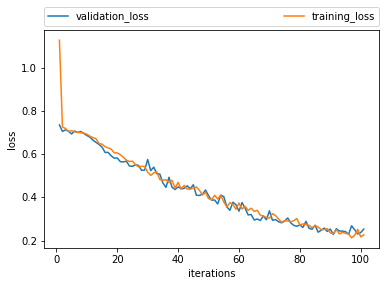

[0.7349149482003574,
 0.704592359477076,
 0.7120513093882593,
 0.7055567338548857,
 0.6930344577493339,
 0.7067164367642896,
 0.6998389466055508,
 0.7043094840543024,
 0.6952909950552315,
 0.6861262300918842,
 0.6785023890692612,
 0.6646227877715538,
 0.6541746155969028,
 0.644981339060027,
 0.6323105918950048,
 0.6073823709940088,
 0.607803630417791,
 0.5918997855022036,
 0.5811594632165186,
 0.5818409447012276,
 0.5650825428551641,
 0.5637176406794581,
 0.5668640814978501,
 0.5447086352726509,
 0.5433642869365627,
 0.5505290976886091,
 0.5472242986333782,
 0.524594389159104,
 0.525732074318261,
 0.5748932762392636,
 0.5232594095427414,
 0.5394699820156755,
 0.5087799882066661,
 0.507398606374346,
 0.4662885552850263,
 0.4456916040387647,
 0.49262443698685743,
 0.44631795071322344,
 0.4359127453945834,
 0.4479870580393693,
 0.4390788761706188,
 0.44129549121034556,
 0.45294551705491953,
 0.4395036954304268,
 0.45803936288274566,
 0.4093485361543195,
 0.4084652084214934,
 0.41406798876

In [72]:
train_save('gender', 1, 2)

minibatch:49, epoch:1, iteration:49, training_error:1.1160096371173858, validation_error:0.748016371809203
Best loss improvement from inf to 0.748016371809203 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.7338347256183624, validation_error:0.7102484764723942
Best loss improvement from 0.748016371809203 to 0.7102484764723942 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:0.7200460648536682, validation_error:0.7111398824330034
minibatch:199, epoch:1, iteration:199, training_error:0.7104265940189362, validation_error:0.7018071495253464
Best loss improvement from 0.7102484764723942 to 0.7018071495253464 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:0.7037344682216644, validation_error:0.7036585067880565
minibatch:39, epoch:2, iteration:299, training_error:0.702654070854187, validation_error:0.7162576749407011
minibatch:89, epoch:2, iteration:349, training_error:0.7020996844768524, validation_error:0.6880250984224779
Best loss improvem

minibatch:259, epoch:10, iteration:2599, training_error:0.3593978369235992, validation_error:0.40209611685111607
minibatch:49, epoch:11, iteration:2649, training_error:0.3592622038722038, validation_error:0.40361044632977455
minibatch:99, epoch:11, iteration:2699, training_error:0.34913413792848585, validation_error:0.38142089751260033
minibatch:149, epoch:11, iteration:2749, training_error:0.3685529640316963, validation_error:0.375860052889791
Best loss improvement from 0.38076714246437465 to 0.375860052889791 in epoch 11
minibatch:199, epoch:11, iteration:2799, training_error:0.35336175203323367, validation_error:0.3620480730615813
Best loss improvement from 0.375860052889791 to 0.3620480730615813 in epoch 11
minibatch:249, epoch:11, iteration:2849, training_error:0.3260040962696075, validation_error:0.41116017411495076
minibatch:39, epoch:12, iteration:2899, training_error:0.32767467975616454, validation_error:0.36925586852534065
minibatch:89, epoch:12, iteration:2949, training_erro

minibatch:39, epoch:22, iteration:5499, training_error:0.16244221702218056, validation_error:0.24595903836447616
minibatch:89, epoch:22, iteration:5549, training_error:0.17758222982287408, validation_error:0.28116599804368514
minibatch:139, epoch:22, iteration:5599, training_error:0.1763368958234787, validation_error:0.22745933640619803
Best loss improvement from 0.2357984465257875 to 0.22745933640619803 in epoch 22
minibatch:189, epoch:22, iteration:5649, training_error:0.15176627166569234, validation_error:0.26016453730648964
minibatch:239, epoch:22, iteration:5699, training_error:0.1908870265632868, validation_error:0.21836861993732123
Best loss improvement from 0.22745933640619803 to 0.21836861993732123 in epoch 22
minibatch:29, epoch:23, iteration:5749, training_error:0.16527673438191415, validation_error:0.22721435771933918
minibatch:79, epoch:23, iteration:5799, training_error:0.17435156255960466, validation_error:0.22648972388485383
minibatch:129, epoch:23, iteration:5849, trai

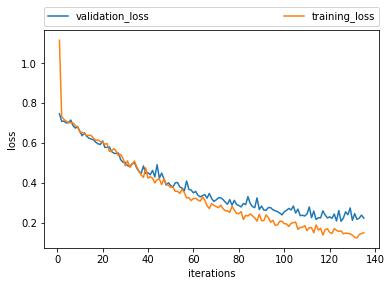

[0.748016371809203,
 0.7102484764723942,
 0.7111398824330034,
 0.7018071495253464,
 0.7036585067880565,
 0.7162576749407011,
 0.6880250984224779,
 0.6758418720344017,
 0.683837983114966,
 0.6600868434741579,
 0.6377123080450913,
 0.6525290567299415,
 0.6354705444697676,
 0.6258862409098395,
 0.6208408947648674,
 0.6173697627823929,
 0.6053965584985141,
 0.5973382201688043,
 0.5938092881235583,
 0.6118273693939735,
 0.579523620934322,
 0.5792350799872957,
 0.581777384568905,
 0.5580082114400535,
 0.5502622374172869,
 0.5485166927863812,
 0.5510028898715973,
 0.5176797149510219,
 0.5046385691083711,
 0.5049638470699047,
 0.48796661249522505,
 0.48338821427575474,
 0.4969656672971002,
 0.503474732925152,
 0.4767234366515587,
 0.45876316263757905,
 0.44993663759067143,
 0.48632214706519555,
 0.44915344694565085,
 0.4524288547450098,
 0.4421213228127052,
 0.4642515028345174,
 0.4314786473224903,
 0.4926143648295567,
 0.4253251778668371,
 0.45083395263244364,
 0.42179147745000906,
 0.3905767

In [73]:
train_save('gender', 2, 2)

minibatch:49, epoch:1, iteration:49, training_error:1.1190031003952026, validation_error:0.7277688548482698
Best loss improvement from inf to 0.7277688548482698 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.724605883359909, validation_error:0.7137655800786512
Best loss improvement from 0.7277688548482698 to 0.7137655800786512 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:0.7225725305080414, validation_error:0.7044999846096697
Best loss improvement from 0.7137655800786512 to 0.7044999846096697 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:0.6971933007240295, validation_error:0.6950676215106043
Best loss improvement from 0.7044999846096697 to 0.6950676215106043 in epoch 1
minibatch:249, epoch:1, iteration:249, training_error:0.7066679632663727, validation_error:0.7020346378457958
minibatch:41, epoch:2, iteration:299, training_error:0.7081627631187439, validation_error:0.6962101829463038
minibatch:91, epoch:2, iteration:349, trainin

minibatch:177, epoch:10, iteration:2499, training_error:0.4048889836668968, validation_error:0.373414034473485
minibatch:227, epoch:10, iteration:2549, training_error:0.42174637138843535, validation_error:0.4039300536287242
minibatch:19, epoch:11, iteration:2599, training_error:0.4130980882048607, validation_error:0.35401677931177206
Best loss improvement from 0.366987861949822 to 0.35401677931177206 in epoch 11
minibatch:69, epoch:11, iteration:2649, training_error:0.367765306532383, validation_error:0.3412279214324622
Best loss improvement from 0.35401677931177206 to 0.3412279214324622 in epoch 11
minibatch:119, epoch:11, iteration:2699, training_error:0.3735568189620972, validation_error:0.35605715574889346
minibatch:169, epoch:11, iteration:2749, training_error:0.36179382652044295, validation_error:0.3314840675427996
Best loss improvement from 0.3412279214324622 to 0.3314840675427996 in epoch 11
minibatch:219, epoch:11, iteration:2799, training_error:0.34331540048122405, validation

minibatch:131, epoch:22, iteration:5549, training_error:0.16713505059480668, validation_error:0.2591149141562396
minibatch:181, epoch:22, iteration:5599, training_error:0.18513039544224738, validation_error:0.24498102942417407
minibatch:231, epoch:22, iteration:5649, training_error:0.17452269047498703, validation_error:0.24763390190642456
minibatch:23, epoch:23, iteration:5699, training_error:0.21017696194350718, validation_error:0.25590549974605953
minibatch:73, epoch:23, iteration:5749, training_error:0.17581014961004257, validation_error:0.2386218818097279
minibatch:123, epoch:23, iteration:5799, training_error:0.1697428473085165, validation_error:0.24114159725863357
minibatch:173, epoch:23, iteration:5849, training_error:0.18317153185606003, validation_error:0.2326415255665779
minibatch:223, epoch:23, iteration:5899, training_error:0.1657401353865862, validation_error:0.25103126646115864
Patience ran out at 5899. Ending training


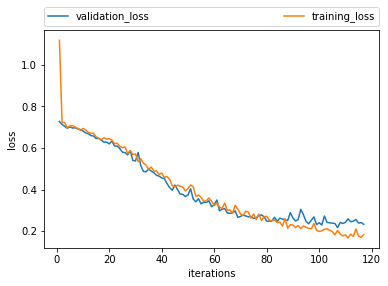

[0.7277688548482698,
 0.7137655800786512,
 0.7044999846096697,
 0.6950676215106043,
 0.7020346378457958,
 0.6962101829463038,
 0.6974832374474098,
 0.6920180526273004,
 0.6890696163835197,
 0.6820177641408197,
 0.6725449212666216,
 0.668633641867802,
 0.6600633386907906,
 0.6579757024501932,
 0.6456642335858839,
 0.646595903511705,
 0.6372721256880924,
 0.6281545388287512,
 0.6287733151994902,
 0.6197947140397697,
 0.6335950308832629,
 0.6097827348215826,
 0.6094326253595024,
 0.5975134660457743,
 0.5801485499431347,
 0.5777572105670797,
 0.5670693023451443,
 0.5870916822860981,
 0.539961359624205,
 0.5377899079487242,
 0.5787370564608738,
 0.5155380933449186,
 0.4876075828897542,
 0.4854547031994524,
 0.49856576323509216,
 0.48894100970235366,
 0.4808204071275119,
 0.46901328913096724,
 0.46452352918427564,
 0.45574019489617185,
 0.45357856154441833,
 0.42894520944562453,
 0.40977332509797193,
 0.39658506266001997,
 0.4217203516384651,
 0.40076108379610653,
 0.378567970004575,
 0.3765

In [74]:
train_save('gender', 3, 2)

minibatch:49, epoch:1, iteration:49, training_error:1.1328619086742402, validation_error:0.7330077763261467
Best loss improvement from inf to 0.7330077763261467 in epoch 1
minibatch:99, epoch:1, iteration:99, training_error:0.7278027141094208, validation_error:0.7134144141756255
Best loss improvement from 0.7330077763261467 to 0.7134144141756255 in epoch 1
minibatch:149, epoch:1, iteration:149, training_error:0.707532343864441, validation_error:0.7040467406141346
Best loss improvement from 0.7134144141756255 to 0.7040467406141346 in epoch 1
minibatch:199, epoch:1, iteration:199, training_error:0.7054255390167237, validation_error:0.7042365403010927
minibatch:249, epoch:1, iteration:249, training_error:0.6982636821269989, validation_error:0.6921242126103105
Best loss improvement from 0.7040467406141346 to 0.6921242126103105 in epoch 1
minibatch:44, epoch:2, iteration:299, training_error:0.7000256288051605, validation_error:0.6911385696509789
Best loss improvement from 0.6921242126103105

minibatch:99, epoch:11, iteration:2649, training_error:0.35852625042200087, validation_error:0.2935272604227066
Best loss improvement from 0.3127663952523264 to 0.2935272604227066 in epoch 11
minibatch:149, epoch:11, iteration:2699, training_error:0.351202637553215, validation_error:0.29534593841125223
minibatch:199, epoch:11, iteration:2749, training_error:0.32867938965559007, validation_error:0.29668915631442233
minibatch:249, epoch:11, iteration:2799, training_error:0.3094014498591423, validation_error:0.30629786746255283
minibatch:44, epoch:12, iteration:2849, training_error:0.32806148141622543, validation_error:0.28944845857291385
Best loss improvement from 0.2935272604227066 to 0.28944845857291385 in epoch 12
minibatch:94, epoch:12, iteration:2899, training_error:0.2953260383009911, validation_error:0.25213735165267154
Best loss improvement from 0.28944845857291385 to 0.25213735165267154 in epoch 12
minibatch:144, epoch:12, iteration:2949, training_error:0.33286958038806913, vali

minibatch:39, epoch:23, iteration:5649, training_error:0.18092536181211472, validation_error:0.18410444966164127
minibatch:89, epoch:23, iteration:5699, training_error:0.14602315098047255, validation_error:0.18771705802144675
minibatch:139, epoch:23, iteration:5749, training_error:0.16559896640479566, validation_error:0.16114739688306018
Best loss improvement from 0.1645047600413191 to 0.16114739688306018 in epoch 23
minibatch:189, epoch:23, iteration:5799, training_error:0.15926484890282155, validation_error:0.15933706560011568
Best loss improvement from 0.16114739688306018 to 0.15933706560011568 in epoch 23
minibatch:239, epoch:23, iteration:5849, training_error:0.13538552306592463, validation_error:0.1646836533628661
minibatch:34, epoch:24, iteration:5899, training_error:0.16080744117498397, validation_error:0.17233698147124257
minibatch:84, epoch:24, iteration:5949, training_error:0.1477797731012106, validation_error:0.1764430475646052
minibatch:134, epoch:24, iteration:5999, train

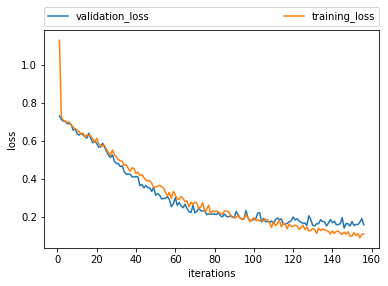

[0.7330077763261467,
 0.7134144141756255,
 0.7040467406141346,
 0.7042365403010927,
 0.6921242126103105,
 0.6911385696509789,
 0.6877607785422226,
 0.6569910830464857,
 0.6653141728762922,
 0.6381559166414984,
 0.6313891431380962,
 0.6390925358081686,
 0.6322892965941593,
 0.6221492454923433,
 0.6152988960003031,
 0.6409931285627957,
 0.6124230828778497,
 0.591277898385607,
 0.6004901548911785,
 0.5866403959948441,
 0.5671344378898884,
 0.5683900323407404,
 0.5882452376957598,
 0.5660887596936062,
 0.5448156595230103,
 0.5244574423494011,
 0.5122596549576727,
 0.5262346514340105,
 0.492459983661257,
 0.48064589705960503,
 0.48047193987616177,
 0.4643595907194861,
 0.4688844454699549,
 0.43745594394618065,
 0.4239414467893798,
 0.42335183456026276,
 0.42456238023166,
 0.4106935807343187,
 0.4087781947234581,
 0.41179517836406315,
 0.4094174802303314,
 0.3636839949879153,
 0.3699641602820364,
 0.3515426352106292,
 0.3642715935049386,
 0.35297476269047834,
 0.35239029752797096,
 0.3325659

In [75]:
train_save('gender', 4, 2)

In [76]:
print(get_performance_of_a_model("test", "gender", 0, 0))
print(get_performance_of_a_model("test", "gender", 1, 0))
print(get_performance_of_a_model("test", "gender", 2, 0))
print(get_performance_of_a_model("test", "gender", 3, 0))
print(get_performance_of_a_model("test", "gender", 4, 0))

{'accuracy': 0.8312952333416521}
{'accuracy': 0.826710816777042}
{'accuracy': 0.8219993732372297}
{'accuracy': 0.8474984930681133}
{'accuracy': 0.8131677736066993}


In [77]:
print(get_performance_of_a_model("test", "gender", 0, 1))
print(get_performance_of_a_model("test", "gender", 1, 1))
print(get_performance_of_a_model("test", "gender", 2, 1))
print(get_performance_of_a_model("test", "gender", 3, 1))
print(get_performance_of_a_model("test", "gender", 4, 1))

{'accuracy': 0.8560019965061143}
{'accuracy': 0.8416114790286976}
{'accuracy': 0.8414290191162644}
{'accuracy': 0.8761301989150091}
{'accuracy': 0.8287611897198961}


In [78]:
print(get_performance_of_a_model("test", "gender", 0, 2))
print(get_performance_of_a_model("test", "gender", 1, 2))
print(get_performance_of_a_model("test", "gender", 2, 2))
print(get_performance_of_a_model("test", "gender", 3, 2))
print(get_performance_of_a_model("test", "gender", 4, 2))

{'accuracy': 0.8677314699276266}
{'accuracy': 0.8454746136865342}
{'accuracy': 0.8505170792854905}
{'accuracy': 0.8710066305003014}
{'accuracy': 0.8356915968813168}


In [79]:
print(get_performance_of_a_model("test", "age", 0, 0))
print(get_performance_of_a_model("test", "age", 1, 0))
print(get_performance_of_a_model("test", "age", 2, 0))
print(get_performance_of_a_model("test", "age", 3, 0))
print(get_performance_of_a_model("test", "age", 4, 0))

{'accuracy': 0.5345227062094532, 'one-off accuracy': 0.8371177015755329}
{'accuracy': 0.39116414059980653, 'one-off accuracy': 0.7929700096742986}
{'accuracy': 0.5330937406409104, 'one-off accuracy': 0.855046421084157}
{'accuracy': 0.4, 'one-off accuracy': 0.8043697478991597}
{'accuracy': 0.48632548063904685, 'one-off accuracy': 0.7952883834281073}


In [80]:
print(get_performance_of_a_model("test", "age", 0, 1))
print(get_performance_of_a_model("test", "age", 1, 1))
print(get_performance_of_a_model("test", "age", 2, 1))
print(get_performance_of_a_model("test", "age", 3, 1))
print(get_performance_of_a_model("test", "age", 4, 1))

{'accuracy': 0.5583873957367933, 'one-off accuracy': 0.8542632066728453}
{'accuracy': 0.41567236375362787, 'one-off accuracy': 0.8223153821347953}
{'accuracy': 0.5684336627732854, 'one-off accuracy': 0.8784067085953878}
{'accuracy': 0.4561344537815126, 'one-off accuracy': 0.826218487394958}
{'accuracy': 0.47278635255889523, 'one-off accuracy': 0.8123476848090982}


In [81]:
print(get_performance_of_a_model("test", "age", 0, 2))
print(get_performance_of_a_model("test", "age", 1, 2))
print(get_performance_of_a_model("test", "age", 2, 2))
print(get_performance_of_a_model("test", "age", 3, 2))
print(get_performance_of_a_model("test", "age", 4, 2))

{'accuracy': 0.5727525486561631, 'one-off accuracy': 0.8982854494902688}
{'accuracy': 0.436633344082554, 'one-off accuracy': 0.8332795872299258}
{'accuracy': 0.5681341719077568, 'one-off accuracy': 0.8960766696615753}
{'accuracy': 0.4779831932773109, 'one-off accuracy': 0.8477310924369748}
{'accuracy': 0.4890333062550772, 'one-off accuracy': 0.8109937720010831}


In [35]:
print(get_performance_of_a_model("test", "both", 0, 0))
print(get_performance_of_a_model("test", "both", 1, 0))
print(get_performance_of_a_model("test", "both", 2, 0))
print(get_performance_of_a_model("test", "both", 3, 0))
print(get_performance_of_a_model("test", "both", 4, 0))

{'accuracy': 0.3694251095643207, 'one-off accuracy': 0.6653776746584171, 'gender accuracy': 0.8040732147460685, 'age accuracy': 0.374323279195669, 'one-off age accuracy': 0.6896107244135087}
{'accuracy': 0.34675540765391016, 'one-off accuracy': 0.6472545757071547, 'gender accuracy': 0.8026622296173045, 'age accuracy': 0.3570715474209651, 'one-off age accuracy': 0.6748752079866889}
{'accuracy': 0.39570650432553667, 'one-off accuracy': 0.674783723165652, 'gender accuracy': 0.8141621275232297, 'age accuracy': 0.40019224607497594, 'one-off age accuracy': 0.7004165331624479}
{'accuracy': 0.345778087927425, 'one-off accuracy': 0.6810886252616888, 'gender accuracy': 0.8293789253314724, 'age accuracy': 0.35101186322400557, 'one-off age accuracy': 0.7016748080949058}
{'accuracy': 0.3100088573959256, 'one-off accuracy': 0.6037791555949218, 'gender accuracy': 0.7794508414526129, 'age accuracy': 0.31620903454384414, 'one-off age accuracy': 0.6309418364334219}


In [82]:
print(get_performance_of_a_model("test", "both", 0, 1))
print(get_performance_of_a_model("test", "both", 1, 1))
print(get_performance_of_a_model("test", "both", 2, 1))
print(get_performance_of_a_model("test", "both", 3, 1))
print(get_performance_of_a_model("test", "both", 4, 1))

{'accuracy': 0.43464810518174785, 'one-off accuracy': 0.7275070894560454, 'gender accuracy': 0.8375870069605569, 'age accuracy': 0.43748388759989687, 'one-off age accuracy': 0.7419437999484403}
{'accuracy': 0.36805324459234606, 'one-off accuracy': 0.7034941763727122, 'gender accuracy': 0.8292845257903494, 'age accuracy': 0.37204658901830284, 'one-off age accuracy': 0.7178036605657238}
{'accuracy': 0.431272028196091, 'one-off accuracy': 0.712592117910926, 'gender accuracy': 0.8240948413969882, 'age accuracy': 0.43543735982057036, 'one-off age accuracy': 0.7273309836590837}
{'accuracy': 0.3743893928820656, 'one-off accuracy': 0.7390090718771808, 'gender accuracy': 0.8576413119330076, 'age accuracy': 0.3771807397069086, 'one-off age accuracy': 0.7477320307048151}
{'accuracy': 0.3327428402716268, 'one-off accuracy': 0.6241511662237968, 'gender accuracy': 0.7797460879834662, 'age accuracy': 0.3368762917035725, 'one-off age accuracy': 0.6442279303218187}
Accuracy  0.38822112222477545
One-off

In [83]:
print(get_performance_of_a_model("test", "both", 0, 2))
print(get_performance_of_a_model("test", "both", 1, 2))
print(get_performance_of_a_model("test", "both", 2, 2))
print(get_performance_of_a_model("test", "both", 3, 2))
print(get_performance_of_a_model("test", "both", 4, 2))

{'accuracy': 0.4606857437483888, 'one-off accuracy': 0.7568961072441351, 'gender accuracy': 0.8631090487238979, 'age accuracy': 0.4648105181747873, 'one-off age accuracy': 0.7703016241299304}
{'accuracy': 0.37437603993344426, 'one-off accuracy': 0.7277870216306156, 'gender accuracy': 0.8419301164725458, 'age accuracy': 0.3777038269550749, 'one-off age accuracy': 0.7437603993344426}
{'accuracy': 0.42582505607177185, 'one-off accuracy': 0.7097084267862864, 'gender accuracy': 0.8176866388977891, 'age accuracy': 0.4293495674463313, 'one-off age accuracy': 0.7241268824094841}
{'accuracy': 0.3831123517096999, 'one-off accuracy': 0.7397069085833915, 'gender accuracy': 0.8586880669923238, 'age accuracy': 0.3859036985345429, 'one-off age accuracy': 0.7480809490579204}
{'accuracy': 0.3413049896663714, 'one-off accuracy': 0.6586950103336285, 'gender accuracy': 0.8018895777974608, 'age accuracy': 0.34278122232063774, 'one-off age accuracy': 0.672571597283732}
Accuracy  0.39706083622593524
One-off 

### How to run?

1.   **Run `train_save()`:**


> You can do this for different combinations of **`c`**, **`fold`**, and **`train_transform_index`**, where **`c={'age','gender'}`**, **`fold={0,1,2,3,4}`**, and **`train_transform_index={0,1,2}`**.

> I suggest you to first train the network on all the folds for **either** **`age`** or **`gender`** and then proceed to the setp 2. Then, follow the same steps for the other class. Also, use **`train_transform_index=2`** as it gives smaller validation error due to random flipping and cropping.

> **Note:** It is just the network's architecture that is the same for age and gender. They both are trained independently. Ultimately, we will be having two different networks with the same architecture, one to classify age and the other to classify gender.

2. **Picking the best model:**

> Call **`pick_best_model()`** on either **`age`** or **`gender`**.

3. **Know the performance:**

> Call **`get_performance()`** on either **`age`** or **`gender`** to know the final performance of the network on the test set.



